In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from scipy.optimize import minimize
#from thesis import *
import matplotlib.patches as mpatches
from sklearn import metrics
from pyswarm import pso
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web
from pandas_datareader.moex import MoexReader
from multiprocessing import Pool
%matplotlib inline

In [4]:
pd.options.display.max_rows = 999

# Data preprocessing

## Bonds payments

In [3]:
bonds_payments = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Data/2016_bonds_2.csv', 
                            sep = ';')

In [4]:
bonds_payments.head()

Бумага          ISIN  Торговый код  Номер платежа  \
0  Россия, 26205  RU000A0JREQ7  SU26205RMFS3              1   
1  Россия, 26205  RU000A0JREQ7  SU26205RMFS3              2   
2  Россия, 26205  RU000A0JREQ7  SU26205RMFS3              3   
3  Россия, 26205  RU000A0JREQ7  SU26205RMFS3              4   
4  Россия, 26205  RU000A0JREQ7  SU26205RMFS3              5   

  Дата фактической выплаты  Ставка купона, % годовых  Сумма купона, RUB  \
0               26.10.2011                       7.6              40.81   
1               25.04.2012                       7.6              37.90   
2               24.10.2012                       7.6              37.90   
3               24.04.2013                       7.6              37.90   
4               23.10.2013                       7.6              37.90   

  Погашение номинала, RUB  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN

In [5]:
bonds_payments['Ставка купона, % годовых'] = bonds_payments['Ставка купона, % годовых'].apply(lambda x: str(x).replace(',','.'))
bonds_payments['Сумма купона, RUB'] = bonds_payments['Сумма купона, RUB'].apply(lambda x: str(x).replace(',','.'))

bonds_payments['Ставка купона, % годовых'] = pd.to_numeric(bonds_payments['Ставка купона, % годовых'])
bonds_payments['Сумма купона, RUB'] = pd.to_numeric(bonds_payments['Сумма купона, RUB'])/10

bonds_payments['Дата фактической выплаты'] = pd.to_datetime(bonds_payments['Дата фактической выплаты'])

bonds_payments['Бумага'] = bonds_payments['Бумага'].apply(lambda x: str(x).replace('Россия, ',''))
bonds_payments['Погашение номинала, RUB'] = bonds_payments['Погашение номинала, RUB'].apply(lambda x: float(str(x).replace(' ', '')))/10

bonds_payments.fillna(0, inplace = True)

In [6]:
bonds_payments.head()

Бумага          ISIN  Торговый код  Номер платежа Дата фактической выплаты  \
0  26205  RU000A0JREQ7  SU26205RMFS3              1               2011-10-26   
1  26205  RU000A0JREQ7  SU26205RMFS3              2               2012-04-25   
2  26205  RU000A0JREQ7  SU26205RMFS3              3               2012-10-24   
3  26205  RU000A0JREQ7  SU26205RMFS3              4               2013-04-24   
4  26205  RU000A0JREQ7  SU26205RMFS3              5               2013-10-23   

   Ставка купона, % годовых  Сумма купона, RUB  Погашение номинала, RUB  
0                       7.6              4.081                      0.0  
1                       7.6              3.790                      0.0  
2                       7.6              3.790                      0.0  
3                       7.6              3.790                      0.0  
4                       7.6              3.790                      0.0

In [7]:
bonds_payments['Торговый код'].unique()

array(['SU26205RMFS3', 'SU26207RMFS9', 'SU26208RMFS7', 'SU26209RMFS5',
       'SU26210RMFS3', 'SU26211RMFS1', 'SU26212RMFS9', 'SU26214RMFS5',
       'SU26215RMFS2', 'SU26216RMFS0', 'SU26217RMFS8', 'SU26218RMFS6',
       'SU26219RMFS4', 'SU46011RMFS1', 'SU46012RMFS9', 'SU46018RMFS6',
       'SU46019RMFS4', 'SU46020RMFS2', 'SU46022RMFS8', 'SU46023RMFS6'],
      dtype=object)

Saving

In [8]:
bonds_payments.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Data/2016_bonds_payments.csv')

In [2]:
bonds_payments = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Data/2016_bonds_payments.csv', index_col=0)
bonds_payments['Дата фактической выплаты'] = pd.to_datetime(bonds_payments['Дата фактической выплаты'])
bonds_payments.head()

Бумага          ISIN  Торговый код  Номер платежа Дата фактической выплаты  \
0   26205  RU000A0JREQ7  SU26205RMFS3              1               2011-10-26   
1   26205  RU000A0JREQ7  SU26205RMFS3              2               2012-04-25   
2   26205  RU000A0JREQ7  SU26205RMFS3              3               2012-10-24   
3   26205  RU000A0JREQ7  SU26205RMFS3              4               2013-04-24   
4   26205  RU000A0JREQ7  SU26205RMFS3              5               2013-10-23   

   Ставка купона, % годовых  Сумма купона, RUB  Погашение номинала, RUB  
0                       7.6              4.081                      0.0  
1                       7.6              3.790                      0.0  
2                       7.6              3.790                      0.0  
3                       7.6              3.790                      0.0  
4                       7.6              3.790                      0.0

## Bonds prices

In [4]:
dates = bonds_prices.index

In [187]:
bonds_payments['Бумага'].unique()

array([26205, 26207, 26208, 26209, 26210, 26211, 26212, 26214, 26215,
       26216, 26217, 26218, 26219, 46011, 46012, 46018, 46019, 46020,
       46022, 46023])

In [5]:
bond_trade_codes = bonds_payments['Торговый код'].unique()

In [8]:
bond_trade_codes

array(['SU26205RMFS3', 'SU26207RMFS9', 'SU26208RMFS7', 'SU26209RMFS5',
       'SU26210RMFS3', 'SU26211RMFS1', 'SU26212RMFS9', 'SU26214RMFS5',
       'SU26215RMFS2', 'SU26216RMFS0', 'SU26217RMFS8', 'SU26218RMFS6',
       'SU26219RMFS4', 'SU46011RMFS1', 'SU46012RMFS9', 'SU46018RMFS6',
       'SU46019RMFS4', 'SU46020RMFS2', 'SU46022RMFS8', 'SU46023RMFS6'],
      dtype=object)

In [11]:
bonds_list = [MoexReader(code, start = '01.01.2016', end = '31.12.2016').read() for code in bond_trade_codes]

In [12]:
bonds_list = [bonds_list[i][bonds_list[i].BOARDID == 'TQOB'].drop_duplicates()['CLOSE'] for i in range(len(bonds_list))]

In [13]:
for i in range(len(bond_trade_codes)):
    bonds_list[i].name = bond_trade_codes[i]

In [14]:
bonds_prices = pd.concat(bonds_list, axis = 1)

In [194]:
bonds_prices.head()

SU26205RMFS3  SU26207RMFS9  SU26208RMFS7  SU26209RMFS5  \
TRADEDATE                                                            
2016-01-05       92.3500       91.9995       94.3999       91.3000   
2016-01-06       92.0999       91.5999       94.4000       91.2000   
2016-01-11       90.4499       89.2999       93.2899       88.7000   
2016-01-12       89.2510       87.8001       92.9899       87.5011   
2016-01-13       89.5398       87.8502       92.7000       87.5100   

            SU26210RMFS3  SU26211RMFS1  SU26212RMFS9  SU26214RMFS5  \
TRADEDATE                                                            
2016-01-05       91.3004       87.6996       84.1000       88.7500   
2016-01-06       90.8900       87.6999       83.7494       88.6500   
2016-01-11       89.5000       85.5007       80.8000       87.4000   
2016-01-12       88.9649       84.1501       79.6579       86.3007   
2016-01-13       88.8500       84.3005       79.8000       86.4000   

            SU26215RMFS2  SU26216RMFS0  SU26217RMFS8  SU26218RMFS6  \
TRADEDATE                                                            
2016-01-05       87.1764       92.0500         89.59         89.24   
2016-01-06       86.6000       91.7200         89.59         89.24   
2016-01-11       84.2500       90.7900         89.59         89.24   
2016-01-12       83.5001       89.8102         89.59         89.24   
2016-01-13       83.4000       90.0000         89.59         89.24   

            SU26219RMFS4  SU46011RMFS1  SU46012RMFS9  SU46018RMFS6  \
TRADEDATE                                                            
2016-01-05         96.15         77.64          88.0         91.97   
2016-01-06         96.15         77.64          88.0         91.97   
2016-01-11         96.15         77.64          88.0         91.97   
2016-01-12         96.15         77.64          88.0         86.00   
2016-01-13         96.15         77.64          88.0         85.80   

            SU46019RMFS4  SU46020RMFS2  SU46022RMFS8  SU46023RMFS6  
TRADEDATE                                                           
2016-01-05          88.0       77.4480         83.31         109.2  
2016-01-06          88.0       77.9910         83.31         109.2  
2016-01-11          88.0       76.9900         83.31         109.2  
2016-01-12          88.0       76.0000         83.31         109.2  
2016-01-13          88.0       74.8453         83.31         109.2

У некоторых облигаций есть пропущенные значения цены. Поскольку они все погашаются после 2017 года, можно заполнить пропуски близжайшими ценами.

In [16]:
bonds_prices.fillna(method = 'ffill', inplace = True)

In [17]:
bonds_prices.fillna(method = 'backfill', inplace = True)

In [18]:
bonds_prices.head()

SU26205RMFS3  SU26207RMFS9  SU26208RMFS7  SU26209RMFS5  \
TRADEDATE                                                            
2016-01-05       92.3500       91.9995       94.3999       91.3000   
2016-01-06       92.0999       91.5999       94.4000       91.2000   
2016-01-11       90.4499       89.2999       93.2899       88.7000   
2016-01-12       89.2510       87.8001       92.9899       87.5011   
2016-01-13       89.5398       87.8502       92.7000       87.5100   

            SU26210RMFS3  SU26211RMFS1  SU26212RMFS9  SU26214RMFS5  \
TRADEDATE                                                            
2016-01-05       91.3004       87.6996       84.1000       88.7500   
2016-01-06       90.8900       87.6999       83.7494       88.6500   
2016-01-11       89.5000       85.5007       80.8000       87.4000   
2016-01-12       88.9649       84.1501       79.6579       86.3007   
2016-01-13       88.8500       84.3005       79.8000       86.4000   

            SU26215RMFS2  SU26216RMFS0  SU26217RMFS8  SU26218RMFS6  \
TRADEDATE                                                            
2016-01-05       87.1764       92.0500         89.59         89.24   
2016-01-06       86.6000       91.7200         89.59         89.24   
2016-01-11       84.2500       90.7900         89.59         89.24   
2016-01-12       83.5001       89.8102         89.59         89.24   
2016-01-13       83.4000       90.0000         89.59         89.24   

            SU26219RMFS4  SU46011RMFS1  SU46012RMFS9  SU46018RMFS6  \
TRADEDATE                                                            
2016-01-05         96.15         77.64          88.0         91.97   
2016-01-06         96.15         77.64          88.0         91.97   
2016-01-11         96.15         77.64          88.0         91.97   
2016-01-12         96.15         77.64          88.0         86.00   
2016-01-13         96.15         77.64          88.0         85.80   

            SU46019RMFS4  SU46020RMFS2  SU46022RMFS8  SU46023RMFS6  
TRADEDATE                                                           
2016-01-05          88.0       77.4480         83.31         109.2  
2016-01-06          88.0       77.9910         83.31         109.2  
2016-01-11          88.0       76.9900         83.31         109.2  
2016-01-12          88.0       76.0000         83.31         109.2  
2016-01-13          88.0       74.8453         83.31         109.2

In [19]:
bonds_prices.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Data/2016_bonds_prices.csv')

In [3]:
bonds_prices = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Data/2016_bonds_prices.csv', index_col='TRADEDATE', parse_dates=True)
bonds_prices.head()

SU26205RMFS3  SU26207RMFS9  SU26208RMFS7  SU26209RMFS5  \
TRADEDATE                                                            
2016-01-05       92.3500       91.9995       94.3999       91.3000   
2016-01-06       92.0999       91.5999       94.4000       91.2000   
2016-01-11       90.4499       89.2999       93.2899       88.7000   
2016-01-12       89.2510       87.8001       92.9899       87.5011   
2016-01-13       89.5398       87.8502       92.7000       87.5100   

            SU26210RMFS3  SU26211RMFS1  SU26212RMFS9  SU26214RMFS5  \
TRADEDATE                                                            
2016-01-05       91.3004       87.6996       84.1000       88.7500   
2016-01-06       90.8900       87.6999       83.7494       88.6500   
2016-01-11       89.5000       85.5007       80.8000       87.4000   
2016-01-12       88.9649       84.1501       79.6579       86.3007   
2016-01-13       88.8500       84.3005       79.8000       86.4000   

            SU26215RMFS2  SU26216RMFS0  SU26217RMFS8  SU26218RMFS6  \
TRADEDATE                                                            
2016-01-05       87.1764       92.0500         89.59         89.24   
2016-01-06       86.6000       91.7200         89.59         89.24   
2016-01-11       84.2500       90.7900         89.59         89.24   
2016-01-12       83.5001       89.8102         89.59         89.24   
2016-01-13       83.4000       90.0000         89.59         89.24   

            SU26219RMFS4  SU46011RMFS1  SU46012RMFS9  SU46018RMFS6  \
TRADEDATE                                                            
2016-01-05         96.15         77.64          88.0         91.97   
2016-01-06         96.15         77.64          88.0         91.97   
2016-01-11         96.15         77.64          88.0         91.97   
2016-01-12         96.15         77.64          88.0         86.00   
2016-01-13         96.15         77.64          88.0         85.80   

            SU46019RMFS4  SU46020RMFS2  SU46022RMFS8  SU46023RMFS6  
TRADEDATE                                                           
2016-01-05          88.0       77.4480         83.31         109.2  
2016-01-06          88.0       77.9910         83.31         109.2  
2016-01-11          88.0       76.9900         83.31         109.2  
2016-01-12          88.0       76.0000         83.31         109.2  
2016-01-13          88.0       74.8453         83.31         109.2

# Loss function generation

$$
y(t) = \beta_0 + \beta_1 \frac{1 - \exp(- m/\tau_1)}{m / \tau_1} + \beta_2 \Big (\frac{1 - \exp(- m/\tau_1)}{m / \tau_1} - \exp(-m/\tau_1) \Big ) + \beta_3 \Big (\frac{1 - \exp(- m/\tau_2)}{m / \tau_2} - \exp(-m/\tau_2) \Big )
$$

In [6]:
def nss(m, theta):
    tau1 = theta[0]
    tau2 = theta[1]
    beta0 = theta[2]
    beta1 = theta[3]
    beta2 = theta[4]
    beta3 = theta[5]
    return beta0 + beta1 * (1 - np.exp(- m / tau1)) / (m / tau1) + beta2 * ((1 - np.exp(- m / tau1)) / (m / tau1) - np.exp(- m / tau1)) + beta3 * ((1 - np.exp(- m / tau2)) / (m / tau2) - np.exp(- m / tau2))

In [7]:
def forward_nss(m, theta):
    tau1 = theta[0]
    tau2 = theta[1]
    beta0 = theta[2]
    beta1 = theta[3]
    beta2 = theta[4]
    beta3 = theta[5]
    return beta0 + beta1 * np.exp(- m / tau1) + beta2 * m / tau1 * np.exp(- m / tau1) + beta3 * m / tau2 * np.exp(- m / tau2)

### Restrictions

$$
c_1(\tau_1) = 0 < \tau_1 < 30
$$

$$
c_2(\tau_2) = 0 < \tau_2 < 30
$$

$$
c_3(\beta_0, \beta_1) = (\beta_0 + \beta_1) \geq 0
$$

$$
c_4(\beta_0) = 0 \leq \beta_0 \leq 100
$$

$$
c_5(\beta_1) = -100 \leq \beta_1 \leq 100
$$

$$
c_6(\beta_2) = -100 \leq \beta_2 \leq 100
$$

$$
c_7(\beta_3) = -100 \leq \beta_3 \leq 100
$$


In [8]:
def discount(df, theta):
    df['Discounted'] = (df['Сумма купона, RUB'] + df['Погашение номинала, RUB']) * np.exp(-nss(m = df['Дата фактической выплаты'], theta = theta)/100 * df['Дата фактической выплаты'])

In [9]:
def build_ss_loss_function(date):
    
    market_prices = bonds_prices[date:date].T
    market_prices.columns = ['Market prices']
    
    payments_on_date = bonds_payments[bonds_payments['Дата фактической выплаты'] >= date]
    
    def ss_loss_function(theta):
        
        C = np.ones(8) * 1000
        
        nonlocal payments_on_date, market_prices, date
    
        calc_df = pd.concat([(payments_on_date['Дата фактической выплаты'] - date).apply(lambda x: x.days)/365, 
                          payments_on_date[['Торговый код', 'Сумма купона, RUB', 'Погашение номинала, RUB']]], axis = 1)
        
        discount(calc_df, theta)
      
        calc_prices = pd.DataFrame(calc_df.groupby('Торговый код')['Discounted'].sum())
        
        result_df = pd.concat([pd.DataFrame(calc_df.groupby('Торговый код')['Discounted'].sum()), market_prices], axis = 1)
        
        #Sum of squares
        J = (((np.array(result_df['Discounted']) - np.array(result_df['Market prices']))/1000)**2).sum()
        
        #constraints
        if (theta[0] > 0) & (theta[0] <= 30):
            c1 = 0
        else:
            c1 = C[1] * theta[0]**2

        if (theta[1] > 0) & (theta[1] <= 30):
            c2 = 0
        else:
            c2 = C[2] * theta[1]**2
            
        if theta[2] + theta[3] >= 0:
            c3 = 0
        else:
            c3 = C[3] * (theta[2] + theta[3])**2
            
        if (theta[2] >= 0) & (theta[2] <= 100):
            c4 = 0
        else:
            c4 = C[4] * theta[2]**2
        
        if (theta[3] >= -100) & (theta[3] <= 100):
            c5 = 0
        else:
            c5 = C[5] * theta[3]**2 

        if (theta[4] >= -100) & (theta[4] <= 100):
            c6 = 0
        else:
            c6 = C[6] * theta[4]**2 
            
        if (theta[5] >= -100) & (theta[5] <= 100):
            c7 = 0
        else:
            c7 = C[7] * theta[5]**2 
                            
        return J + c1 + c2 + c3 + c4 + c5 + c6 + c7
    
    return ss_loss_function

In [9]:
def build_duration_weighted_ss_loss_function(date):
    
    market_prices = bonds_prices[date:date].T
    market_prices.columns = ['Market prices']
    
    payments_on_date = bonds_payments[bonds_payments['Дата фактической выплаты'] >= date]
    
    def ss_loss_function(theta):
        
        C = np.ones(8) * 1000
        
        nonlocal payments_on_date, market_prices, date
    
        calc_df = pd.concat([(payments_on_date['Дата фактической выплаты'] - date).apply(lambda x: x.days)/365, 
                          payments_on_date[['Торговый код', 'Сумма купона, RUB', 'Погашение номинала, RUB']]], axis = 1)
        
        discount(calc_df, theta)
        
        #duration
        duration = pd.DataFrame(data=np.zeros(20), index=bond_trade_codes, columns=['Duration'])
        
        for i in range(duration.shape[0]):
            flows = calc_df[calc_df['Торговый код'] == duration.index[i]]['Discounted']
            t = calc_df[calc_df['Торговый код'] == duration.index[i]]['Дата фактической выплаты']
            duration.Duration[i] = (flows @ t)/flows.sum()
              
        calc_prices = pd.DataFrame(calc_df.groupby('Торговый код')['Discounted'].sum())
        
        result_df = pd.concat([pd.DataFrame(calc_df.groupby('Торговый код')['Discounted'].sum()), market_prices, duration], axis = 1)
        result_df['w'] = (1 / result_df.Duration) / (1 / result_df.Duration).sum()
        
        #Sum of squares
        J = (result_df.w@((np.array(result_df['Discounted']) - np.array(result_df['Market prices']))**2)).sum()
        
        #constraints
        if (theta[0] > 0) & (theta[0] < 30):
            c1 = 0
        else:
            c1 = C[1] * theta[0]**2

        if (theta[1] > 0) & (theta[1] < 30):
            c2 = 0
        else:
            c2 = C[2] * theta[1]**2
            
        if theta[2] + theta[3] >= 0:
            c3 = 0
        else:
            c3 = C[3] * (theta[2] + theta[3])**2
            
        if (theta[2] >= 0) & (theta[2] <= 100):
            c4 = 0
        else:
            c4 = C[4] * theta[2]**2
        
        if (theta[3] >= 0) & (theta[3] <= 100):
            c5 = 0
        else:
            c5 = C[5] * theta[3]**2 

        if (theta[4] >= 0) & (theta[4] <= 100):
            c6 = 0
        else:
            c6 = C[6] * theta[4]**2 
            
        if (theta[5] >= 0) & (theta[5] <= 100):
            c7 = 0
        else:
            c7 = C[7] * theta[5]**2 
                            
        return J + c1 + c2 + c3 + c4 + c5 + c6 + c7
    
    return ss_loss_function

In [226]:
loss_func = build_ss_loss_function(date = bonds_prices.index[150])

In [227]:
loss_func(theta = np.array([1, 1, 1, 1, 1, 1]))

0.06044251131939097

In [15]:
bonds_prices.index[150]

Timestamp('2016-08-11 00:00:00')

Market curve on 2016-12-30

In [16]:
loss_func = build_ss_loss_function(date = bonds_prices.index[150])

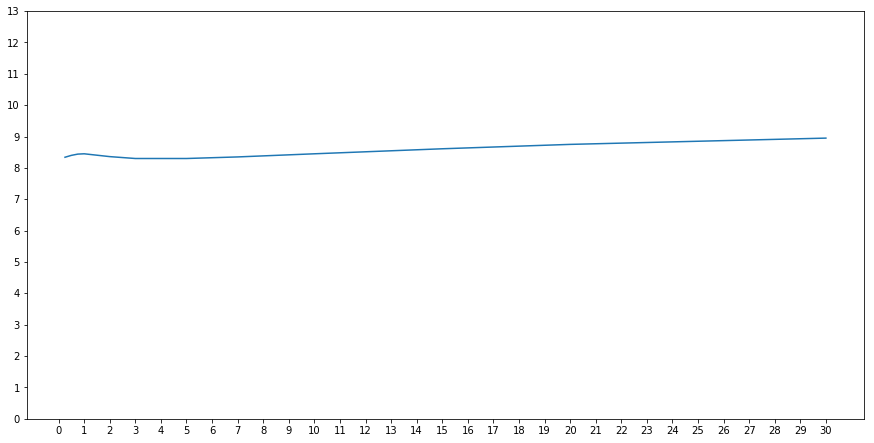

In [17]:
plt.figure(figsize = (15,7.5))
plt.plot(np.array([0.25, 0.5, 0.75, 1, 2, 3, 5, 7, 10, 15, 20, 30]), np.array([8.34, 8.40, 8.44, 8.45, 8.36, 8.30, 8.30, 8.35, 8.45, 8.61, 8.75, 8.95]))
plt.xticks(np.linspace(0, 30, 31))
plt.yticks(np.linspace(0, 20, 21))
plt.ylim(0, 13);

Market curve on 2016-08-11

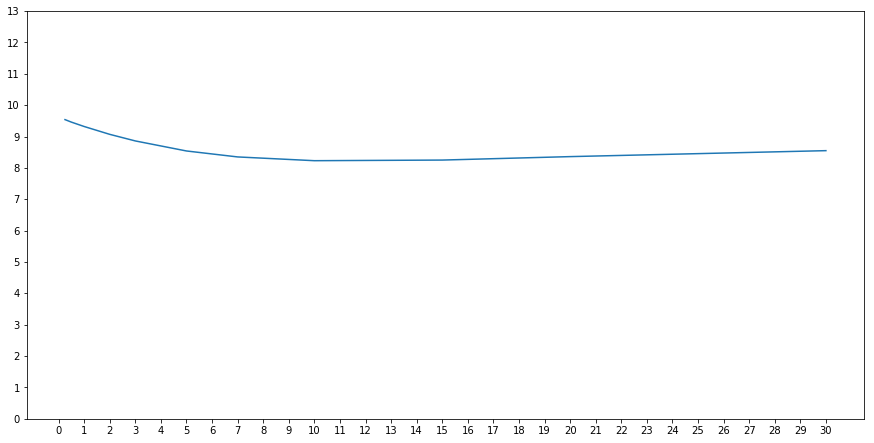

In [18]:
plt.figure(figsize = (15,7.5))
plt.plot(np.array([0.25, 0.5, 0.75, 1, 2, 3, 5, 7, 10, 15, 20, 30]), np.array([9.54, 9.46, 9.39, 9.32, 9.07, 8.86, 8.54, 8.35, 8.23, 8.25, 8.36, 8.55]))
plt.xticks(np.linspace(0, 30, 31))
plt.yticks(np.linspace(0, 20, 21))
plt.ylim(0, 13);

## BFGS

- $\tau$ can only be positive as it represents the 'hump' component.
- $\beta_0$ is the long run level of interest rates. It is unlikely to go below 0 and above 15.

In [223]:
%%time

theta0 = np.array([15, 7, 10, 10, 5, 10])

bfgs0 = minimize(loss_func, theta0, method='BFGS', options={'xtol': 1e-8, 'disp': True})

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: OptimizeWarning: Unknown solver options: xtol
  after removing the cwd from sys.path.
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in square


         Current function value: 168.779820
         Iterations: 6
         Function evaluations: 447
         Gradient evaluations: 55
CPU times: user 15.4 s, sys: 202 ms, total: 15.6 s
Wall time: 15.7 s


[18  3  3  0  7 14]


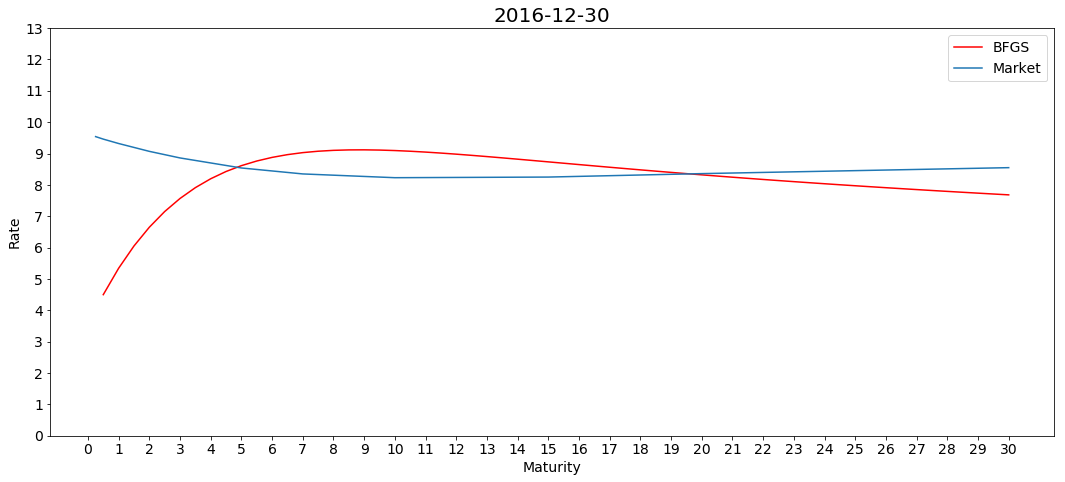

In [224]:
maturities = np.linspace(0.5, 30, 60)
plt.figure(figsize = (18,7.5))
plt.plot(maturities, nss(m = maturities, theta = bfgs0.x), color = 'red', label = 'BFGS')
plt.plot(np.array([0.25, 0.5, 0.75, 1, 2, 3, 5, 7, 10, 15, 20, 30]), np.array([9.54, 9.46, 9.39, 9.32, 9.07, 8.86, 8.54, 8.35, 8.23, 8.25, 8.36, 8.55]), label = 'Market')
plt.xticks(np.linspace(0, 30, 31), fontsize = 14)
plt.yticks(np.linspace(0, 20, 21), fontsize = 14)
plt.ylabel('Rate', fontsize = 14)
plt.xlabel('Maturity', fontsize = 14)
plt.ylim(0, 13)
plt.legend(fontsize = 14)
plt.title('2016-12-30', fontsize = 20);
print(bfgs0.x.astype(int))

# Nelder-Mead

In [233]:
%%time

theta0 = np.array([15, 7, 10, 10, 5, 10])

res = minimize(loss_func, theta0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})

CPU times: user 41.6 s, sys: 225 ms, total: 41.8 s
Wall time: 42.1 s


In [234]:
res

 final_simplex: (array([[ 2.68767368e+00,  8.64727355e+00,  1.79047706e-05,
        -3.41091621e-04,  1.92889174e+01,  1.64779358e+01],
       [ 2.68756838e+00,  8.64705874e+00,  1.22044221e-05,
        -3.43918134e-04,  1.92881076e+01,  1.64787236e+01],
       [ 2.68762507e+00,  8.64711496e+00,  9.08036428e-06,
        -3.41124617e-04,  1.92882466e+01,  1.64785305e+01],
       [ 2.68793815e+00,  8.64798985e+00,  1.16605369e-05,
        -3.42625652e-04,  1.92916566e+01,  1.64749249e+01],
       [ 2.68787531e+00,  8.64783882e+00,  2.13843680e-05,
        -3.46723898e-04,  1.92907893e+01,  1.64755847e+01],
       [ 2.68801370e+00,  8.64801524e+00,  8.48092912e-06,
        -3.37767386e-04,  1.92914688e+01,  1.64748922e+01],
       [ 2.68774064e+00,  8.64735835e+00,  1.77498171e-05,
        -3.46595095e-04,  1.92891065e+01,  1.64776733e+01]]), array([164.18937647, 164.18937652, 164.18937652, 164.18937652,
       164.18937653, 164.18937653, 164.18937653]))
           fun: 164.1893764745075


[ 2  8  0  0 19 16]


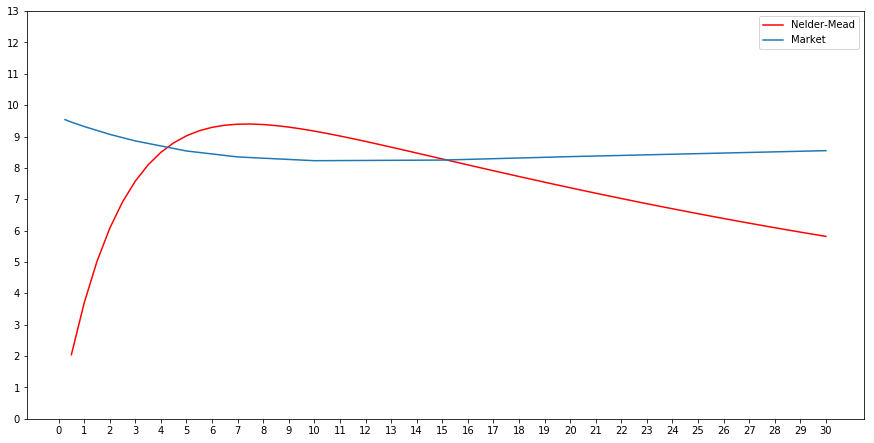

In [235]:
maturities = np.linspace(0.5, 30, 60)
plt.figure(figsize = (15,7.5))
plt.plot(maturities, nss(m = maturities, theta = res.x), color = 'red', label = 'Nelder-Mead')
plt.plot(np.array([0.25, 0.5, 0.75, 1, 2, 3, 5, 7, 10, 15, 20, 30]), np.array([9.54, 9.46, 9.39, 9.32, 9.07, 8.86, 8.54, 8.35, 8.23, 8.25, 8.36, 8.55]), label = 'Market')
plt.xticks(np.linspace(0, 30, 31))
plt.yticks(np.linspace(0, 20, 21))
plt.ylim(0, 13)
plt.legend();
print(res.x.astype(int))

# Powell

In [236]:
%%time

theta0 = np.array([15, 7, 10, 10, 5, 10])

res = minimize(loss_func, theta0, method='powell', options={'xtol': 1e-8, 'disp': True})

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in square


CPU times: user 3min 27s, sys: 827 ms, total: 3min 28s
Wall time: 3min 29s


In [238]:
res

   direc: array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])
     fun: nan
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 6153
     nit: 29
  status: 1
 success: False
       x: array([-0.326213  , 82.92288906, 85.92288906, 85.92288906, 80.92288906,
       85.92288906])

[-0.326213   82.92288906 85.92288906 85.92288906 80.92288906 85.92288906]


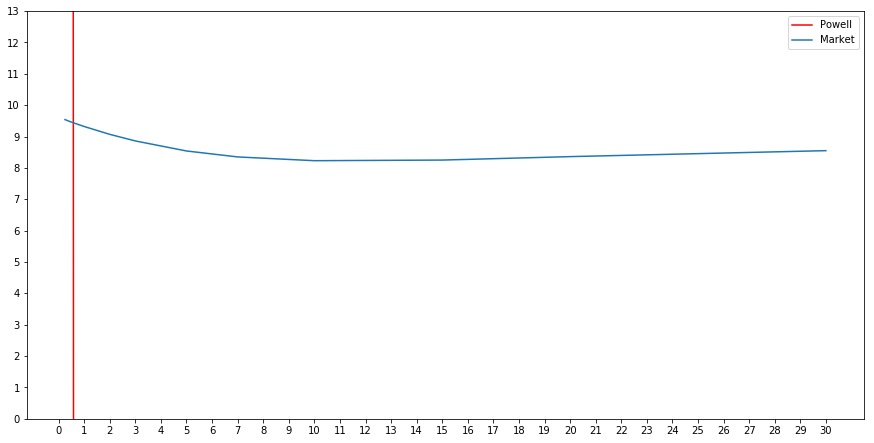

In [237]:
maturities = np.linspace(0.5, 30, 60)
plt.figure(figsize = (15,7.5))
plt.plot(maturities, nss(m = maturities, theta = res.x), color = 'red', label = 'Powell')
plt.plot(np.array([0.25, 0.5, 0.75, 1, 2, 3, 5, 7, 10, 15, 20, 30]), np.array([9.54, 9.46, 9.39, 9.32, 9.07, 8.86, 8.54, 8.35, 8.23, 8.25, 8.36, 8.55]), label = 'Market')
plt.xticks(np.linspace(0, 30, 31))
plt.yticks(np.linspace(0, 20, 21))
plt.ylim(0, 13)
plt.legend();
print(res.x)

# PSO

In [229]:
%%time
lb = [0, 0, -100, -100, -100, -100]
ub = [30, 30, 100, 100, 100, 100]

res = pso(func=loss_func, lb = lb, ub = ub)

Stopping search: maximum iterations reached --> 100
CPU times: user 5min 43s, sys: 1.53 s, total: 5min 45s
Wall time: 5min 48s


In [232]:
res

(array([ 1.60415018e+01,  2.19097859e+01, -6.09776190e-05,  7.26022608e+00,
         1.18441797e+01,  6.25452836e+00]), 176.05374438265062)

[ 1.60415018e+01  2.19097859e+01 -6.09776190e-05  7.26022608e+00
  1.18441797e+01  6.25452836e+00]


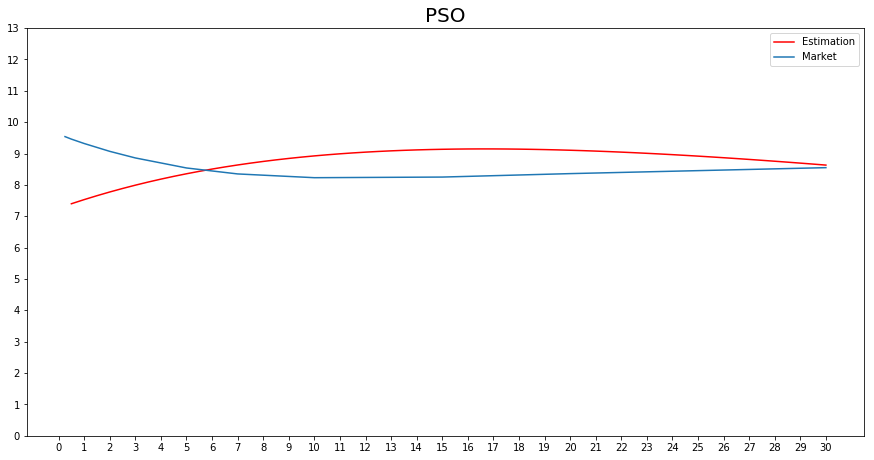

In [230]:
maturities = np.linspace(0.5, 30, 60)
plt.figure(figsize = (15,7.5))
plt.plot(maturities, nss(m = maturities, theta = res[0]), color = 'red', label = 'Estimation')
plt.plot(np.array([0.25, 0.5, 0.75, 1, 2, 3, 5, 7, 10, 15, 20, 30]), np.array([9.54, 9.46, 9.39, 9.32, 9.07, 8.86, 8.54, 8.35, 8.23, 8.25, 8.36, 8.55]), label = 'Market')
plt.xticks(np.linspace(0, 30, 31))
plt.yticks(np.linspace(0, 20, 21))
plt.ylim(0, 13)
plt.legend()
plt.title('PSO', fontsize = 20);
print(res[0])

In [231]:
%%bash
say finished

# Check on simulated prices

CB curve on 05.06.2016

In [14]:
market_curve = np.array([[0.25, 0.50, 0.75, 1.00, 2.00, 3.00, 5.00, 7.00, 10.00, 15.00, 20.00, 30.00], 
                         [8.65, 9.24, 9.61, 9.84, 10.09, 10.02, 9.85, 9.74, 9.61, 9.50, 9.46, 9.44]])

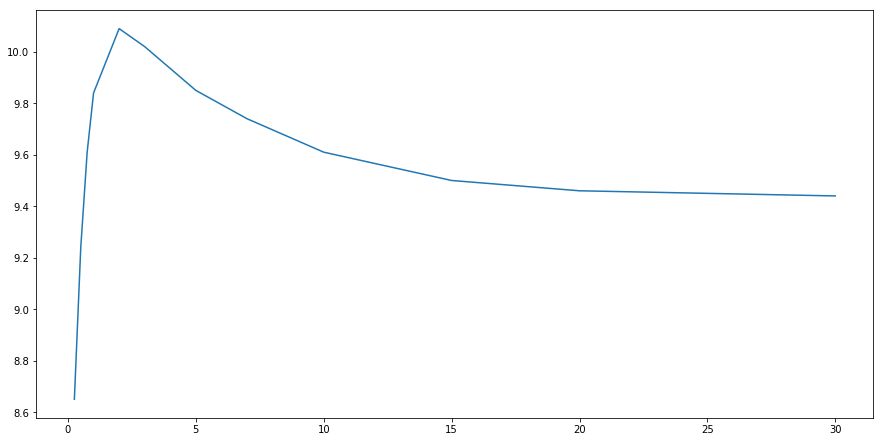

In [18]:
plt.figure(figsize = (15,7.5))
plt.plot(market_curve[0], market_curve[1]);

In [13]:
def fit_curve(theta):
    return ((market_curve[1] - nss(market_curve[0], theta))**2).sum()

In [15]:
theta0 = np.array([10, 10, 10, 10, 10, 10])

best_theta = minimize(fit_curve, theta0, method='nelder-mead',
               options={'xtol': 1e-8, 'disp': True, 'maxiter': 10000})

Optimization terminated successfully.
         Current function value: 0.000175
         Iterations: 2055
         Function evaluations: 3190


### Restored curve

Ниже параметры восстановленной кривой. Если мы дисконтируем облигации по ней, то, используя полученные цены облигация, оптимизитор должен прийти примерно к этим параметрам.

In [16]:
best_theta.x

array([ 0.62576401, 13.5631859 ,  9.94073464, -2.217379  ,  3.59716245,
       -1.80125066])

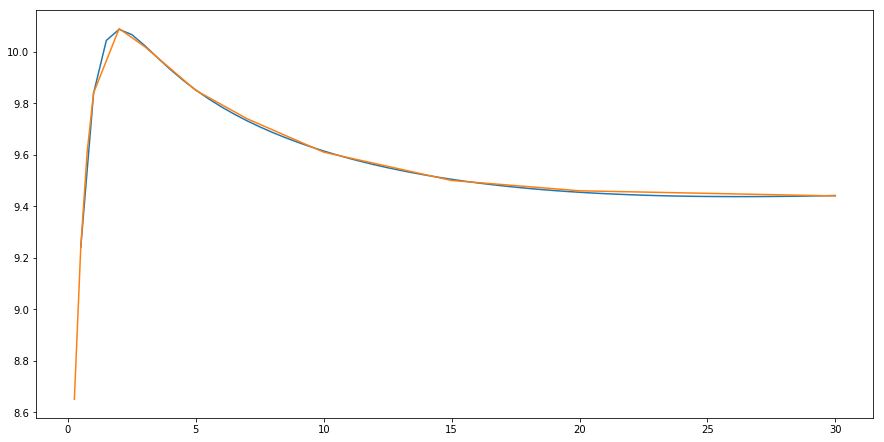

In [22]:
maturities = np.linspace(0.5, 30, 60)

plt.figure(figsize = (15,7.5))
plt.plot(maturities, nss(maturities, best_theta.x))
plt.plot(np.array([0.25, 0.50, 0.75, 1.00, 2.00, 3.00, 5.00, 7.00, 10.00, 15.00, 20.00, 30.00]), 
         np.array([8.65, 9.24, 9.61, 9.84, 10.09, 10.02, 9.85, 9.74, 9.61, 9.50, 9.46, 9.44]));

### Bonds prices simulation

In [193]:
date = bonds_prices.index[120]
date

Timestamp('2016-06-30 00:00:00')

In [43]:
flows_on_date = bonds_payments[bonds_payments['Дата фактической выплаты'] > date][['Торговый код', 'Дата фактической выплаты', 'Сумма купона, RUB', 'Погашение номинала, RUB']]
flows_on_date.head()

Торговый код Дата фактической выплаты  Сумма купона, RUB  \
10  SU26205RMFS3               2016-10-19               3.79   
11  SU26205RMFS3               2017-04-19               3.79   
12  SU26205RMFS3               2017-10-18               3.79   
13  SU26205RMFS3               2018-04-18               3.79   
14  SU26205RMFS3               2018-10-17               3.79   

    Погашение номинала, RUB  
10                      0.0  
11                      0.0  
12                      0.0  
13                      0.0  
14                      0.0

In [45]:
flows_on_date['m'] = (flows_on_date['Дата фактической выплаты'] - date).apply(lambda x: x.days)/365
flows_on_date.head()

Торговый код Дата фактической выплаты  Сумма купона, RUB  \
10  SU26205RMFS3               2016-10-19               3.79   
11  SU26205RMFS3               2017-04-19               3.79   
12  SU26205RMFS3               2017-10-18               3.79   
13  SU26205RMFS3               2018-04-18               3.79   
14  SU26205RMFS3               2018-10-17               3.79   

    Погашение номинала, RUB        m  
10                      0.0  0.30411  
11                      0.0  0.80274  
12                      0.0  1.30137  
13                      0.0  1.80000  
14                      0.0  2.29863

In [46]:
flows_on_date['curve rates'] = flows_on_date['m'].apply(lambda x: np.interp(x, market_curve[0], market_curve[1]))
flows_on_date.head()

Торговый код Дата фактической выплаты  Сумма купона, RUB  \
10  SU26205RMFS3               2016-10-19               3.79   
11  SU26205RMFS3               2017-04-19               3.79   
12  SU26205RMFS3               2017-10-18               3.79   
13  SU26205RMFS3               2018-04-18               3.79   
14  SU26205RMFS3               2018-10-17               3.79   

    Погашение номинала, RUB        m  curve rates  
10                      0.0  0.30411    10.027534  
11                      0.0  0.80274     9.754685  
12                      0.0  1.30137     9.539452  
13                      0.0  1.80000     9.340000  
14                      0.0  2.29863     9.167425

In [47]:
flows_on_date['Discounted'] = (flows_on_date['Погашение номинала, RUB'] + flows_on_date['Сумма купона, RUB']) * np.exp(-flows_on_date['m'] * flows_on_date['curve rates'] / 100)
flows_on_date.head()

Торговый код Дата фактической выплаты  Сумма купона, RUB  \
10  SU26205RMFS3               2016-10-19               3.79   
11  SU26205RMFS3               2017-04-19               3.79   
12  SU26205RMFS3               2017-10-18               3.79   
13  SU26205RMFS3               2018-04-18               3.79   
14  SU26205RMFS3               2018-10-17               3.79   

    Погашение номинала, RUB        m  curve rates  Discounted  
10                      0.0  0.30411    10.027534    3.676170  
11                      0.0  0.80274     9.754685    3.504547  
12                      0.0  1.30137     9.539452    3.347529  
13                      0.0  1.80000     9.340000    3.203507  
14                      0.0  2.29863     9.167425    3.069887

In [48]:
price_series = flows_on_date.groupby('Торговый код')['Discounted'].sum()
price_series

Торговый код
SU26205RMFS3     96.693635
SU26207RMFS9     99.403591
SU26208RMFS7     98.351150
SU26209RMFS5     98.140514
SU26210RMFS3     94.095227
SU26211RMFS1     91.575438
SU26212RMFS9     89.058536
SU26214RMFS5     92.071138
SU26215RMFS2     94.031222
SU26216RMFS0     94.521932
SU26217RMFS8     97.360826
SU26218RMFS6     98.320927
SU26219RMFS4     94.832929
SU46011RMFS1    114.210736
SU46012RMFS9     89.797347
SU46018RMFS6     92.146717
SU46019RMFS4     53.397079
SU46020RMFS2     89.551307
SU46022RMFS8     88.175214
SU46023RMFS6     97.313036
Name: Discounted, dtype: float64

In [49]:
price_series_df = pd.DataFrame(price_series)
price_series_df.head()

Discounted
Торговый код            
SU26205RMFS3   96.693635
SU26207RMFS9   99.403591
SU26208RMFS7   98.351150
SU26209RMFS5   98.140514
SU26210RMFS3   94.095227

In [50]:
price_series_df.columns.name = price_series_df.index.name
price_series_df.index.name = None

In [51]:
price_series_df.columns

Index(['Discounted'], dtype='object', name='Торговый код')

In [52]:
price_series_df.columns = ['2016-06-30 00:00:00']
price_series_df.columns.name = 'TRADEDATE'
price_series_df

TRADEDATE     2016-06-30 00:00:00
SU26205RMFS3            96.693635
SU26207RMFS9            99.403591
SU26208RMFS7            98.351150
SU26209RMFS5            98.140514
SU26210RMFS3            94.095227
SU26211RMFS1            91.575438
SU26212RMFS9            89.058536
SU26214RMFS5            92.071138
SU26215RMFS2            94.031222
SU26216RMFS0            94.521932
SU26217RMFS8            97.360826
SU26218RMFS6            98.320927
SU26219RMFS4            94.832929
SU46011RMFS1           114.210736
SU46012RMFS9            89.797347
SU46018RMFS6            92.146717
SU46019RMFS4            53.397079
SU46020RMFS2            89.551307
SU46022RMFS8            88.175214
SU46023RMFS6            97.313036

In [56]:
def build_ss_loss_function(date):
    market_prices = price_series_df
    market_prices.columns = ['Market prices']
    
    payments_on_date = bonds_payments[bonds_payments['Дата фактической выплаты'] >= date]
    
    def ss_loss_function(theta):
        
        nonlocal payments_on_date, market_prices, date        
    
        calc_df = pd.concat([(payments_on_date['Дата фактической выплаты'] - date).apply(lambda x: x.days)/365, 
                          payments_on_date[['Торговый код', 'Сумма купона, RUB', 'Погашение номинала, RUB']]], axis = 1)
        
        discount(calc_df, theta)
        
        calc_prices = pd.DataFrame(calc_df.groupby('Торговый код')['Discounted'].sum())
        
        result_df = pd.concat([pd.DataFrame(calc_df.groupby('Торговый код')['Discounted'].sum()), market_prices], axis = 1)
        
#        print(result_df)
        
        return ((np.array(result_df['Discounted']) - np.array(result_df['Market prices']))**2).sum()
    
    return ss_loss_function

## BFGS

In [254]:
best_theta.x

array([ 0.62576401, 13.5631859 ,  9.94073464, -2.217379  ,  3.59716245,
       -1.80125066])

In [255]:
theta0 = best_theta.x

res = minimize(simulated_loss_func, theta0, method='BFGS',
               options={'xtol': 1e-8, 'disp': True})

NameError: name 'simulated_loss_func' is not defined

[ 3.08560265  8.42837239  2.08860278 -3.09058546]


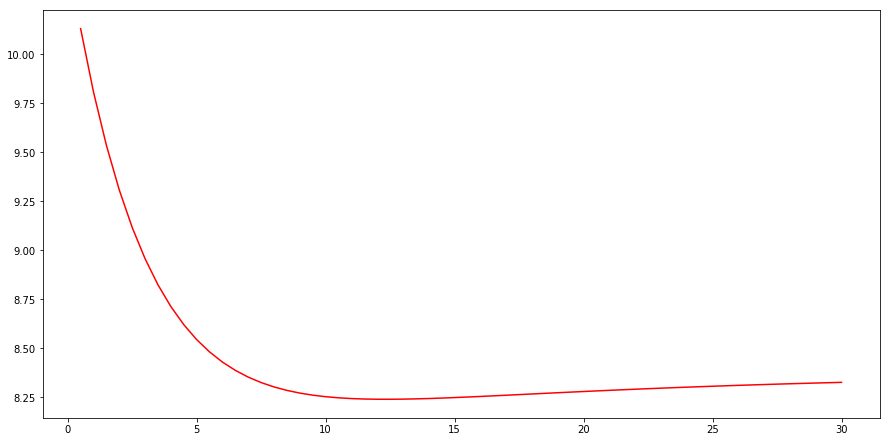

In [66]:
plt.figure(figsize = (15,7.5))
plt.plot(maturities, nss(m = maturities, theta = res.x), color = 'red');
print(res.x)

# Nelder-Mead

In [191]:
theta0 = np.array([1, 1, 1, 1])

res = minimize(simulated_loss_func, theta0, method='nelder-mead',
               options={'xtol': 1e-8, 'disp': True})

NameError: name 'simulated_loss_func' is not defined

[  0.12551901   8.03838152 -26.4497404   46.02925401]


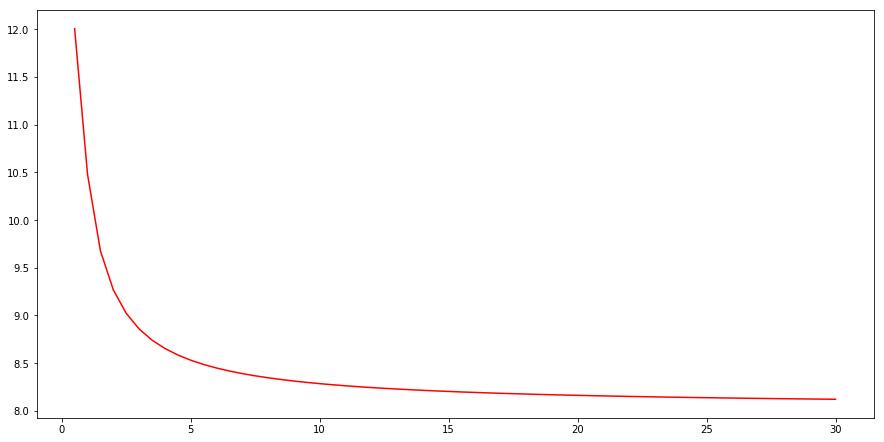

In [70]:
plt.figure(figsize = (15,7.5))
plt.plot(maturities, nss(m = maturities, theta = res.x), color = 'red');
print(res.x)

# Powell

In [189]:
theta0 = np.array([1, 1, 1, 1])

res = minimize(loss_func, theta0, method='powell',
               options={'xtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 1404.467158
         Iterations: 2
         Function evaluations: 329


[ 1.77854750e+06  7.49644807e+00  1.00525554e+00 -4.58223121e+03]


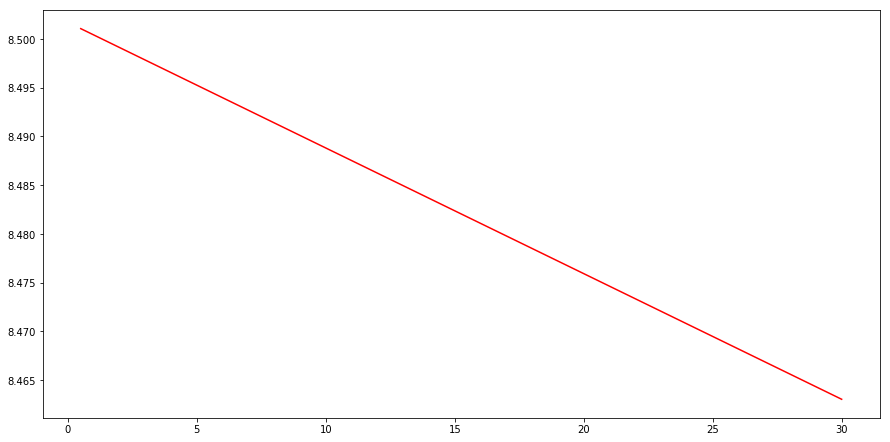

In [190]:
plt.figure(figsize = (15,7.5))
plt.plot(maturities, nss(m = maturities, theta = res.x), color = 'red');
print(res.x)

# PSO

In [75]:
lb = [-10, -10, -10, -10]
ub = [10, 10, 10, 10]

res = pso(func=loss_func, lb = lb, ub = ub, maxiter=1000)

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


Stopping search: Swarm best objective change less than 1e-08


In [77]:
res

(array([ 1.71102917,  8.04595484, -6.29572516, 10.        ]),
 1324.5360547768075)

[ 1.71102917  8.04595484 -6.29572516 10.        ]


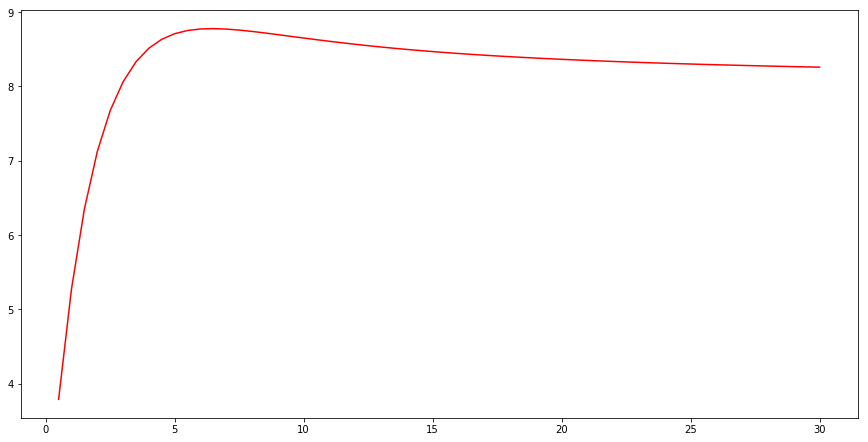

In [76]:
plt.figure(figsize = (15,7.5))
plt.plot(maturities, nss(m = maturities, theta = res[0]), color = 'red');
print(res[0])

# Each day calculations

# BFGS on each day

## Starting values = [1, 1, 1, 1]

In [60]:
%%time

bfgs_1111 = np.zeros([len(dates), 4])

theta0 = np.array([1, 1, 1, 1])

for i in range(len(dates)):
    
    loss_func = build_ss_loss_function(date = dates[i])
    loss_func(theta = theta0)

    res = minimize(loss_func, theta0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
    
    bfgs_1111[i] = res.x

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1346.592041
         Iterations: 91
         Function evaluations: 1314
         Gradient evaluations: 217


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1398.372053
         Iterations: 77
         Function evaluations: 846
         Gradient evaluations: 139


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1437.700687
         Iterations: 74
         Function evaluations: 1115
         Gradient evaluations: 184


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1385.935250
         Iterations: 79
         Function evaluations: 649
         Gradient evaluations: 108


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1396.914916
         Iterations: 70
         Function evaluations: 571
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1387.433106
         Iterations: 70
         Function evaluations: 1068
         Gradient evaluations: 176


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1378.963783
         Iterations: 71
         Function evaluations: 535
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1387.699132
         Iterations: 78
         Function evaluations: 1418
         Gradient evaluations: 234


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1387.167030
         Iterations: 73
         Function evaluations: 971
         Gradient evaluations: 160


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1474.457593
         Iterations: 74
         Function evaluations: 899
         Gradient evaluations: 148


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1456.048671
         Iterations: 66
         Function evaluations: 535
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1409.672870
         Iterations: 68
         Function evaluations: 1026
         Gradient evaluations: 169


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1361.558483
         Iterations: 85
         Function evaluations: 649
         Gradient evaluations: 108


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1341.996479
         Iterations: 82
         Function evaluations: 1394
         Gradient evaluations: 230


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1340.621026
         Iterations: 74
         Function evaluations: 760
         Gradient evaluations: 125


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1324.645235
         Iterations: 70
         Function evaluations: 529
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1449.167618
         Iterations: 88
         Function evaluations: 835
         Gradient evaluations: 139


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


         Current function value: 1196.676473
         Iterations: 81
         Function evaluations: 718
         Gradient evaluations: 119


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1186.798112
         Iterations: 72
         Function evaluations: 1458
         Gradient evaluations: 241


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1163.288094
         Iterations: 73
         Function evaluations: 1263
         Gradient evaluations: 210


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1161.412340
         Iterations: 70
         Function evaluations: 1237
         Gradient evaluations: 204


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1159.135725
         Iterations: 68
         Function evaluations: 854
         Gradient evaluations: 141


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1158.437992
         Iterations: 73
         Function evaluations: 661
         Gradient evaluations: 110


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1158.232761
         Iterations: 69
         Function evaluations: 978
         Gradient evaluations: 161


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1176.909631
         Iterations: 64
         Function evaluations: 702
         Gradient evaluations: 115


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1167.925050
         Iterations: 76
         Function evaluations: 619
         Gradient evaluations: 103


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1160.968043
         Iterations: 69
         Function evaluations: 667
         Gradient evaluations: 111


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1142.097083
         Iterations: 64
         Function evaluations: 773
         Gradient evaluations: 127


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1138.778483
         Iterations: 67
         Function evaluations: 810
         Gradient evaluations: 133


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 992.939972
         Iterations: 75
         Function evaluations: 1279
         Gradient evaluations: 210


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 908.440140
         Iterations: 45
         Function evaluations: 774
         Gradient evaluations: 127


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 527.628999
         Iterations: 119
         Function evaluations: 1019
         Gradient evaluations: 169


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 952.980971
         Iterations: 51
         Function evaluations: 893
         Gradient evaluations: 147


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 515.257196
         Iterations: 130
         Function evaluations: 1033
         Gradient evaluations: 172


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 527.041265
         Iterations: 94
         Function evaluations: 1412
         Gradient evaluations: 232


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 507.871325
         Iterations: 102
         Function evaluations: 787
         Gradient evaluations: 131


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 508.525811
         Iterations: 97
         Function evaluations: 1314
         Gradient evaluations: 217


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 509.223041
         Iterations: 120
         Function evaluations: 1392
         Gradient evaluations: 230


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large
         Current function value: 523.775749
         Iterations: 87
         Function evaluations: 1270
         Gradient evaluations: 210


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 879.514397
         Iterations: 37
         Function evaluations: 624
         Gradient evaluations: 102


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 876.551801
         Iterations: 44
         Function evaluations: 684
         Gradient evaluations: 112


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 873.768043
         Iterations: 35
         Function evaluations: 922
         Gradient evaluations: 152


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 512.661770
         Iterations: 104
         Function evaluations: 1068
         Gradient evaluations: 176


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 945.594950
         Iterations: 39
         Function evaluations: 794
         Gradient evaluations: 131


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 940.501733
         Iterations: 84
         Function evaluations: 1251
         Gradient evaluations: 207


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 905.980994
         Iterations: 37
         Function evaluations: 600
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 898.348221
         Iterations: 110
         Function evaluations: 1805
         Gradient evaluations: 299


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 899.051522
         Iterations: 116
         Function evaluations: 1598
         Gradient evaluations: 265


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 895.989112
         Iterations: 58
         Function evaluations: 1006
         Gradient evaluations: 166


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 792.368126
         Iterations: 28
         Function evaluations: 788
         Gradient evaluations: 130


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 796.515535
         Iterations: 30
         Function evaluations: 840
         Gradient evaluations: 138


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


         Current function value: 805.245900
         Iterations: 26
         Function evaluations: 770
         Gradient evaluations: 126


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 750.692734
         Iterations: 25
         Function evaluations: 431
         Gradient evaluations: 70


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1381.341238
         Iterations: 31
         Function evaluations: 664
         Gradient evaluations: 108


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1360.754738
         Iterations: 52
         Function evaluations: 1194
         Gradient evaluations: 197


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1344.117834
         Iterations: 38
         Function evaluations: 654
         Gradient evaluations: 107


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1373.763939
         Iterations: 31
         Function evaluations: 783
         Gradient evaluations: 129


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1359.118319
         Iterations: 29
         Function evaluations: 503
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1399.945757
         Iterations: 29
         Function evaluations: 804
         Gradient evaluations: 132


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1397.676867
         Iterations: 40
         Function evaluations: 900
         Gradient evaluations: 148


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1405.435231
         Iterations: 33
         Function evaluations: 804
         Gradient evaluations: 132


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1350.349171
         Iterations: 29
         Function evaluations: 714
         Gradient evaluations: 117


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1366.686725
         Iterations: 49
         Function evaluations: 978
         Gradient evaluations: 161


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1394.013470
         Iterations: 92
         Function evaluations: 1713
         Gradient evaluations: 282


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1415.640937
         Iterations: 67
         Function evaluations: 1446
         Gradient evaluations: 239


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1453.553428
         Iterations: 37
         Function evaluations: 850
         Gradient evaluations: 140


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1476.586732
         Iterations: 29
         Function evaluations: 359
         Gradient evaluations: 58


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1460.816963
         Iterations: 32
         Function evaluations: 540
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1467.174056
         Iterations: 31
         Function evaluations: 807
         Gradient evaluations: 133


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1387.871025
         Iterations: 30
         Function evaluations: 768
         Gradient evaluations: 126


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1404.981415
         Iterations: 90
         Function evaluations: 1419
         Gradient evaluations: 235


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1461.600240
         Iterations: 33
         Function evaluations: 591
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1417.759909
         Iterations: 32
         Function evaluations: 684
         Gradient evaluations: 112


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1322.137449
         Iterations: 48
         Function evaluations: 1380
         Gradient evaluations: 228


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1320.566502
         Iterations: 57
         Function evaluations: 1271
         Gradient evaluations: 210


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1399.658799
         Iterations: 30
         Function evaluations: 575
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1389.395010
         Iterations: 55
         Function evaluations: 988
         Gradient evaluations: 163


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1387.377780
         Iterations: 30
         Function evaluations: 419
         Gradient evaluations: 68


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1384.866339
         Iterations: 58
         Function evaluations: 1306
         Gradient evaluations: 216


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1610.459504
         Iterations: 109
         Function evaluations: 1163
         Gradient evaluations: 192


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1608.652140
         Iterations: 89
         Function evaluations: 1312
         Gradient evaluations: 217


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1604.964644
         Iterations: 78
         Function evaluations: 877
         Gradient evaluations: 146


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1397.753743
         Iterations: 30
         Function evaluations: 748
         Gradient evaluations: 122


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1395.161592
         Iterations: 32
         Function evaluations: 895
         Gradient evaluations: 148


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1399.310267
         Iterations: 49
         Function evaluations: 1096
         Gradient evaluations: 181


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1388.198719
         Iterations: 28
         Function evaluations: 694
         Gradient evaluations: 114


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1269.327774
         Iterations: 45
         Function evaluations: 887
         Gradient evaluations: 146


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1313.914805
         Iterations: 37
         Function evaluations: 785
         Gradient evaluations: 129


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1308.797051
         Iterations: 33
         Function evaluations: 738
         Gradient evaluations: 121


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1338.789949
         Iterations: 82
         Function evaluations: 1349
         Gradient evaluations: 223


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1375.427546
         Iterations: 98
         Function evaluations: 1547
         Gradient evaluations: 254


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 628.182240
         Iterations: 89
         Function evaluations: 1006
         Gradient evaluations: 166


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 554.222385
         Iterations: 101
         Function evaluations: 1151
         Gradient evaluations: 190


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 545.846493
         Iterations: 86
         Function evaluations: 1164
         Gradient evaluations: 192


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1370.129487
         Iterations: 69
         Function evaluations: 720
         Gradient evaluations: 118


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1375.406600
         Iterations: 86
         Function evaluations: 1283
         Gradient evaluations: 212


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1378.960563
         Iterations: 97
         Function evaluations: 1626
         Gradient evaluations: 268


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1373.456451
         Iterations: 96
         Function evaluations: 1285
         Gradient evaluations: 214


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


         Current function value: 1362.525910
         Iterations: 66
         Function evaluations: 1084
         Gradient evaluations: 178


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


         Current function value: 1363.458080
         Iterations: 87
         Function evaluations: 1663
         Gradient evaluations: 273


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 768.197942
         Iterations: 69
         Function evaluations: 1020
         Gradient evaluations: 168


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


         Current function value: 754.412629
         Iterations: 90
         Function evaluations: 1149
         Gradient evaluations: 189


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1573.557431
         Iterations: 92
         Function evaluations: 1278
         Gradient evaluations: 211


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1603.730008
         Iterations: 64
         Function evaluations: 1157
         Gradient evaluations: 191


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


         Current function value: 802.480951
         Iterations: 103
         Function evaluations: 1657
         Gradient evaluations: 272


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 817.208139
         Iterations: 74
         Function evaluations: 595
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


         Current function value: 812.166927
         Iterations: 73
         Function evaluations: 926
         Gradient evaluations: 152


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 801.997675
         Iterations: 88
         Function evaluations: 1158
         Gradient evaluations: 191


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1444.205579
         Iterations: 54
         Function evaluations: 924
         Gradient evaluations: 152


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 601.886825
         Iterations: 100
         Function evaluations: 1003
         Gradient evaluations: 167


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


         Current function value: 581.278020
         Iterations: 81
         Function evaluations: 1150
         Gradient evaluations: 189


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 597.744880
         Iterations: 87
         Function evaluations: 1122
         Gradient evaluations: 185


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 606.976504
         Iterations: 89
         Function evaluations: 1247
         Gradient evaluations: 206


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 603.944625
         Iterations: 81
         Function evaluations: 917
         Gradient evaluations: 151


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 588.656890
         Iterations: 87
         Function evaluations: 777
         Gradient evaluations: 128


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 622.883726
         Iterations: 86
         Function evaluations: 894
         Gradient evaluations: 147


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 611.460811
         Iterations: 90
         Function evaluations: 1200
         Gradient evaluations: 198


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


         Current function value: 614.620736
         Iterations: 93
         Function evaluations: 1024
         Gradient evaluations: 170


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 617.543995
         Iterations: 86
         Function evaluations: 673
         Gradient evaluations: 112


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


         Current function value: 607.698039
         Iterations: 80
         Function evaluations: 1151
         Gradient evaluations: 189


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 654.757808
         Iterations: 91
         Function evaluations: 1188
         Gradient evaluations: 196


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 659.731607
         Iterations: 81
         Function evaluations: 1032
         Gradient evaluations: 170


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1450.782506
         Iterations: 127
         Function evaluations: 1261
         Gradient evaluations: 210


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 653.146580
         Iterations: 87
         Function evaluations: 1140
         Gradient evaluations: 188


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 791.481700
         Iterations: 75
         Function evaluations: 709
         Gradient evaluations: 118


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 783.677312
         Iterations: 80
         Function evaluations: 1380
         Gradient evaluations: 228


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 764.025508
         Iterations: 70
         Function evaluations: 894
         Gradient evaluations: 147


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1429.474705
         Iterations: 134
         Function evaluations: 1765
         Gradient evaluations: 294


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 621.927321
         Iterations: 103
         Function evaluations: 1592
         Gradient evaluations: 263


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1395.008944
         Iterations: 46
         Function evaluations: 427
         Gradient evaluations: 71


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 619.358958
         Iterations: 91
         Function evaluations: 851
         Gradient evaluations: 140


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


         Current function value: 623.467919
         Iterations: 93
         Function evaluations: 1278
         Gradient evaluations: 210


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 601.831520
         Iterations: 91
         Function evaluations: 907
         Gradient evaluations: 151


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 592.723384
         Iterations: 84
         Function evaluations: 1574
         Gradient evaluations: 259


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 592.430941
         Iterations: 88
         Function evaluations: 1160
         Gradient evaluations: 193


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 623.506975
         Iterations: 96
         Function evaluations: 811
         Gradient evaluations: 135


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 605.985593
         Iterations: 90
         Function evaluations: 847
         Gradient evaluations: 141


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 579.845844
         Iterations: 89
         Function evaluations: 1610
         Gradient evaluations: 265


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 555.242381
         Iterations: 82
         Function evaluations: 935
         Gradient evaluations: 154


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 595.287400
         Iterations: 88
         Function evaluations: 863
         Gradient evaluations: 142


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 605.783427
         Iterations: 119
         Function evaluations: 1313
         Gradient evaluations: 217


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1448.734828
         Iterations: 34
         Function evaluations: 790
         Gradient evaluations: 130


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1476.286395
         Iterations: 37
         Function evaluations: 563
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1476.883172
         Iterations: 98
         Function evaluations: 1344
         Gradient evaluations: 222


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1427.874040
         Iterations: 50
         Function evaluations: 948
         Gradient evaluations: 156


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1468.857964
         Iterations: 56
         Function evaluations: 810
         Gradient evaluations: 133


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 599.658633
         Iterations: 89
         Function evaluations: 709
         Gradient evaluations: 118


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1482.000008
         Iterations: 123
         Function evaluations: 2097
         Gradient evaluations: 347


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1503.658194
         Iterations: 140
         Function evaluations: 1880
         Gradient evaluations: 312


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1519.184838
         Iterations: 62
         Function evaluations: 1002
         Gradient evaluations: 165


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 614.328995
         Iterations: 91
         Function evaluations: 1295
         Gradient evaluations: 214


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


         Current function value: 596.710760
         Iterations: 93
         Function evaluations: 1140
         Gradient evaluations: 188


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 591.355178
         Iterations: 93
         Function evaluations: 1032
         Gradient evaluations: 170


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1496.676471
         Iterations: 54
         Function evaluations: 983
         Gradient evaluations: 162


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1552.486061
         Iterations: 48
         Function evaluations: 1048
         Gradient evaluations: 173


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1539.437082
         Iterations: 54
         Function evaluations: 777
         Gradient evaluations: 128


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1537.258944
         Iterations: 61
         Function evaluations: 1072
         Gradient evaluations: 177


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1525.867890
         Iterations: 85
         Function evaluations: 1271
         Gradient evaluations: 210


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1569.639423
         Iterations: 34
         Function evaluations: 545
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1560.263046
         Iterations: 120
         Function evaluations: 1650
         Gradient evaluations: 273


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1568.000829
         Iterations: 33
         Function evaluations: 1026
         Gradient evaluations: 169


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1557.303919
         Iterations: 47
         Function evaluations: 1085
         Gradient evaluations: 179


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


         Current function value: 1550.471062
         Iterations: 32
         Function evaluations: 795
         Gradient evaluations: 130


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1546.380889
         Iterations: 33
         Function evaluations: 502
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1324.396217
         Iterations: 111
         Function evaluations: 1692
         Gradient evaluations: 280


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1373.447389
         Iterations: 47
         Function evaluations: 989
         Gradient evaluations: 163


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1380.024725
         Iterations: 36
         Function evaluations: 894
         Gradient evaluations: 147


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1382.830451
         Iterations: 31
         Function evaluations: 437
         Gradient evaluations: 71


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1387.765150
         Iterations: 34
         Function evaluations: 792
         Gradient evaluations: 130


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1409.595598
         Iterations: 55
         Function evaluations: 1388
         Gradient evaluations: 229


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1419.376843
         Iterations: 98
         Function evaluations: 1584
         Gradient evaluations: 262


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1410.527198
         Iterations: 36
         Function evaluations: 894
         Gradient evaluations: 147


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1406.477894
         Iterations: 50
         Function evaluations: 947
         Gradient evaluations: 156


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1447.835754
         Iterations: 40
         Function evaluations: 768
         Gradient evaluations: 126


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1408.518282
         Iterations: 74
         Function evaluations: 840
         Gradient evaluations: 138


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1405.056597
         Iterations: 144
         Function evaluations: 2154
         Gradient evaluations: 357


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1390.976088
         Iterations: 33
         Function evaluations: 881
         Gradient evaluations: 145


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1416.044449
         Iterations: 104
         Function evaluations: 1756
         Gradient evaluations: 291


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1325.255400
         Iterations: 67
         Function evaluations: 1038
         Gradient evaluations: 171


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1331.839387
         Iterations: 32
         Function evaluations: 808
         Gradient evaluations: 133


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1333.556086
         Iterations: 32
         Function evaluations: 613
         Gradient evaluations: 101


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1294.640466
         Iterations: 102
         Function evaluations: 1663
         Gradient evaluations: 276


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1352.919014
         Iterations: 30
         Function evaluations: 407
         Gradient evaluations: 66


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1352.002597
         Iterations: 53
         Function evaluations: 930
         Gradient evaluations: 153


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1354.359195
         Iterations: 30
         Function evaluations: 952
         Gradient evaluations: 157


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1355.714587
         Iterations: 114
         Function evaluations: 2161
         Gradient evaluations: 357


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1358.179014
         Iterations: 44
         Function evaluations: 625
         Gradient evaluations: 104


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1398.278214
         Iterations: 41
         Function evaluations: 373
         Gradient evaluations: 62


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1365.809231
         Iterations: 42
         Function evaluations: 588
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1380.591057
         Iterations: 93
         Function evaluations: 1271
         Gradient evaluations: 210


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


         Current function value: 485.539190
         Iterations: 83
         Function evaluations: 781
         Gradient evaluations: 129


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1363.286825
         Iterations: 31
         Function evaluations: 684
         Gradient evaluations: 112


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 467.081210
         Iterations: 76
         Function evaluations: 810
         Gradient evaluations: 133


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 462.454939
         Iterations: 93
         Function evaluations: 1073
         Gradient evaluations: 177


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 456.181158
         Iterations: 80
         Function evaluations: 1080
         Gradient evaluations: 178


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 441.057856
         Iterations: 99
         Function evaluations: 1061
         Gradient evaluations: 175


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 450.078045
         Iterations: 82
         Function evaluations: 1259
         Gradient evaluations: 208


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 433.209513
         Iterations: 77
         Function evaluations: 838
         Gradient evaluations: 138


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 424.898455
         Iterations: 79
         Function evaluations: 1050
         Gradient evaluations: 173


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 445.829315
         Iterations: 84
         Function evaluations: 625
         Gradient evaluations: 104


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 447.050213
         Iterations: 77
         Function evaluations: 1261
         Gradient evaluations: 207


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


         Current function value: 452.650748
         Iterations: 77
         Function evaluations: 1239
         Gradient evaluations: 204


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 447.315340
         Iterations: 88
         Function evaluations: 1110
         Gradient evaluations: 183


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 447.663004
         Iterations: 79
         Function evaluations: 766
         Gradient evaluations: 126


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 442.272587
         Iterations: 91
         Function evaluations: 1199
         Gradient evaluations: 198


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 437.965418
         Iterations: 94
         Function evaluations: 1484
         Gradient evaluations: 245


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 435.367162
         Iterations: 83
         Function evaluations: 1140
         Gradient evaluations: 188


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 435.563024
         Iterations: 92
         Function evaluations: 1192
         Gradient evaluations: 197


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 434.941542
         Iterations: 80
         Function evaluations: 1031
         Gradient evaluations: 170


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 426.194953
         Iterations: 93
         Function evaluations: 882
         Gradient evaluations: 145


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 428.799445
         Iterations: 83
         Function evaluations: 1179
         Gradient evaluations: 195


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1435.697293
         Iterations: 42
         Function evaluations: 804
         Gradient evaluations: 132


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1432.133675
         Iterations: 48
         Function evaluations: 612
         Gradient evaluations: 100


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1440.863698
         Iterations: 86
         Function evaluations: 1321
         Gradient evaluations: 219


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1466.003968
         Iterations: 56
         Function evaluations: 855
         Gradient evaluations: 141


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1485.558385
         Iterations: 54
         Function evaluations: 870
         Gradient evaluations: 143


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 1479.858556
         Iterations: 43
         Function evaluations: 401
         Gradient evaluations: 65


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 444.555684
         Iterations: 80
         Function evaluations: 1080
         Gradient evaluations: 178


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 439.846655
         Iterations: 71
         Function evaluations: 982
         Gradient evaluations: 162


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 441.601662
         Iterations: 74
         Function evaluations: 983
         Gradient evaluations: 162


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 444.285202
         Iterations: 86
         Function evaluations: 1037
         Gradient evaluations: 171


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 396.522513
         Iterations: 84
         Function evaluations: 1140
         Gradient evaluations: 188


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 390.102364
         Iterations: 101
         Function evaluations: 1104
         Gradient evaluations: 182


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 387.463920
         Iterations: 91
         Function evaluations: 733
         Gradient evaluations: 122


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 383.953579
         Iterations: 80
         Function evaluations: 1013
         Gradient evaluations: 167


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 381.932326
         Iterations: 83
         Function evaluations: 1050
         Gradient evaluations: 173


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 380.469968
         Iterations: 82
         Function evaluations: 965
         Gradient evaluations: 159


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 382.853662
         Iterations: 90
         Function evaluations: 1103
         Gradient evaluations: 182


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 394.941190
         Iterations: 87
         Function evaluations: 1299
         Gradient evaluations: 213


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 390.971663
         Iterations: 78
         Function evaluations: 965
         Gradient evaluations: 159


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 391.179979
         Iterations: 80
         Function evaluations: 934
         Gradient evaluations: 154


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 385.510867
         Iterations: 69
         Function evaluations: 726
         Gradient evaluations: 119


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 384.218058
         Iterations: 79
         Function evaluations: 899
         Gradient evaluations: 148


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 398.222544
         Iterations: 78
         Function evaluations: 863
         Gradient evaluations: 142


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


         Current function value: 399.084685
         Iterations: 83
         Function evaluations: 957
         Gradient evaluations: 157


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 397.371903
         Iterations: 75
         Function evaluations: 1199
         Gradient evaluations: 198


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


         Current function value: 386.539367
         Iterations: 89
         Function evaluations: 1072
         Gradient evaluations: 176


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


         Current function value: 398.980673
         Iterations: 91
         Function evaluations: 1274
         Gradient evaluations: 209


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 426.066683
         Iterations: 79
         Function evaluations: 977
         Gradient evaluations: 161


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 413.087915
         Iterations: 83
         Function evaluations: 1206
         Gradient evaluations: 199


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 413.829269
         Iterations: 91
         Function evaluations: 1440
         Gradient evaluations: 238


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 401.435964
         Iterations: 81
         Function evaluations: 840
         Gradient evaluations: 138


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 404.635356
         Iterations: 82
         Function evaluations: 1883
         Gradient evaluations: 311


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 393.752306
         Iterations: 82
         Function evaluations: 1024
         Gradient evaluations: 169


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 380.388596
         Iterations: 91
         Function evaluations: 1222
         Gradient evaluations: 202


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


         Current function value: 445.879350
         Iterations: 86
         Function evaluations: 1510
         Gradient evaluations: 249


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 428.989722
         Iterations: 88
         Function evaluations: 1060
         Gradient evaluations: 175


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


         Current function value: 432.383615
         Iterations: 86
         Function evaluations: 1126
         Gradient evaluations: 185


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 425.517731
         Iterations: 94
         Function evaluations: 1356
         Gradient evaluations: 223


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 424.026407
         Iterations: 84
         Function evaluations: 923
         Gradient evaluations: 152


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


         Current function value: 435.513397
         Iterations: 128
         Function evaluations: 1533
         Gradient evaluations: 253
CPU times: user 34min 16s, sys: 9.7 s, total: 34min 26s
Wall time: 34min 41s


In [61]:
bfgs_1111_df = pd.DataFrame(bfgs_1111, columns=['tau', 'beta0', 'beta1', 'beta2'], index=dates)

In [62]:
bfgs_1111_df.to_csv('bfgs_1111.csv')

## Previos day values

Для стартового значения первого дня возьмем парметры, оцененные по кривой 05.06.2016 методом Nelder-Mead со стартовых значений [10, 10, 10, 10]. В каждый последующий день мы будем брать в качестве стартовых значений парметры предыдущего.

In [17]:
best_theta.x

array([ 0.62576401, 13.5631859 ,  9.94073464, -2.217379  ,  3.59716245,
       -1.80125066])

In [18]:
%%time

bfgs_recurrent = np.zeros([len(dates), 6])

theta0 = best_theta.x

for i in range(len(dates)):
    
    loss_func = build_ss_loss_function(date = dates[i])
    loss_func(theta = theta0)

    res = minimize(loss_func, theta0, method='BFGS', options={'xtol': 1e-8, 'disp': True, 'maxiter': 100000})
    
    bfgs_recurrent[i] = res.x
    
    theta0 = res.x

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xtol
  # This is added back by InteractiveShellApp.init_path()


Optimization terminated successfully.
         Current function value: 0.001742
         Iterations: 7
         Function evaluations: 176
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.001766
         Iterations: 1
         Function evaluations: 48
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001828
         Iterations: 4
         Function evaluations: 64
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.001798
         Iterations: 41
         Function evaluations: 384
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.001763
         Iterations: 42
         Function evaluations: 392
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.001763
         Iterations: 2
         Function evaluations: 56
     

In [19]:
bfgs_recurrent_df = pd.DataFrame(bfgs_recurrent, columns=['tau1', 'tau2', 'beta0', 'beta1', 'beta2', 'beta3'], index=dates)
bfgs_recurrent_df.head()

tau1       tau2     beta0     beta1      beta2     beta3
TRADEDATE                                                               
2016-01-05  1.886783  13.580740  9.825943 -2.751062   3.231513 -1.654988
2016-01-06  1.889296  13.580788  9.821378 -2.753880   3.232467 -1.656173
2016-01-11  1.867331  13.583413  9.999224 -2.706422   3.277636 -1.624440
2016-01-12  3.361935  13.781676  9.071468 -1.446273   8.716966 -4.813562
2016-01-13  1.703010  13.900642  9.944187 -8.003145  11.800860 -2.614180

In [20]:
bfgs_recurrent_df.to_csv('bfgs_recurrent.csv')

## Random values

In [31]:
np.random.seed(1)

rand_thetas = [np.concatenate([np.array([i]), np.random.uniform(low=0, high=30, size = 2), 
                              np.random.uniform(low=0, high=100, size = 2), np.random.uniform(low=-100, high=100, size = 2)
                              ]) for i in range(1, 9)]

In [32]:
rand_thetas

[array([ 1.00000000e+00,  1.25106601e+01,  2.16097348e+01,  1.14374817e-02,
         3.02332573e+01, -7.06488218e+01, -8.15322810e+01]),
 array([  2.        ,   5.58780634,  10.36682181,  39.67674742,
         53.8816734 , -16.16109712,  37.04390008]),
 array([  3.        ,   6.13356749,  26.34352309,   2.73875932,
         67.04675102, -16.53903953,  11.73796569]),
 array([  4.        ,   4.21160816,   5.94304467,  80.07445687,
         96.82615757, -37.31516437,  38.46452313]),
 array([  5.        ,  26.29167457,  26.83819991,   8.50442114,
          3.90547832, -66.03391609,  75.62850069]),
 array([  6.        ,   2.95040501,  12.63322875,  95.78895302,
         53.3165285 ,  38.37542279, -36.8968738 ]),
 array([ 7.        , 20.59502783, 25.03877016,  1.82882773, 75.01443149,
        97.77221778, 49.63313088]),
 array([  8.        ,   8.41331976,  23.67837985,  10.32260066,
         44.78935262,  81.71910062, -41.27717033])]

In [68]:
pd.DataFrame(rand_thetas, columns = ['number', 'tau', 'beta0', 'beta1', 'beta2']).to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/uncontrained_theta_results/random_values.csv')

### Single threaded implementation

In [121]:
%%time

for j in range(len(rand_thetas)):
    
    bfgs_rand = np.zeros([len(dates), 6])

    theta0 = rand_thetas[j]

    for i in range(len(dates)):
        
        loss_func = build_ss_loss_function(date = dates[i])
        loss_func(theta = theta0)
    
        res = minimize(loss_func, theta0, method='BFGS', options={'xtol': 1e-8, 'disp': True, 'maxiter': 100000})
        
        bfgs_rand[i] = res.x
        
    bfgs_df = pd.DataFrame(bfgs, columns=['tau', 'beta0', 'beta1', 'beta2'], index=dates)
    
    bfgs_df.to_csv('bfgs_rand' + str(j) + '.csv')

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: OptimizeWarning: Unknown solver options: xtol
  del sys.path[0]


         Current function value: 1779.141401
         Iterations: 21
         Function evaluations: 1240
         Gradient evaluations: 204


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: OptimizeWarning: Unknown solver options: xtol
  del sys.path[0]


         Current function value: 1808.280993
         Iterations: 29
         Function evaluations: 1080
         Gradient evaluations: 178


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: OptimizeWarning: Unknown solver options: xtol
  del sys.path[0]


         Current function value: 1864.577404
         Iterations: 24
         Function evaluations: 972
         Gradient evaluations: 160


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: OptimizeWarning: Unknown solver options: xtol
  del sys.path[0]


KeyboardInterrupt: 

### Multithreaded implementation

In [37]:
def optimize_ss(starting_values):

    bfgs_rand = np.zeros([251, 6])

    theta0 = starting_values[1:]

    for i in range(251):
        
        loss_func = build_ss_loss_function(date = dates[i])
        loss_func(theta = theta0)
    
        res = minimize(loss_func, theta0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
        
        bfgs_rand[i] = res.x
        
    bfgs_df = pd.DataFrame(bfgs_rand, columns=['tau1', 'tau2', 'beta0', 'beta1', 'beta2', 'beta3'], index=dates)
    
    bfgs_df.to_csv('bfgs_rand_' + str(int(starting_values[0])) + '.csv')    

In [38]:
%%time

with Pool(processes=4) as pool: 

    pool.map(optimize_ss, rand_thetas[:4])

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.052726
         Iterations: 29
         Function evaluations: 627
         Gradient evaluations: 77


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.121777
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.142604
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001852
         Iterations: 37
         Function evaluations: 841
         Gradient evaluations: 104


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.052762
         Iterations: 29
         Function evaluations: 551
         Gradient evaluations: 68


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.122143
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.143011
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001870
         Iterations: 37
         Function evaluations: 918
         Gradient evaluations: 114


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.118802
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.139414
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002269
         Iterations: 56
         Function evaluations: 1182
         Gradient evaluations: 147


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001952
         Iterations: 37
         Function evaluations: 830
         Gradient evaluations: 103


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.116155
         Iterations: 1
         Function evaluations: 628
         Gradient evaluations: 77


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.136536
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.115958
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001957
         Iterations: 38
         Function evaluations: 881
         Gradient evaluations: 109


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002282
         Iterations: 60
         Function evaluations: 1283
         Gradient evaluations: 159


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.136327
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.115592
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001949
         Iterations: 38
         Function evaluations: 826
         Gradient evaluations: 102


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135949
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002320
         Iterations: 57
         Function evaluations: 1152
         Gradient evaluations: 143


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.114165
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001956
         Iterations: 38
         Function evaluations: 883
         Gradient evaluations: 109


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134416
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002283
         Iterations: 52
         Function evaluations: 622
         Gradient evaluations: 77


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.113684
         Iterations: 1
         Function evaluations: 668
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001957
         Iterations: 38
         Function evaluations: 878
         Gradient evaluations: 109


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133908
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.114379
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002293
         Iterations: 52
         Function evaluations: 1054
         Gradient evaluations: 131


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134671
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001966
         Iterations: 38
         Function evaluations: 805
         Gradient evaluations: 100


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.113019
         Iterations: 1
         Function evaluations: 644
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.112894
         Iterations: 1
         Function evaluations: 620
         Gradient evaluations: 76


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133187
         Iterations: 1
         Function evaluations: 804
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002288
         Iterations: 53
         Function evaluations: 1247
         Gradient evaluations: 154


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001940
         Iterations: 38
         Function evaluations: 903
         Gradient evaluations: 112


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.114765
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133055
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002035
         Iterations: 38
         Function evaluations: 808
         Gradient evaluations: 100


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002093
         Iterations: 85
         Function evaluations: 977
         Gradient evaluations: 121


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.113698
         Iterations: 1
         Function evaluations: 660
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135107
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002335
         Iterations: 52
         Function evaluations: 679
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002036
         Iterations: 38
         Function evaluations: 831
         Gradient evaluations: 103


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.114516
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133974
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002344
         Iterations: 53
         Function evaluations: 598
         Gradient evaluations: 74


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.115937
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001944
         Iterations: 38
         Function evaluations: 886
         Gradient evaluations: 110


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002327
         Iterations: 50
         Function evaluations: 651
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134877
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.116773
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001916
         Iterations: 38
         Function evaluations: 800
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.136423
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.117152
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001875
         Iterations: 38
         Function evaluations: 833
         Gradient evaluations: 103


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.137352
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.113630
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002241
         Iterations: 53
         Function evaluations: 1769
         Gradient evaluations: 220


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001834
         Iterations: 38
         Function evaluations: 728
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.002198
         Iterations: 60
         Function evaluations: 528
         Gradient evaluations: 66
         Current function value: 0.137739
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.112439
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.002154
         Iterations: 56
         Function evaluations: 456
         Gradient evaluations: 57
         Current function value: 0.001825
         Iterations: 35
         Function evaluations: 815
         Gradient evaluations: 101


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134010
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.114034
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001562
         Iterations: 105
         Function evaluations: 896
         Gradient evaluations: 112
         Current function value: 0.001896
         Iterations: 38
         Function evaluations: 828
         Gradient evaluations: 103


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132724
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.114671
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001756
         Iterations: 36
         Function evaluations: 797
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134510
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.114603
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002473
         Iterations: 57
         Function evaluations: 1225
         Gradient evaluations: 152


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135217
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.113760
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001764
         Iterations: 36
         Function evaluations: 808
         Gradient evaluations: 100


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.112977
         Iterations: 1
         Function evaluations: 644
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135152
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001746
         Iterations: 17
         Function evaluations: 737
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002224
         Iterations: 52
         Function evaluations: 1215
         Gradient evaluations: 151


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.114455
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134246
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001733
         Iterations: 15
         Function evaluations: 720
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.113196
         Iterations: 1
         Function evaluations: 668
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002201
         Iterations: 57
         Function evaluations: 1184
         Gradient evaluations: 147


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001729
         Iterations: 14
         Function evaluations: 650
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133409
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.113695
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001752
         Iterations: 17
         Function evaluations: 714
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135005
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002204
         Iterations: 52
         Function evaluations: 1113
         Gradient evaluations: 138


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.114099
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001755
         Iterations: 16
         Function evaluations: 600
         Gradient evaluations: 74


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133651
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002193
         Iterations: 52
         Function evaluations: 728
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.113390
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001750
         Iterations: 35
         Function evaluations: 726
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134206
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002202
         Iterations: 52
         Function evaluations: 760
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.114675
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001758
         Iterations: 18
         Function evaluations: 673
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134657
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.119254
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002160
         Iterations: 52
         Function evaluations: 1018
         Gradient evaluations: 126


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001736
         Iterations: 18
         Function evaluations: 866
         Gradient evaluations: 107


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133885
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.118624
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001672
         Iterations: 16
         Function evaluations: 598
         Gradient evaluations: 74


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002184
         Iterations: 51
         Function evaluations: 744
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135279
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001665
         Iterations: 17
         Function evaluations: 593
         Gradient evaluations: 73


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.119340
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002180
         Iterations: 54
         Function evaluations: 712
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.140307
         Iterations: 1
         Function evaluations: 652
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.119475
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001462
         Iterations: 35
         Function evaluations: 718
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.000946
         Iterations: 15
         Function evaluations: 240
         Gradient evaluations: 30
         Current function value: 0.139626
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.000987
         Iterations: 16
         Function evaluations: 232
         Gradient evaluations: 29
         Current function value: 0.002179
         Iterations: 53
         Function evaluations: 1105
         Gradient evaluations: 137


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.120384
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.000994
         Iterations: 15
         Function evaluations: 240
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.001003
         Iterations: 17
         Function evaluations: 240
         Gradient evaluations: 30
         Current function value: 0.140408
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.000969
         Iterations: 16
         Function evaluations: 232
         Gradient evaluations: 29
         Current function value: 0.121878
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002194
         Iterations: 51
         Function evaluations: 759
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.000938
         Iterations: 15
         Function evaluations: 240
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000944
         Iterations: 16
         Function evaluations: 272
         Gradient evaluations: 34
         Current function value: 0.140566
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.000946
         Iterations: 16
         Function evaluations: 232
         Gradient evaluations: 29
         Current function value: 0.122396
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002113
         Iterations: 54
         Function evaluations: 768
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.000950
         Iterations: 16
         Function evaluations: 605
         Gradient evaluations: 75


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.141566
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.122400
         Iterations: 1
         Function evaluations: 652
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.000932
         Iterations: 16
         Function evaluations: 232
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000926
         Iterations: 16
         Function evaluations: 232
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000924
         Iterations: 16
         Function evaluations: 232
         Gradient evaluations: 29
         Current function value: 0.124964
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.143202
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98
         Current function value: 0.002102
         Iterations: 55
         Function evaluations: 1288
         Gradient evaluations: 160


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.000937
         Iterations: 16
         Function evaluations: 232
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000988
         Iterations: 17
         Function evaluations: 240
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000988
         Iterations: 16
         Function evaluations: 232
         Gradient evaluations: 29
         Current function value: 0.126432
         Iterations: 1
         Function evaluations: 652
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002027
         Iterations: 55
         Function evaluations: 727
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: 0.000961
         Iterations: 16
         Function evaluations: 232
         Gradient evaluations: 29


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.143775
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.000960
         Iterations: 16
         Function evaluations: 232
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000956
         Iterations: 16
         Function evaluations: 232
         Gradient evaluations: 29
         Current function value: 0.126905
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.000940
         Iterations: 16
         Function evaluations: 232
         Gradient evaluations: 29
         Current function value: 0.143807
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.000818
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.001668
         Iterations: 54
         Function evaluations: 1015
         Gradient evaluations: 126


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.000823
         Iterations: 12
         Function evaluations: 208
         Gradient evaluations: 26
         Current function value: 0.127525
         Iterations: 1
         Function evaluations: 612
         Gradient evaluations: 75


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.000828
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.146603
         Iterations: 1
         Function evaluations: 548
         Gradient evaluations: 67


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.000774
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.001402
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.127921
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001386
         Iterations: 16
         Function evaluations: 232
         Gradient evaluations: 29
         Current function value: 0.148163
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001682
         Iterations: 55
         Function evaluations: 1135
         Gradient evaluations: 141


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001371
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.001399
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.127568
         Iterations: 1
         Function evaluations: 660
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001385
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.148692
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001427
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.001425
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.001733
         Iterations: 52
         Function evaluations: 1009
         Gradient evaluations: 125


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.127178
         Iterations: 1
         Function evaluations: 652
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001434
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.149372
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001376
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.001394
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.128141
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001427
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.001641
         Iterations: 56
         Function evaluations: 888
         Gradient evaluations: 110


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.149823
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001454
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.001476
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.127183
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001501
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.001487
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.149467
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001665
         Iterations: 55
         Function evaluations: 1017
         Gradient evaluations: 126


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001493
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.126040
         Iterations: 1
         Function evaluations: 652
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001412
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.001438
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.149054
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001487
         Iterations: 12
         Function evaluations: 208
         Gradient evaluations: 26
         Current function value: 0.126943
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001441
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.001641
         Iterations: 53
         Function evaluations: 1121
         Gradient evaluations: 139


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001345
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.001344
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.150077
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134014
         Iterations: 1
         Function evaluations: 660
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001424
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.001412
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.001616
         Iterations: 49
         Function evaluations: 800
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001410
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.149073
         Iterations: 1
         Function evaluations: 804
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134837
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001410
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.001652
         Iterations: 52
         Function evaluations: 1002
         Gradient evaluations: 124


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134220
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.147845
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001619
         Iterations: 13
         Function evaluations: 688
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133935
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001617
         Iterations: 14
         Function evaluations: 677
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.148831
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001609
         Iterations: 55
         Function evaluations: 1225
         Gradient evaluations: 152


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134127
         Iterations: 1
         Function evaluations: 644
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001615
         Iterations: 13
         Function evaluations: 640
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156522
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001420
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.001422
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.132764
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001439
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.001428
         Iterations: 11
         Function evaluations: 200
         Gradient evaluations: 25
         Current function value: 0.157413
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001609
         Iterations: 55
         Function evaluations: 1107
         Gradient evaluations: 137


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001311
         Iterations: 11
         Function evaluations: 200
         Gradient evaluations: 25
         Current function value: 0.133537
         Iterations: 1
         Function evaluations: 604
         Gradient evaluations: 74


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001357
         Iterations: 11
         Function evaluations: 200
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.001373
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.156774
         Iterations: 1
         Function evaluations: 804
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001404
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.001643
         Iterations: 54
         Function evaluations: 863
         Gradient evaluations: 107


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001443
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.133016
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001607
         Iterations: 15
         Function evaluations: 224
         Gradient evaluations: 28
         Current function value: 0.156462
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.001460
         Iterations: 16
         Function evaluations: 232
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.001468
         Iterations: 16
         Function evaluations: 232
         Gradient evaluations: 29
         Current function value: 0.001638
         Iterations: 55
         Function evaluations: 825
         Gradient evaluations: 102


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132363
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156787
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133665
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002233
         Iterations: 35
         Function evaluations: 758
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001541
         Iterations: 46
         Function evaluations: 752
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155310
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133758
         Iterations: 1
         Function evaluations: 636
         Gradient evaluations: 78


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002242
         Iterations: 35
         Function evaluations: 816
         Gradient evaluations: 101


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001765
         Iterations: 53
         Function evaluations: 840
         Gradient evaluations: 104


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156161
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133251
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002259
         Iterations: 35
         Function evaluations: 792
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001714
         Iterations: 51
         Function evaluations: 920
         Gradient evaluations: 114


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155635
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133516
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002257
         Iterations: 35
         Function evaluations: 768
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001728
         Iterations: 53
         Function evaluations: 845
         Gradient evaluations: 105


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154940
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132507
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002259
         Iterations: 35
         Function evaluations: 778
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.056344
         Iterations: 29
         Function evaluations: 638
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156368
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132634
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002255
         Iterations: 35
         Function evaluations: 794
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.056767
         Iterations: 29
         Function evaluations: 671
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156482
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131250
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.058482
         Iterations: 28
         Function evaluations: 580
         Gradient evaluations: 72


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001662
         Iterations: 35
         Function evaluations: 825
         Gradient evaluations: 102


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155945
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132538
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062116
         Iterations: 29
         Function evaluations: 599
         Gradient evaluations: 74


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132643
         Iterations: 1
         Function evaluations: 668
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001648
         Iterations: 35
         Function evaluations: 824
         Gradient evaluations: 102


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156298
         Iterations: 1
         Function evaluations: 844
         Gradient evaluations: 104


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062657
         Iterations: 29
         Function evaluations: 656
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132965
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001655
         Iterations: 35
         Function evaluations: 791
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155215
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001950
         Iterations: 48
         Function evaluations: 831
         Gradient evaluations: 103


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132477
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001699
         Iterations: 36
         Function evaluations: 816
         Gradient evaluations: 101


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155366
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132471
         Iterations: 1
         Function evaluations: 644
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001863
         Iterations: 52
         Function evaluations: 978
         Gradient evaluations: 121


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.153888
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001699
         Iterations: 36
         Function evaluations: 928
         Gradient evaluations: 115


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132402
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002491
         Iterations: 53
         Function evaluations: 1104
         Gradient evaluations: 137


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155323
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001700
         Iterations: 36
         Function evaluations: 758
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131620
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155482
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002440
         Iterations: 53
         Function evaluations: 826
         Gradient evaluations: 102


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132822
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001693
         Iterations: 36
         Function evaluations: 814
         Gradient evaluations: 101


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155847
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002430
         Iterations: 51
         Function evaluations: 808
         Gradient evaluations: 100


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133259
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001719
         Iterations: 35
         Function evaluations: 744
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155330
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132795
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002463
         Iterations: 50
         Function evaluations: 813
         Gradient evaluations: 101


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001525
         Iterations: 36
         Function evaluations: 890
         Gradient evaluations: 110


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155329
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132700
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002483
         Iterations: 51
         Function evaluations: 759
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001508
         Iterations: 29
         Function evaluations: 758
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155276
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132287
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002528
         Iterations: 50
         Function evaluations: 868
         Gradient evaluations: 108


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001500
         Iterations: 35
         Function evaluations: 801
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154475
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132069
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002515
         Iterations: 52
         Function evaluations: 781
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001514
         Iterations: 35
         Function evaluations: 825
         Gradient evaluations: 102


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132212
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155782
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001534
         Iterations: 31
         Function evaluations: 791
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002478
         Iterations: 53
         Function evaluations: 1010
         Gradient evaluations: 125


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131466
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156264
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132619
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002447
         Iterations: 53
         Function evaluations: 784
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001513
         Iterations: 32
         Function evaluations: 984
         Gradient evaluations: 122


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155777
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131445
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001473
         Iterations: 31
         Function evaluations: 694
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155695
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002486
         Iterations: 53
         Function evaluations: 930
         Gradient evaluations: 115


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133232
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155302
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001516
         Iterations: 32
         Function evaluations: 890
         Gradient evaluations: 110


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002524
         Iterations: 53
         Function evaluations: 830
         Gradient evaluations: 103


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133212
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155082
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001527
         Iterations: 32
         Function evaluations: 971
         Gradient evaluations: 120


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002576
         Iterations: 57
         Function evaluations: 926
         Gradient evaluations: 115


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133396
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155246
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001535
         Iterations: 31
         Function evaluations: 749
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134397
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002622
         Iterations: 57
         Function evaluations: 1083
         Gradient evaluations: 134


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154502
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134560
         Iterations: 1
         Function evaluations: 668
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001537
         Iterations: 31
         Function evaluations: 761
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155762
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002632
         Iterations: 57
         Function evaluations: 912
         Gradient evaluations: 113


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001519
         Iterations: 29
         Function evaluations: 608
         Gradient evaluations: 75


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134905
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154564
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001533
         Iterations: 29
         Function evaluations: 742
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131810
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002602
         Iterations: 54
         Function evaluations: 863
         Gradient evaluations: 107


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001529
         Iterations: 29
         Function evaluations: 693
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156481
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131922
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.060985
         Iterations: 31
         Function evaluations: 691
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062432
         Iterations: 30
         Function evaluations: 616
         Gradient evaluations: 76


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001549
         Iterations: 29
         Function evaluations: 759
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156470
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131624
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062689
         Iterations: 30
         Function evaluations: 607
         Gradient evaluations: 75


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156717
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001536
         Iterations: 29
         Function evaluations: 773
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.129231
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002562
         Iterations: 54
         Function evaluations: 822
         Gradient evaluations: 102


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157813
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001822
         Iterations: 28
         Function evaluations: 702
         Gradient evaluations: 87
         Current function value: 0.130590
         Iterations: 1
         Function evaluations: 668
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130365
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157987
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001834
         Iterations: 31
         Function evaluations: 799
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002416
         Iterations: 50
         Function evaluations: 887
         Gradient evaluations: 110


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.127822
         Iterations: 1
         Function evaluations: 652
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001824
         Iterations: 31
         Function evaluations: 681
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.158377
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002357
         Iterations: 53
         Function evaluations: 814
         Gradient evaluations: 101


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.127875
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001539
         Iterations: 30
         Function evaluations: 742
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062532
         Iterations: 31
         Function evaluations: 628
         Gradient evaluations: 78


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155065
         Iterations: 1
         Function evaluations: 828
         Gradient evaluations: 102


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.127650
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062844
         Iterations: 31
         Function evaluations: 698
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001513
         Iterations: 30
         Function evaluations: 785
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155212
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.127528
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.063763
         Iterations: 31
         Function evaluations: 648
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001500
         Iterations: 29
         Function evaluations: 719
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154944
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.127181
         Iterations: 1
         Function evaluations: 668
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.063378
         Iterations: 31
         Function evaluations: 689
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001500
         Iterations: 29
         Function evaluations: 720
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.152398
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.127228
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062914
         Iterations: 31
         Function evaluations: 663
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001494
         Iterations: 29
         Function evaluations: 710
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.127996
         Iterations: 1
         Function evaluations: 660
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.153866
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001488
         Iterations: 29
         Function evaluations: 624
         Gradient evaluations: 77


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002644
         Iterations: 52
         Function evaluations: 800
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.127689
         Iterations: 1
         Function evaluations: 620
         Gradient evaluations: 76


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.153669
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.066036
         Iterations: 30
         Function evaluations: 602
         Gradient evaluations: 74


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001491
         Iterations: 29
         Function evaluations: 743
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.128483
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.150827
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.067326
         Iterations: 30
         Function evaluations: 648
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001490
         Iterations: 29
         Function evaluations: 677
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130331
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.068357
         Iterations: 30
         Function evaluations: 694
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.150893
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001548
         Iterations: 27
         Function evaluations: 735
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130614
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.068505
         Iterations: 30
         Function evaluations: 664
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.150662
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001540
         Iterations: 29
         Function evaluations: 744
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130754
         Iterations: 1
         Function evaluations: 668
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.069283
         Iterations: 30
         Function evaluations: 591
         Gradient evaluations: 73


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.150546
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001543
         Iterations: 26
         Function evaluations: 705
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130545
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070017
         Iterations: 30
         Function evaluations: 677
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.150206
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001549
         Iterations: 26
         Function evaluations: 711
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131767
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.069414
         Iterations: 31
         Function evaluations: 704
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.150275
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001529
         Iterations: 26
         Function evaluations: 736
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130648
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002329
         Iterations: 54
         Function evaluations: 769
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.151179
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001532
         Iterations: 26
         Function evaluations: 688
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131663
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002167
         Iterations: 55
         Function evaluations: 814
         Gradient evaluations: 101


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.150854
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001542
         Iterations: 26
         Function evaluations: 741
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131103
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.065164
         Iterations: 30
         Function evaluations: 608
         Gradient evaluations: 75


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001567
         Iterations: 26
         Function evaluations: 679
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.151722
         Iterations: 1
         Function evaluations: 812
         Gradient evaluations: 100


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131379
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002200
         Iterations: 57
         Function evaluations: 874
         Gradient evaluations: 108


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001572
         Iterations: 26
         Function evaluations: 712
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.153747
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132147
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062362
         Iterations: 31
         Function evaluations: 776
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001523
         Iterations: 26
         Function evaluations: 645
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154066
         Iterations: 1
         Function evaluations: 668
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132455
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.063560
         Iterations: 31
         Function evaluations: 661
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001568
         Iterations: 26
         Function evaluations: 719
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132661
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154229
         Iterations: 1
         Function evaluations: 812
         Gradient evaluations: 100


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.063088
         Iterations: 31
         Function evaluations: 663
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001602
         Iterations: 26
         Function evaluations: 741
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133268
         Iterations: 1
         Function evaluations: 668
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154020
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.060667
         Iterations: 32
         Function evaluations: 644
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001584
         Iterations: 26
         Function evaluations: 656
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132059
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155379
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001599
         Iterations: 26
         Function evaluations: 663
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132657
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.002792
         Iterations: 59
         Function evaluations: 1197
         Gradient evaluations: 148


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154239
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001618
         Iterations: 26
         Function evaluations: 718
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133289
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.060249
         Iterations: 31
         Function evaluations: 623
         Gradient evaluations: 77


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155382
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001651
         Iterations: 26
         Function evaluations: 742
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133858
         Current function value: 0.060630
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90
         Iterations: 31
         Function evaluations: 671
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154792
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.063506
         Iterations: 32
         Function evaluations: 561
         Gradient evaluations: 69


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001633
         Iterations: 26
         Function evaluations: 822
         Gradient evaluations: 102


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134676
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155105
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.061399
         Iterations: 33
         Function evaluations: 687
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001639
         Iterations: 26
         Function evaluations: 671
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135027
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.061850
         Iterations: 32
         Function evaluations: 679
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001604
         Iterations: 29
         Function evaluations: 693
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155976
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134555
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.064116
         Iterations: 31
         Function evaluations: 695
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001655
         Iterations: 26
         Function evaluations: 724
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156322
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133564
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.065008
         Iterations: 31
         Function evaluations: 612
         Gradient evaluations: 76


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001640
         Iterations: 29
         Function evaluations: 821
         Gradient evaluations: 102


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156554
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130823
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.065912
         Iterations: 32
         Function evaluations: 782
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001641
         Iterations: 29
         Function evaluations: 701
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157232
         Iterations: 1
         Function evaluations: 820
         Gradient evaluations: 101


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130895
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.065827
         Iterations: 32
         Function evaluations: 701
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001637
         Iterations: 29
         Function evaluations: 616
         Gradient evaluations: 76


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130562
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155945
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.065586
         Iterations: 32
         Function evaluations: 656
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001680
         Iterations: 29
         Function evaluations: 744
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133306
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156628
         Iterations: 1
         Function evaluations: 852
         Gradient evaluations: 105


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062770
         Iterations: 32
         Function evaluations: 720
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001647
         Iterations: 32
         Function evaluations: 752
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133648
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157318
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.066869
         Iterations: 31
         Function evaluations: 630
         Gradient evaluations: 78


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001656
         Iterations: 32
         Function evaluations: 703
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132857
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.068150
         Iterations: 31
         Function evaluations: 614
         Gradient evaluations: 76


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157944
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001645
         Iterations: 34
         Function evaluations: 815
         Gradient evaluations: 101


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133303
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.069523
         Iterations: 30
         Function evaluations: 664
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.158817
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132832
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.069548
         Iterations: 32
         Function evaluations: 653
         Gradient evaluations: 81
         Current function value: 0.001645
         Iterations: 34
         Function evaluations: 864


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Gradient evaluations: 107


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.159211
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132087
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.069155
         Iterations: 32
         Function evaluations: 670
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001639
         Iterations: 34
         Function evaluations: 792
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.158732
         Iterations: 1
         Function evaluations: 812
         Gradient evaluations: 100


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131846
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.069599
         Iterations: 32
         Function evaluations: 697
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001407
         Iterations: 27
         Function evaluations: 662
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157684
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.069720
         Iterations: 32
         Function evaluations: 685
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132118
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001442
         Iterations: 24
         Function evaluations: 662
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154752
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001443
         Iterations: 26
         Function evaluations: 664
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131927
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.069536
         Iterations: 32
         Function evaluations: 734
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071352
         Iterations: 31
         Function evaluations: 670
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001449
         Iterations: 26
         Function evaluations: 719
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154837
         Iterations: 1
         Function evaluations: 820
         Gradient evaluations: 101


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131220
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070658
         Iterations: 31
         Function evaluations: 629
         Gradient evaluations: 78


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001452
         Iterations: 28
         Function evaluations: 650
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154493
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130966
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001477
         Iterations: 28
         Function evaluations: 734
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070597
         Iterations: 32
         Function evaluations: 802
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130894
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157443
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001487
         Iterations: 26
         Function evaluations: 711
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070827
         Iterations: 32
         Function evaluations: 735
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131419
         Iterations: 1
         Function evaluations: 660
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157824
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001480
         Iterations: 29
         Function evaluations: 668
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132057
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070720
         Iterations: 32
         Function evaluations: 800
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156987
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001480
         Iterations: 27
         Function evaluations: 718
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132903
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071247
         Iterations: 32
         Function evaluations: 726
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157488
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001512
         Iterations: 28
         Function evaluations: 672
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132715
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071795
         Iterations: 31
         Function evaluations: 720
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156989
         Iterations: 1
         Function evaluations: 812
         Gradient evaluations: 100


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001476
         Iterations: 28
         Function evaluations: 735
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132403
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071243
         Iterations: 33
         Function evaluations: 745
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156213
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001467
         Iterations: 28
         Function evaluations: 757
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131832
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070758
         Iterations: 34
         Function evaluations: 657
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155953
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001454
         Iterations: 23
         Function evaluations: 629
         Gradient evaluations: 78


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132197
         Iterations: 1
         Function evaluations: 660
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.069202
         Iterations: 31
         Function evaluations: 625
         Gradient evaluations: 77


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156252
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001498
         Iterations: 24
         Function evaluations: 718
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131600
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.069262
         Iterations: 32
         Function evaluations: 639
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156059
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001403
         Iterations: 27
         Function evaluations: 726
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132760
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.069408
         Iterations: 32
         Function evaluations: 738
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155308
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133033
         Iterations: 1
         Function evaluations: 668
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001415
         Iterations: 25
         Function evaluations: 709
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070282
         Iterations: 31
         Function evaluations: 664
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155079
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133118
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001411
         Iterations: 28
         Function evaluations: 770
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070515
         Iterations: 33
         Function evaluations: 815
         Gradient evaluations: 101


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132517
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155011
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001376
         Iterations: 25
         Function evaluations: 736
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070936
         Iterations: 32
         Function evaluations: 694
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131878
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001432
         Iterations: 24
         Function evaluations: 672
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155585
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070561
         Iterations: 32
         Function evaluations: 660
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131832
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156285
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071002
         Iterations: 32
         Function evaluations: 657
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001428
         Iterations: 25
         Function evaluations: 848
         Gradient evaluations: 105


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132639
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001431
         Iterations: 24
         Function evaluations: 635
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157205
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070634
         Iterations: 33
         Function evaluations: 729
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132067
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070541
         Iterations: 32
         Function evaluations: 600
         Gradient evaluations: 74


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157023
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001436
         Iterations: 25
         Function evaluations: 827
         Gradient evaluations: 102


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.068460
         Iterations: 27
         Function evaluations: 601
         Gradient evaluations: 74


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132702
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001431
         Iterations: 24
         Function evaluations: 593
         Gradient evaluations: 73


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156690
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.068758
         Iterations: 27
         Function evaluations: 613
         Gradient evaluations: 76


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132867
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001505
         Iterations: 25
         Function evaluations: 766
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156074
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.068537
         Iterations: 27
         Function evaluations: 561
         Gradient evaluations: 69


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132296
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001472
         Iterations: 25
         Function evaluations: 727
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070028
         Iterations: 28
         Function evaluations: 555
         Gradient evaluations: 69


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156483
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132065
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001483
         Iterations: 25
         Function evaluations: 727
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071026
         Iterations: 30
         Function evaluations: 655
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155860
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133125
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071784
         Iterations: 29
         Function evaluations: 624
         Gradient evaluations: 77


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001498
         Iterations: 25
         Function evaluations: 783
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157130
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133400
         Iterations: 1
         Function evaluations: 628
         Gradient evaluations: 77


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071493
         Iterations: 29
         Function evaluations: 663
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001473
         Iterations: 28
         Function evaluations: 685
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157436
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135585
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071461
         Iterations: 29
         Function evaluations: 544
         Gradient evaluations: 67


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001475
         Iterations: 28
         Function evaluations: 799
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071631
         Iterations: 30
         Function evaluations: 434
         Gradient evaluations: 53


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157544
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135171
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001499
         Iterations: 28
         Function evaluations: 672
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071591
         Iterations: 30
         Function evaluations: 631
         Gradient evaluations: 78


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156906
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135000
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071275
         Iterations: 30
         Function evaluations: 669
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001491
         Iterations: 31
         Function evaluations: 869
         Gradient evaluations: 108


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156222
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.138118
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071151
         Iterations: 30
         Function evaluations: 633
         Gradient evaluations: 78


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001498
         Iterations: 31
         Function evaluations: 710
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156188
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.136965
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070632
         Iterations: 30
         Function evaluations: 629
         Gradient evaluations: 78


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001500
         Iterations: 31
         Function evaluations: 817
         Gradient evaluations: 101


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157039
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.137691
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070185
         Iterations: 31
         Function evaluations: 850
         Gradient evaluations: 105


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001452
         Iterations: 29
         Function evaluations: 758
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.137767
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156434
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.072759
         Iterations: 31
         Function evaluations: 662
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.138347
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001458
         Iterations: 29
         Function evaluations: 793
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157127
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.072702
         Iterations: 31
         Function evaluations: 679
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.139121
         Iterations: 1
         Function evaluations: 660
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157313
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001454
         Iterations: 28
         Function evaluations: 784
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.072324
         Iterations: 30
         Function evaluations: 655
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.139864
         Iterations: 1
         Function evaluations: 652
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156714
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001450
         Iterations: 28
         Function evaluations: 783
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.072048
         Iterations: 30
         Function evaluations: 678
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.139564
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071893
         Iterations: 29
         Function evaluations: 661
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156478
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001435
         Iterations: 25
         Function evaluations: 719
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.139474
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071938
         Iterations: 31
         Function evaluations: 697
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001443
         Iterations: 26
         Function evaluations: 743
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157632
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.138043
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071708
         Iterations: 31
         Function evaluations: 631
         Gradient evaluations: 78


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157938
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001442
         Iterations: 26
         Function evaluations: 784
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.137651
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.072083
         Iterations: 31
         Function evaluations: 665
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.160266
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001452
         Iterations: 26
         Function evaluations: 805
         Gradient evaluations: 100


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071923
         Iterations: 31
         Function evaluations: 696
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.137513
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001449
         Iterations: 26
         Function evaluations: 663
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.159846
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071468
         Iterations: 31
         Function evaluations: 734
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.136333
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001441
         Iterations: 26
         Function evaluations: 792
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.159689
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071163
         Iterations: 31
         Function evaluations: 677
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.136574
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001468
         Iterations: 26
         Function evaluations: 791
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.163164
         Iterations: 1
         Function evaluations: 804
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.072037
         Iterations: 31
         Function evaluations: 704
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135605
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.161964
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001464
         Iterations: 26
         Function evaluations: 911
         Gradient evaluations: 113


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.073333
         Iterations: 30
         Function evaluations: 711
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.137291
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.162767
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.074669
         Iterations: 31
         Function evaluations: 639
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001462
         Iterations: 26
         Function evaluations: 840
         Gradient evaluations: 104


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.137631
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.162902
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.074107
         Iterations: 31
         Function evaluations: 686
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.136350
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001458
         Iterations: 26
         Function evaluations: 850
         Gradient evaluations: 105


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.074027
         Iterations: 31
         Function evaluations: 685
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.163550
         Iterations: 1
         Function evaluations: 828
         Gradient evaluations: 102


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135953
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001573
         Iterations: 29
         Function evaluations: 947
         Gradient evaluations: 117


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.076145
         Iterations: 31
         Function evaluations: 700
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.164405
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135391
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001576
         Iterations: 26
         Function evaluations: 791
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.075479
         Iterations: 31
         Function evaluations: 661
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.165217
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135943
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001589
         Iterations: 28
         Function evaluations: 712
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.075713
         Iterations: 30
         Function evaluations: 686
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.136461
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.164890
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.075736
         Iterations: 32
         Function evaluations: 687
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001593
         Iterations: 26
         Function evaluations: 849
         Gradient evaluations: 105


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.136381
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.164828
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.075965
         Iterations: 32
         Function evaluations: 692
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001602
         Iterations: 26
         Function evaluations: 769
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.137446
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.163332
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.076096
         Iterations: 32
         Function evaluations: 643
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001598
         Iterations: 26
         Function evaluations: 711
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.137205
         Iterations: 1
         Function evaluations: 668
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.162911
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.076268
         Iterations: 32
         Function evaluations: 720
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001466
         Iterations: 26
         Function evaluations: 704
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.136155
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.075816
         Iterations: 32
         Function evaluations: 613
         Gradient evaluations: 76


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.162773
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135612
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001464
         Iterations: 27
         Function evaluations: 808
         Gradient evaluations: 100


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.076196
         Iterations: 32
         Function evaluations: 693
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.161508
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135510
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001474
         Iterations: 27
         Function evaluations: 790
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.075130
         Iterations: 32
         Function evaluations: 686
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.161791
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.135328
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001462
         Iterations: 27
         Function evaluations: 768
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.074543
         Iterations: 32
         Function evaluations: 767
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.160717
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.134428
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001374
         Iterations: 27
         Function evaluations: 777
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.074454
         Iterations: 32
         Function evaluations: 680
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133999
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.162553
         Iterations: 1
         Function evaluations: 828
         Gradient evaluations: 102


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.073801
         Iterations: 31
         Function evaluations: 687
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001437
         Iterations: 22
         Function evaluations: 775
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133346
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.162932
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.074091
         Iterations: 30
         Function evaluations: 686
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001435
         Iterations: 22
         Function evaluations: 751
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133835
         Iterations: 1
         Function evaluations: 668
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.161570
         Iterations: 1
         Function evaluations: 804
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.073241
         Iterations: 31
         Function evaluations: 677
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001438
         Iterations: 21
         Function evaluations: 777
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131884
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.074120
         Iterations: 30
         Function evaluations: 608
         Gradient evaluations: 75


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.161190
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001370
         Iterations: 27
         Function evaluations: 766
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131706
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.074145
         Iterations: 32
         Function evaluations: 702
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.160586
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001445
         Iterations: 22
         Function evaluations: 709
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133209
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.073882
         Iterations: 33
         Function evaluations: 710
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.161199
         Iterations: 1
         Function evaluations: 804
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001471
         Iterations: 21
         Function evaluations: 700
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071647
         Iterations: 27
         Function evaluations: 592
         Gradient evaluations: 73


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133446
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.161771
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001351
         Iterations: 30
         Function evaluations: 791
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071569
         Iterations: 29
         Function evaluations: 662
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133924
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.161694
         Iterations: 1
         Function evaluations: 804
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071931
         Iterations: 29
         Function evaluations: 659
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001341
         Iterations: 25
         Function evaluations: 848
         Gradient evaluations: 105


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133796
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071864
         Iterations: 31
         Function evaluations: 616
         Gradient evaluations: 76


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.162880
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001350
         Iterations: 27
         Function evaluations: 798
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133455
         Iterations: 1
         Function evaluations: 644
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.072209
         Iterations: 30
         Function evaluations: 645
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.162625
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001401
         Iterations: 18
         Function evaluations: 622
         Gradient evaluations: 77


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132897
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071540
         Iterations: 29
         Function evaluations: 667
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001347
         Iterations: 22
         Function evaluations: 761
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.161503
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132099
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.072208
         Iterations: 31
         Function evaluations: 649
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001471
         Iterations: 19
         Function evaluations: 736
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131661
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.160932
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.071235
         Iterations: 30
         Function evaluations: 638
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131013
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001474
         Iterations: 18
         Function evaluations: 785
         Gradient evaluations: 97
         Current function value: 0.160824
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070882
         Iterations: 30
         Function evaluations: 654
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131065
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001475
         Iterations: 19
         Function evaluations: 680
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.160636
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.070877
         Iterations: 30
         Function evaluations: 665
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130277
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.159685
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001361
         Iterations: 22
         Function evaluations: 863
         Gradient evaluations: 107


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.068835
         Iterations: 31
         Function evaluations: 697
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130513
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.068502
         Iterations: 31
         Function evaluations: 677
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.159226
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001323
         Iterations: 25
         Function evaluations: 783
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133721
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.069282
         Iterations: 32
         Function evaluations: 638
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.158538
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001396
         Iterations: 32
         Function evaluations: 929
         Gradient evaluations: 115


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133957
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.068516
         Iterations: 32
         Function evaluations: 673
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.159078
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001437
         Iterations: 10
         Function evaluations: 617
         Gradient evaluations: 76


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.133105
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.068896
         Iterations: 31
         Function evaluations: 639
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157011
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001441
         Iterations: 10
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131570
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.066656
         Iterations: 33
         Function evaluations: 715
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001382
         Iterations: 31
         Function evaluations: 713
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156827
         Iterations: 1
         Function evaluations: 820
         Gradient evaluations: 101


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.129765
         Iterations: 1
         Function evaluations: 660
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.065558
         Iterations: 34
         Function evaluations: 709
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.158470
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001393
         Iterations: 32
         Function evaluations: 897
         Gradient evaluations: 111


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.129671
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.068022
         Iterations: 32
         Function evaluations: 684
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.128986
         Iterations: 1
         Function evaluations: 652
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.158744
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.067117
         Iterations: 32
         Function evaluations: 654
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001383
         Iterations: 27
         Function evaluations: 888
         Gradient evaluations: 110


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.128621
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.067627
         Iterations: 32
         Function evaluations: 606
         Gradient evaluations: 75


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.159285
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001380
         Iterations: 24
         Function evaluations: 718
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.129167
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.066758
         Iterations: 31
         Function evaluations: 701
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.159173
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001384
         Iterations: 25
         Function evaluations: 766
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.067320
         Iterations: 33
         Function evaluations: 655
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.129310
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.158811
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001482
         Iterations: 20
         Function evaluations: 663
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.066581
         Iterations: 32
         Function evaluations: 709
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.128989
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.158225
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001484
         Iterations: 20
         Function evaluations: 735
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.066032
         Iterations: 33
         Function evaluations: 646
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.128793
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001480
         Iterations: 19
         Function evaluations: 696
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157379
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.064658
         Iterations: 28
         Function evaluations: 551
         Gradient evaluations: 68


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.127920
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001476
         Iterations: 19
         Function evaluations: 701
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.064544
         Iterations: 31
         Function evaluations: 606
         Gradient evaluations: 75


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156921
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.127995
         Iterations: 1
         Function evaluations: 684
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.001511
         Iterations: 19
         Function evaluations: 639
         Gradient evaluations: 79
         Current function value: 0.065449
         Iterations: 30
         Function evaluations: 711
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156248
         Iterations: 1
         Function evaluations: 828
         Gradient evaluations: 102


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.127378
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.064572
         Iterations: 32
         Function evaluations: 637
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156318
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.127317
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.064427
         Iterations: 32
         Function evaluations: 638
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155481
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.126759
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.066330
         Iterations: 33
         Function evaluations: 616
         Gradient evaluations: 76


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155745
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.067031
         Iterations: 32
         Function evaluations: 638
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.127702
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.066647
         Iterations: 32
         Function evaluations: 661
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.159199
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.128128
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.065291
         Iterations: 33
         Function evaluations: 607
         Gradient evaluations: 75


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.159476
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.128100
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.065076
         Iterations: 32
         Function evaluations: 691
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.128160
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.158556
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.056999
         Iterations: 41
         Function evaluations: 1017
         Gradient evaluations: 126


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.128654
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156909
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062961
         Iterations: 31
         Function evaluations: 647
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.129349
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90
         Current function value: 0.154969
         Iterations: 1


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.063482
         Iterations: 32
         Function evaluations: 759
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.129899
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154895
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.063012
         Iterations: 28
         Function evaluations: 540
         Gradient evaluations: 67


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154191
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130182
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.063360
         Iterations: 30
         Function evaluations: 640
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130730
         Iterations: 1
         Function evaluations: 668
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.153874
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062867
         Iterations: 32
         Function evaluations: 669
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130984
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154475
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062794
         Iterations: 31
         Function evaluations: 605
         Gradient evaluations: 75


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131772
         Iterations: 1
         Function evaluations: 652
         Gradient evaluations: 80


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154637
         Iterations: 1
         Function evaluations: 804
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062832
         Iterations: 31
         Function evaluations: 705
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130732
         Iterations: 1
         Function evaluations: 628
         Gradient evaluations: 77


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.063063
         Iterations: 32
         Function evaluations: 670
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154326
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130995
         Iterations: 1
         Function evaluations: 676
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.055709
         Iterations: 36
         Function evaluations: 753
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154135
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130809
         Iterations: 1
         Function evaluations: 732
         Gradient evaluations: 90


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.061674
         Iterations: 32
         Function evaluations: 662
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.153194
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130775
         Iterations: 1
         Function evaluations: 660
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.061319
         Iterations: 32
         Function evaluations: 702
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.153282
         Iterations: 1
         Function evaluations: 716
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130484
         Iterations: 1
         Function evaluations: 708
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.061817
         Iterations: 33
         Function evaluations: 710
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.152619
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.130884
         Iterations: 1
         Function evaluations: 724
         Gradient evaluations: 89


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062114
         Iterations: 31
         Function evaluations: 605
         Gradient evaluations: 75


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.152576
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131764
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.061972
         Iterations: 30
         Function evaluations: 669
         Gradient evaluations: 83


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131155
         Iterations: 1
         Function evaluations: 668
         Gradient evaluations: 82


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.151985
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062179
         Iterations: 32
         Function evaluations: 681
         Gradient evaluations: 84


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131364
         Iterations: 1
         Function evaluations: 660
         Gradient evaluations: 81


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.153046
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062019
         Iterations: 33
         Function evaluations: 614
         Gradient evaluations: 76


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.131611
         Iterations: 1
         Function evaluations: 700
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.153507
         Iterations: 1
         Function evaluations: 812
         Gradient evaluations: 100


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.057685
         Iterations: 37
         Function evaluations: 838
         Gradient evaluations: 104


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132134
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062346
         Iterations: 32
         Function evaluations: 639
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.153489
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.132063
         Iterations: 1
         Function evaluations: 692
         Gradient evaluations: 85
         Current function value: 0.062519
         Iterations: 31
         Function evaluations: 693
         Gradient evaluations: 86


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.153575
         Iterations: 1
         Function evaluations: 788
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062407
         Iterations: 32
         Function evaluations: 709
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154114
         Iterations: 1
         Function evaluations: 804
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062554
         Iterations: 33
         Function evaluations: 701
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.154872
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.056116
         Iterations: 38
         Function evaluations: 994
         Gradient evaluations: 123


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155478
         Iterations: 1
         Function evaluations: 812
         Gradient evaluations: 100


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062473
         Iterations: 33
         Function evaluations: 733
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.155798
         Iterations: 1
         Function evaluations: 748
         Gradient evaluations: 92


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062717
         Iterations: 30
         Function evaluations: 550
         Gradient evaluations: 68


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156417
         Iterations: 1
         Function evaluations: 804
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156694
         Iterations: 1
         Function evaluations: 644
         Gradient evaluations: 79


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.056586
         Iterations: 40
         Function evaluations: 1188
         Gradient evaluations: 147


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157622
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062395
         Iterations: 33
         Function evaluations: 701
         Gradient evaluations: 87


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156513
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.057992
         Iterations: 39
         Function evaluations: 902
         Gradient evaluations: 112


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156798
         Iterations: 1
         Function evaluations: 756
         Gradient evaluations: 93


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062795
         Iterations: 32
         Function evaluations: 757
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156615
         Iterations: 1
         Function evaluations: 804
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062554
         Iterations: 33
         Function evaluations: 788
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156588
         Iterations: 1
         Function evaluations: 804
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062071
         Iterations: 34
         Function evaluations: 710
         Gradient evaluations: 88


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156270
         Iterations: 1
         Function evaluations: 772
         Gradient evaluations: 95


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062601
         Iterations: 34
         Function evaluations: 737
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062211
         Iterations: 30
         Function evaluations: 573
         Gradient evaluations: 71


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.156711
         Iterations: 1
         Function evaluations: 820
         Gradient evaluations: 101


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062077
         Iterations: 35
         Function evaluations: 779
         Gradient evaluations: 97


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157654
         Iterations: 1
         Function evaluations: 796
         Gradient evaluations: 98


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.062115
         Iterations: 35
         Function evaluations: 783
         Gradient evaluations: 97
         Current function value: 0.157007
         Iterations: 1
         Function evaluations: 804
         Gradient evaluations: 99


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157239
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.157505
         Iterations: 1
         Function evaluations: 764
         Gradient evaluations: 94


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.158075
         Iterations: 1
         Function evaluations: 740
         Gradient evaluations: 91


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':


         Current function value: 0.158018
         Iterations: 1
         Function evaluations: 780
         Gradient evaluations: 96
CPU times: user 3.83 s, sys: 1.88 s, total: 5.71 s
Wall time: 43min 6s


In [39]:
%%bash
say finished

# Nelder-Mead on each day

## Starting values = [1, 1, 1, 1]

In [63]:
%%time

nelder_mead_1111 = np.zeros([len(dates), 4])

theta0 = np.array([1, 1, 1, 1])

for i in range(len(dates)):
    
    loss_func = build_ss_loss_function(date = dates[i])
    loss_func(theta = theta0)

    res = minimize(loss_func, theta0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
    
    nelder_mead_1111[i] = res.x

Optimization terminated successfully.
         Current function value: 1324.645235
         Iterations: 439
         Function evaluations: 782
Optimization terminated successfully.
         Current function value: 1449.167618
         Iterations: 431
         Function evaluations: 774
Optimization terminated successfully.
         Current function value: 1167.925050
         Iterations: 422
         Function evaluations: 747
Optimization terminated successfully.
         Current function value: 1138.778483
         Iterations: 433
         Function evaluations: 740
Optimization terminated successfully.
         Current function value: 481.219619
         Iterations: 406
         Function evaluations: 719
Optimization terminated successfully.
         Current function value: 531.645788
         Iterations: 443
         Function evaluations: 776
Optimization terminated successfully.
         Current function value: 591.450875
         Iterations: 454
         Function evaluations: 794
Op

In [71]:
nelder_mead_1111_df = pd.DataFrame(nelder_mead_1111, columns=['tau', 'beta0', 'beta1', 'beta2'], index=dates)

In [72]:
nelder_mead_1111_df.to_csv('nelder_mead_1111.csv')

## Previos day values

Для стартового значения первого дня возьмем парметры, оцененные по кривой 05.06.2016 методом Nelder-Mead со стартовых значений [10, 10, 10, 10]. В каждый последующий день мы будем брать в качестве стартовых значений парметры предыдущего.

In [23]:
best_theta.x

array([ 0.62576401, 13.5631859 ,  9.94073464, -2.217379  ,  3.59716245,
       -1.80125066])

In [23]:
%%time

nelder_mead_recurrent = np.zeros([len(dates), 6])

theta0 = best_theta.x

for i in range(len(dates)):
    
    loss_func = build_ss_loss_function(date = dates[i])
    loss_func(theta = theta0)

    res = minimize(loss_func, theta0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True, 'maxiter': 100000})
    
    nelder_mead_recurrent[i] = res.x
    
    theta0 = res.x

Optimization terminated successfully.
         Current function value: 0.001453
         Iterations: 1243
         Function evaluations: 2010
Optimization terminated successfully.
         Current function value: 0.001474
         Iterations: 1578
         Function evaluations: 2507
Optimization terminated successfully.
         Current function value: 0.001520
         Iterations: 1451
         Function evaluations: 2359
Optimization terminated successfully.
         Current function value: 0.001491
         Iterations: 923
         Function evaluations: 1545
Optimization terminated successfully.
         Current function value: 0.001489
         Iterations: 769
         Function evaluations: 1294
Optimization terminated successfully.
         Current function value: 0.001483
         Iterations: 1161
         Function evaluations: 1880
Optimization terminated successfully.
         Current function value: 0.001480
         Iterations: 1107
         Function evaluations: 1816
Optimiza

In [24]:
nelder_mead_recurrent_df = pd.DataFrame(nelder_mead_recurrent, columns=['tau1', 'tau2', 'beta0', 'beta1', 'beta2', 'beta3'], index=dates)

In [25]:
nelder_mead_recurrent_df.to_csv('nelder_mead_recurrent.csv')

### Random

In [51]:
def optimize_ss(starting_values):

    bfgs_rand = np.zeros([len(dates), 6])

    theta0 = starting_values[1:]

    for i in range(len(dates)):
        
        loss_func = build_ss_loss_function(date = dates[i])
        loss_func(theta = theta0)
    
        res = minimize(loss_func, theta0, method='powell', options={'xtol': 1e-8, 'disp': True})
        
        bfgs_rand[i] = res.x
        
    bfgs_df = pd.DataFrame(bfgs_rand, columns=['tau1', 'tau2', 'beta0', 'beta1', 'beta2', 'beta3'], index=dates)
    
    bfgs_df.to_csv('powell_rand_' + str(int(starting_values[0])) + '.csv') 

In [41]:
%%time

with Pool(processes=4) as pool: 

    pool.map(optimize_ss, rand_thetas[:4])

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in square


Optimization terminated successfully.
         Current function value: 0.001686
         Iterations: 676
         Function evaluations: 1175


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in square


Optimization terminated successfully.
         Current function value: 0.001804
         Iterations: 579
         Function evaluations: 991
Optimization terminated successfully.
         Current function value: 0.001625
         Iterations: 628
         Function evaluations: 1074
Optimization terminated successfully.
         Current function value: 0.001557
         Iterations: 601
         Function evaluations: 1024
Optimization terminated successfully.
         Current function value: 0.001512
         Iterations: 708
         Function evaluations: 1197
Optimization terminated successfully.
         Current function value: 0.001454
         Iterations: 677
         Function evaluations: 1126
Optimization terminated successfully.
         Current function value: 0.001455
         Iterations: 698
         Function evaluations: 1184
Optimization terminated successfully.
         Current function value: 0.001257
         Iterations: 581
         Function evaluations: 994
Optimization te

In [53]:
%%bash
say finished

nelder-mead time

In [43]:
%%time

with Pool(processes=4) as pool: 

    pool.map(optimize_ss, rand_thetas[4:])

Optimization terminated successfully.
         Current function value: 0.001780
         Iterations: 641
         Function evaluations: 1106


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in square


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in square


Optimization terminated successfully.
         Current function value: 0.000880
         Iterations: 606
         Function evaluations: 1038
Optimization terminated successfully.
         Current function value: 0.000941
         Iterations: 672
         Function evaluations: 1150
Optimization terminated successfully.
         Current function value: 0.000901
         Iterations: 652
         Function evaluations: 1105
Optimization terminated successfully.
         Current function value: 0.001423
         Iterations: 588
         Function evaluations: 1026
Optimization terminated successfully.
         Current function value: 0.001455
         Iterations: 528
         Function evaluations: 917
Optimization terminated successfully.
         Current function value: 0.001610
         Iterations: 694
         Function evaluations: 1173
Optimization terminated successfully.
         Current function value: 0.001609
         Iterations: 615
         Function evaluations: 1072
Optimization t

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in square


Optimization terminated successfully.
         Current function value: 0.001476
         Iterations: 671
         Function evaluations: 1138
Optimization terminated successfully.
         Current function value: 0.001478
         Iterations: 665
         Function evaluations: 1141
Optimization terminated successfully.
         Current function value: 0.001540
         Iterations: 687
         Function evaluations: 1159
Optimization terminated successfully.
         Current function value: 0.001329
         Iterations: 683
         Function evaluations: 1157
Optimization terminated successfully.
         Current function value: 0.001380
         Iterations: 642
         Function evaluations: 1096
Optimization terminated successfully.
         Current function value: 0.006337
         Iterations: 649
         Function evaluations: 1149
Optimization terminated successfully.
         Current function value: 0.001391
         Iterations: 687
         Function evaluations: 1189
Optimization 

powell time

In [52]:
%%time

with Pool(processes=4) as pool: 

    pool.map(optimize_ss, rand_thetas[4:])

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in square
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 0.001762
         Iterations: 11
         Function evaluations: 1272
Optimization terminated successfully.
         Current function value: 0.001767
         Iterations: 15
         Function evaluations: 1837
Optimization terminated successfully.
         Current function value: 0.001940
         Iterations: 11
         Function evaluations: 2178
Optimization terminated successfully.
         Current function value: 0.001820
         Iterations: 8
         Function evaluations: 976
Optimization terminated successfully.
         Current function value: 0.001697
         Iterations: 27
         Function evaluations: 3085
Optimization terminated successfully.
         Current function value: 0.001778
         Iterations: 16
         Function evaluations: 2099


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 0.001871
         Iterations: 9
         Function evaluations: 1039
Optimization terminated successfully.
         Current function value: 0.001975
         Iterations: 11
         Function evaluations: 2198
Optimization terminated successfully.
         Current function value: 0.001833
         Iterations: 11
         Function evaluations: 1442
Optimization terminated successfully.
         Current function value: 0.001848
         Iterations: 15
         Function evaluations: 1720
Optimization terminated successfully.
         Current function value: 0.001678
         Iterations: 18
         Function evaluations: 2676
Optimization terminated successfully.
         Current function value: 0.001838
         Iterations: 12
         Function evaluations: 1464
Optimization terminated successfully.
         Current function value: 0.001636
         Iterations: 17
         Function evaluations: 2551
Optimization terminat

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in square


Optimization terminated successfully.
         Current function value: 0.001880
         Iterations: 7
         Function evaluations: 887
Optimization terminated successfully.
         Current function value: 0.001851
         Iterations: 12
         Function evaluations: 1303
Optimization terminated successfully.
         Current function value: 0.001743
         Iterations: 21
         Function evaluations: 2547
Optimization terminated successfully.
         Current function value: 0.001857
         Iterations: 10
         Function evaluations: 1285
Optimization terminated successfully.
         Current function value: 0.001836
         Iterations: 11
         Function evaluations: 1386
Optimization terminated successfully.
         Current function value: 0.001935
         Iterations: 13
         Function evaluations: 1660
Optimization terminated successfully.
         Current function value: 0.001752
         Iterations: 23
         Function evaluations: 2625
Optimization terminate

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in square


Optimization terminated successfully.
         Current function value: 0.001689
         Iterations: 9
         Function evaluations: 1104
Optimization terminated successfully.
         Current function value: 0.001808
         Iterations: 23
         Function evaluations: 2883
Optimization terminated successfully.
         Current function value: 0.001647
         Iterations: 13
         Function evaluations: 1700
Optimization terminated successfully.
         Current function value: 0.001693
         Iterations: 8
         Function evaluations: 928
Optimization terminated successfully.
         Current function value: 0.001671
         Iterations: 25
         Function evaluations: 3756
Optimization terminated successfully.
         Current function value: 0.001634
         Iterations: 10
         Function evaluations: 1341
Optimization terminated successfully.
         Current function value: 0.001678
         Iterations: 8
         Function evaluations: 982
Optimization terminated s

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in square


Optimization terminated successfully.
         Current function value: 0.001358
         Iterations: 18
         Function evaluations: 2121


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1929: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)


Optimization terminated successfully.
         Current function value: 0.001485
         Iterations: 22
         Function evaluations: 2621
Optimization terminated successfully.
         Current function value: 0.001023
         Iterations: 22
         Function evaluations: 3770
Optimization terminated successfully.
         Current function value: 0.001525
         Iterations: 13
         Function evaluations: 1428
Optimization terminated successfully.
         Current function value: 0.001373
         Iterations: 25
         Function evaluations: 2910
Optimization terminated successfully.
         Current function value: 0.001712
         Iterations: 10
         Function evaluations: 1946
Optimization terminated successfully.
         Current function value: 0.001522
         Iterations: 13
         Function evaluations: 1407
Optimization terminated successfully.
         Current function value: 0.001373
         Iterations: 20
         Function evaluations: 2602
Optimization termina

# Powell on each day

In [69]:
%%time

powell_1111 = np.zeros([len(dates), 6])

theta0 = best_theta.x

for i in range(len(dates)):
    
    loss_func = build_ss_loss_function(date = dates[i])
    loss_func(theta = theta0)

    res = minimize(loss_func, theta0, method='powell', options={'xtol': 1e-8, 'disp': True})
    
    powell_1111[i] = res.x

Optimization terminated successfully.
         Current function value: 1772.817291
         Iterations: 6
         Function evaluations: 838
Optimization terminated successfully.
         Current function value: 1799.318924
         Iterations: 3
         Function evaluations: 431
Optimization terminated successfully.
         Current function value: 1854.725529
         Iterations: 6
         Function evaluations: 785
Optimization terminated successfully.
         Current function value: 1849.569330
         Iterations: 6
         Function evaluations: 877
Optimization terminated successfully.
         Current function value: 1851.327150
         Iterations: 6
         Function evaluations: 852
Optimization terminated successfully.
         Current function value: 1853.356429
         Iterations: 6
         Function evaluations: 911
Optimization terminated successfully.
         Current function value: 1859.576683
         Iterations: 6
         Function evaluations: 855
Optimization 

In [78]:
powell_1111_df = pd.DataFrame(powell_1111, columns=['tau', 'beta0', 'beta1', 'beta2'], index=dates)

In [80]:
powell_1111_df.to_csv('powell_1111.csv')

## Previos day values

Для стартового значения первого дня возьмем парметры, оцененные по кривой 05.06.2016 методом Nelder-Mead со стартовых значений [10, 10, 10, 10]. В каждый последующий день мы будем брать в качестве стартовых значений парметры предыдущего.

In [45]:
%%time

powell_recurrent = np.zeros([len(dates), 6])

theta0 = best_theta.x

for i in range(len(dates)):
    
    loss_func = build_ss_loss_function(date = dates[i])
    loss_func(theta = theta0)

    res = minimize(loss_func, theta0, method='powell', options={'xtol': 1e-8, 'disp': True})
    
    powell_recurrent[i] = res.x
    
    theta0 = res.x

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in square


Optimization terminated successfully.
         Current function value: 0.001652
         Iterations: 18
         Function evaluations: 2179
Optimization terminated successfully.
         Current function value: 0.001673
         Iterations: 2
         Function evaluations: 319
Optimization terminated successfully.
         Current function value: 0.001726
         Iterations: 3
         Function evaluations: 479
Optimization terminated successfully.
         Current function value: 0.001717
         Iterations: 5
         Function evaluations: 808
Optimization terminated successfully.
         Current function value: 0.001727
         Iterations: 2
         Function evaluations: 267
Optimization terminated successfully.
         Current function value: 0.001714
         Iterations: 2
         Function evaluations: 270
Optimization terminated successfully.
         Current function value: 0.001720
         Iterations: 3
         Function evaluations: 363
Optimization terminated successf

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 0.001060
         Iterations: 26
         Function evaluations: 3926
Optimization terminated successfully.
         Current function value: 0.001028
         Iterations: 2
         Function evaluations: 423
Optimization terminated successfully.
         Current function value: 0.001035
         Iterations: 2
         Function evaluations: 370
Optimization terminated successfully.
         Current function value: 0.001023
         Iterations: 2
         Function evaluations: 445
Optimization terminated successfully.
         Current function value: 0.001028
         Iterations: 2
         Function evaluations: 354
Optimization terminated successfully.
         Current function value: 0.001016
         Iterations: 2
         Function evaluations: 373
Optimization terminated successfully.
         Current function value: 0.001014
         Iterations: 1
         Function evaluations: 213
Optimization terminated successf

In [46]:
powell_recurrent_df = pd.DataFrame(powell_recurrent, columns=['tau1', 'tau2', 'beta0', 'beta1', 'beta2', 'beta3'], index=dates)

In [47]:
powell_recurrent_df.to_csv('powell_recurrent.csv')

In [48]:
%%bash
say finished

### Random

In [173]:
def optimize_ss(starting_values):

    bfgs_rand = np.zeros([len(dates), 4])

    theta0 = starting_values[1:]

    for i in range(len(dates)):
        
        loss_func = build_ss_loss_function(date = dates[i])
        loss_func(theta = theta0)
    
        res = minimize(loss_func, theta0, method='powell', options={'xtol': 1e-8, 'disp': True})
        
        bfgs_rand[i] = res.x
        
    bfgs_df = pd.DataFrame(bfgs_rand, columns=['tau', 'beta0', 'beta1', 'beta2'], index=dates)
    
    bfgs_df.to_csv('powell_rand' + str(int(starting_values[0])) + '.csv')
    


In [174]:
%%time

with Pool(processes=4) as pool: 

    pool.map(optimize_ss, rand_thetas)

Optimization terminated successfully.
         Current function value: 1772.839090
         Iterations: 4
         Function evaluations: 553
Optimization terminated successfully.
         Current function value: 1607.793877
         Iterations: 4
         Function evaluations: 593
Optimization terminated successfully.
         Current function value: 1772.726591
         Iterations: 6
         Function evaluations: 770
Optimization terminated successfully.
         Current function value: 1772.813564
         Iterations: 6
         Function evaluations: 835
Optimization terminated successfully.
         Current function value: 1690.848181
         Iterations: 3
         Function evaluations: 453
Optimization terminated successfully.
         Current function value: 1748.251031
         Iterations: 4
         Function evaluations: 533
Optimization terminated successfully.
         Current function value: 1799.335168
         Iterations: 3
         Function evaluations: 441
Optimization 

# PSO on each day

In [81]:
%%time

lb = [-100, -100, -100, -100]
ub = [100, 100, 100, 100]

pso_100 = np.zeros([len(dates), 4])

theta0 = np.array([1, 1, 1, 1])

for i in range(len(dates)):
    
    loss_func = build_ss_loss_function(date = dates[i])
    loss_func(theta = theta0)

    res = pso(func=loss_func, lb = lb, ub = ub, maxiter=1000)
    
    pso_100[i] = res[0]

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm b

In [84]:
pso_100_df = pd.DataFrame(pso_100, columns=['tau', 'beta0', 'beta1', 'beta2'], index=dates)
pso_100_df.head()

tau      beta0      beta1       beta2
TRADEDATE                                               
2016-01-05  -49.826916   3.930039   5.680829    6.757838
2016-01-06  -94.215835 -59.239107  68.734391   67.085810
2016-01-11   99.999541  36.596364 -26.532005  -37.474856
2016-01-12  -84.663608   8.849095   1.493460   10.678994
2016-01-13  100.000000  91.596248 -81.112947 -100.000000

In [85]:
pso_100_df.to_csv('pso_100_df.csv')

In [168]:
%%bash
say finished

## Multithread implementation

In [28]:
intervals = [np.array([0, 62]), np.array([62, 126]), np.array([126, 189]), np.array([189, 251])]

In [29]:
def pso_multithread(interval):
    
    pso_batch = np.zeros([interval[1] - interval[0], 6])

    for i in range(interval[0], interval[1]):
        
        loss_func = build_ss_loss_function(date = dates[i])
        
        lb = [0, 0, 0, -100, -100, -100]
        ub = [30, 30, 100, 100, 100, 100]
    
        res = pso(func=loss_func, lb = lb, ub = ub, maxiter=1000)
#        print(dates[i])
#        print(res[0])
        
        pso_batch[i - interval[0]] = res[0]
        
    pso_batch = pd.DataFrame(pso_batch, columns=['tau1', 'tau2', 'beta0', 'beta1', 'beta2', 'beta3'], index=dates[interval[0]:interval[1]])
    
    pso_batch.to_csv('pso_batch_' + str(interval[1]) + '.csv')    

In [30]:
%%time

with Pool(processes=4) as pool: 

    pool.map(pso_multithread, intervals)

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm b

In [132]:
%%bash
say finished

# Results

In [54]:
pso_batch_62 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/pso_batch_62.csv', index_col='TRADEDATE', parse_dates = True)
pso_batch_126 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/pso_batch_126.csv', index_col='TRADEDATE', parse_dates = True)
pso_batch_189 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/pso_batch_189.csv', index_col='TRADEDATE', parse_dates = True)
pso_batch_251 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/pso_batch_251.csv', index_col='TRADEDATE', parse_dates = True)

In [55]:
pso_df = pd.concat([pso_batch_62, pso_batch_126, pso_batch_189, pso_batch_251]).sort_index()

In [56]:
pso_df.to_csv('pso.csv')

## Random

In [75]:
rand_thetas

[array([ 1.00000000e+00,  1.25106601e+01,  2.16097348e+01,  1.14374817e-02,
         3.02332573e+01, -7.06488218e+01, -8.15322810e+01]),
 array([  2.        ,   5.58780634,  10.36682181,  39.67674742,
         53.8816734 , -16.16109712,  37.04390008]),
 array([  3.        ,   6.13356749,  26.34352309,   2.73875932,
         67.04675102, -16.53903953,  11.73796569]),
 array([  4.        ,   4.21160816,   5.94304467,  80.07445687,
         96.82615757, -37.31516437,  38.46452313]),
 array([  5.        ,  26.29167457,  26.83819991,   8.50442114,
          3.90547832, -66.03391609,  75.62850069]),
 array([  6.        ,   2.95040501,  12.63322875,  95.78895302,
         53.3165285 ,  38.37542279, -36.8968738 ]),
 array([ 7.        , 20.59502783, 25.03877016,  1.82882773, 75.01443149,
        97.77221778, 49.63313088]),
 array([  8.        ,   8.41331976,  23.67837985,  10.32260066,
         44.78935262,  81.71910062, -41.27717033])]

In [28]:
bfgs_rand1 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/bfgs_rand_1.csv', index_col='TRADEDATE', parse_dates = True)
bfgs_rand2 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/bfgs_rand_2.csv', index_col='TRADEDATE', parse_dates = True)
bfgs_rand3 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/bfgs_rand_3.csv', index_col='TRADEDATE', parse_dates = True)
bfgs_rand4 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/bfgs_rand_4.csv', index_col='TRADEDATE', parse_dates = True)
bfgs_rand5 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/bfgs_rand_5.csv', index_col='TRADEDATE', parse_dates = True)
bfgs_rand6 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/bfgs_rand_6.csv', index_col='TRADEDATE', parse_dates = True)
bfgs_rand7 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/bfgs_rand_7.csv', index_col='TRADEDATE', parse_dates = True)
bfgs_rand8 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/bfgs_rand_8.csv', index_col='TRADEDATE', parse_dates = True)

nelder_mead_rand1 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/nelder_mead_rand_1.csv', index_col='TRADEDATE', parse_dates = True)
nelder_mead_rand2 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/nelder_mead_rand_2.csv', index_col='TRADEDATE', parse_dates = True)
nelder_mead_rand3 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/nelder_mead_rand_3.csv', index_col='TRADEDATE', parse_dates = True)
nelder_mead_rand4 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/nelder_mead_rand_4.csv', index_col='TRADEDATE', parse_dates = True)
nelder_mead_rand5 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/nelder_mead_rand_5.csv', index_col='TRADEDATE', parse_dates = True)
nelder_mead_rand6 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/nelder_mead_rand_6.csv', index_col='TRADEDATE', parse_dates = True)
nelder_mead_rand7 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/nelder_mead_rand_7.csv', index_col='TRADEDATE', parse_dates = True)
nelder_mead_rand8 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/nelder_mead_rand_8.csv', index_col='TRADEDATE', parse_dates = True)

powell_rand1 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/powell_rand_1.csv', index_col='TRADEDATE', parse_dates = True)
powell_rand2 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/powell_rand_2.csv', index_col='TRADEDATE', parse_dates = True)
powell_rand3 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/powell_rand_3.csv', index_col='TRADEDATE', parse_dates = True)
powell_rand4 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/powell_rand_4.csv', index_col='TRADEDATE', parse_dates = True)
powell_rand5 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/powell_rand_5.csv', index_col='TRADEDATE', parse_dates = True)
powell_rand6 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/powell_rand_6.csv', index_col='TRADEDATE', parse_dates = True)
powell_rand7 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/powell_rand_7.csv', index_col='TRADEDATE', parse_dates = True)
powell_rand8 = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/powell_rand_8.csv', index_col='TRADEDATE', parse_dates = True)

## Recurrent

In [29]:
bfgs_recurrent = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/bfgs_recurrent.csv', index_col='TRADEDATE', parse_dates = True)
nelder_mead_recurrent = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/nelder_mead_recurrent.csv', index_col='TRADEDATE', parse_dates = True)
powell_recurrent = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/powell_recurrent.csv', index_col='TRADEDATE', parse_dates = True)

## PSO

In [31]:
pso_df = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/constrained_thetas/pso.csv', index_col='TRADEDATE', parse_dates = True)

# Comparison

In [32]:
results = [bfgs_rand1, bfgs_rand2, bfgs_rand3, bfgs_rand4, bfgs_rand5, bfgs_rand6, bfgs_rand7, bfgs_rand8, 
           nelder_mead_rand1, nelder_mead_rand2, nelder_mead_rand3, nelder_mead_rand4, 
           nelder_mead_rand5, nelder_mead_rand6, nelder_mead_rand7, nelder_mead_rand8, 
           powell_rand1, powell_rand2, powell_rand3, powell_rand4, powell_rand5, powell_rand6, powell_rand7, powell_rand8, 
           bfgs_recurrent, nelder_mead_recurrent, powell_recurrent, pso_df]

In [33]:
results_names = ['bfgs_rand_1', 'bfgs_rand_2', 'bfgs_rand_3', 'bfgs_rand_4', 
                 'bfgs_rand_5', 'bfgs_rand_6', 'bfgs_rand_7', 'bfgs_rand_8', 
                 'nelder_mead_rand_1', 'nelder_mead_rand_2', 'nelder_mead_rand_3', 'nelder_mead_rand_4',
                 'nelder_mead_rand_5', 'nelder_mead_rand_6', 'nelder_mead_rand_7', 'nelder_mead_rand_8',
                 'powell_rand_1', 'powell_rand_2', 'powell_rand_3', 'powell_rand_4',
                 'powell_rand_5', 'powell_rand_6', 'powell_rand_7', 'powell_rand_8',
                 'bfgs_recurrent', 'nelder_mead_recurrent', 'powell_recurrent', 'pso_df']

# 1. Spot Rates

## 1.1 Maximum absolute rate difference

$$
\mathop{max}_{\textbf{t}} |r_i(t) - r_j(t)|
$$

In [83]:
maturities = np.linspace(0, 30, 241)[1:]

for q in range(len(results_names)):
    test_df = pd.DataFrame(columns = results_names, data = np.zeros([251, len(results_names)]), index = bonds_prices.index)
    
    for i in range(len(results_names)):
        for j in range(251):
            test_df.iloc[j, i] = max(abs(nss(m = maturities, theta = np.array(results[q])[j]) - nss(m = maturities, theta = np.array(results[i])[j])))
    
    test_df.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/1.1/abs_diff_' + results_names[q] + '.csv')

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


In [84]:
%%bash
say finished

## 1.2 RMSE

$$
\sqrt{\int_{}^{} \Big( r_i(t) - r_j(t) \Big)^2dt}
$$

In [85]:
from scipy.integrate import quad

In [86]:
def generate_mse(theta1, theta2):
    
    def gen_mse(m):
        nonlocal theta1, theta2
        
        return (nss(m, theta1) - nss(m, theta2))**2
    
    return gen_mse

In [89]:
%%time

for q in range(len(results_names)):
    test_df = pd.DataFrame(columns = results_names, data = np.zeros([251, len(results_names)]), index = bonds_prices.index)
    
    for i in range(len(results_names)):
        for j in range(251):
            
            mse_integrand = generate_mse(theta1 = results[q].iloc[j].values, theta2 = results[i].iloc[j].values)
            test_df.iloc[j, i] = quad(mse_integrand, 0, 30)[0]
            
    test_df.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/1.2/mse_' + results_names[q] + '.csv')        

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


CPU times: user 9min 57s, sys: 2.42 s, total: 9min 59s
Wall time: 10min 4s


## 1.3 Fixed bonds

- 3-летняя с купоном 8% годовых дважды в год.
- 10-летняя с купоном 8% годовых дважды в год.
- 30-летняя с купоном 8% годовых дважды в год.

На каждую дату расчета будет считать, что структура платежей облигаций не изменяется.

In [90]:
short_bond_dates = np.linspace(0.5, 3, 6)
short_bond_payments = np.ones(6) * 4
short_bond_payments[-1] += 100

medium_bond_dates = np.linspace(0.5, 10, 20)
medium_bond_payments = np.ones(20) * 4
medium_bond_payments[-1] += 100

long_bond_dates = np.linspace(0.5, 30, 60)
long_bond_payments = np.ones(60) * 4
long_bond_payments[-1] += 100

In [91]:
%%time

for q in range(len(results)):
        
    bonds_prices_df = pd.DataFrame(columns = ['short', 'medium', 'long'], data = np.zeros([251, 3]), index = bonds_prices.index)
    
    for j in range(3):
        
        for i in range(251):
            if j == 0:
                dcf = short_bond_payments * np.exp(- short_bond_dates * nss(m = short_bond_dates, theta = np.array(results[q].iloc[i]))/100)
                
            elif j == 1:
                dcf = medium_bond_payments * np.exp(- medium_bond_dates * nss(m = medium_bond_dates, theta = np.array(results[q].iloc[i]))/100)
                
            elif j == 2:
                dcf = long_bond_payments * np.exp(- long_bond_dates * nss(m = long_bond_dates, theta = np.array(results[q].iloc[i]))/100)
                
            bonds_prices_df.iloc[i, j] = dcf.sum()
        
    bonds_prices_df.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/1.3/' + results_names[q] + '.csv')           

CPU times: user 6.49 s, sys: 59.9 ms, total: 6.55 s
Wall time: 6.56 s


/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


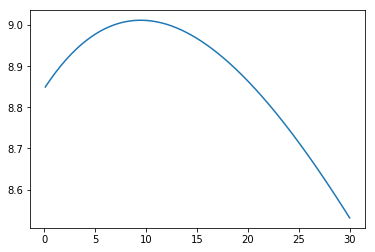

In [119]:
plt.plot(maturities, nss(m = maturities, theta = powell_rand1.values[100]))

### Считаем модуль разности

$$
|P(r_i) - P(r_j)|
$$

In [92]:
hypothetical_bonds_prices = []

for result_name in results_names:
    hypothetical_bonds_prices.append(pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/1.3/' + result_name + '.csv', index_col='TRADEDATE', parse_dates=True))

Первое название в имени файла показывает, от чего отнималась цена другого бонда.

In [94]:
for i in range(len(hypothetical_bonds_prices)):
    for j in range(len(hypothetical_bonds_prices)):
        
        if i == j:
            continue
            
        df = hypothetical_bonds_prices[i] - hypothetical_bonds_prices[j]
        
        df.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/1.3/price_differencies/' + results_names[i] + '_' + results_names[j] + '.csv')

# 2. Forward rates

## 2.1 Maximum absolute rate difference

In [95]:
for q in range(len(results_names)):
    test_df = pd.DataFrame(columns = results_names, data = np.zeros([251, len(results_names)]), index = bonds_prices.index)
    
    for i in range(len(results_names)):
        for j in range(251):
            test_df.iloc[j, i] = max(abs(forward_nss(m = maturities, theta = np.array(results[q])[j]) - forward_nss(m = maturities, theta = np.array(results[i])[j])))
    test_df.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/2.1/abs_diff_' + results_names[q] + '.csv')

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


In [101]:
%%bash
say finished

## 2.2 RMSE

In [97]:
def generate_forward_mse(theta1, theta2):
    
    def gen_forward_mse(m):
        nonlocal theta1, theta2
        
        return (forward_nss(m, theta1) - forward_nss(m, theta2))**2
    
    return gen_forward_mse

In [98]:
%%time

for q in range(len(results_names)):
    test_df = pd.DataFrame(columns = results_names, data = np.zeros([251, len(results_names)]), index = bonds_prices.index)
    
    for i in range(len(results_names)):
        for j in range(251):
            
            mse_integrand = generate_forward_mse(theta1 = results[q].iloc[j].values, theta2 = results[i].iloc[j].values)
            test_df.iloc[j, i] = quad(mse_integrand, 0, 30)[0]
            
    test_df.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/2.2/mse_' + results_names[q] + '.csv')        

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


CPU times: user 6min 56s, sys: 3.32 s, total: 6min 59s
Wall time: 7min 6s


## 3.1 Weighted absolute theta difference

$$
\frac{|\beta_i^{(p)} - \beta_i^{(q)}|}{\sigma_{\beta_i}^q}
$$

$$
p \neq q
$$

Первое название в имени файла показывает, какая волатильность использовалась в формуле.

In [100]:
for i in range(len(results)):
    
    for j in range(len(results)):
        
        if i == j:
            continue
  
        abs_diff_df = abs(results[i] - results[j]) / results[i].std()
        
        abs_diff_df.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/3.1/' + results_names[i] + '_' + results_names[j] + '.csv')        

## 4.1 Loss function difference

$$
F_i - F_j
$$

In [137]:
%%time

loss_function_values_df = pd.DataFrame(data = np.zeros([251, len(results_names)]), columns = results_names, index = dates)

for i in range(len(dates)):
    
    loss_func = build_ss_loss_function(date = dates[i])
    
    for j in range(len(results_names)):
        
        loss_function_values_df.iloc[i, j] = loss_func(results[j].values[i])

CPU times: user 1min 3s, sys: 206 ms, total: 1min 3s
Wall time: 1min 3s


In [138]:
loss_function_values_df.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/4.1/loss_function_values.csv')

In [139]:
for i in range(len(results_names)):
    
    diff_loss_func_df = loss_function_values_df - np.multiply(np.ones([251, len(results_names)]).T, loss_function_values_df.values[:, i]).T
    diff_loss_func_df.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/4.1/' + results_names[i] + '.csv')

In [140]:
%%bash
say finished

## IRR

In [10]:
def npv(irr, cfs, yrs):  
    return np.sum(cfs / (1. + irr) ** yrs)

In [11]:
from scipy.optimize import fsolve

def irr(cfs, yrs, x0):
    return np.asscalar(fsolve(npv, x0=x0, args=(cfs, yrs)))

In [12]:
def maturities_irrs(date_number):
    irrs = []
    maturities = []
    payments_on_date = bonds_payments[bonds_payments['Дата фактической выплаты'] >= dates[date_number]]
    
    for ticker in bonds_payments['Торговый код'].unique():
    
        payments = payments_on_date[payments_on_date['Торговый код'] == ticker]['Сумма купона, RUB'] + payments_on_date[payments_on_date['Торговый код'] == ticker]['Погашение номинала, RUB'].values
        payments_dates = (payments_on_date[payments_on_date['Торговый код'] == ticker]['Дата фактической выплаты'] - dates[date_number]).apply(lambda x: x.days)/365
    
        investment = bonds_prices.iloc[0][ticker]
        payments = np.insert(np.array(payments), 0, -investment)
        payments_dates = np.insert(np.array(payments_dates), 0, 0)
        
        bond_irr = irr(cfs=payments, yrs=payments_dates, x0=0.10)
        
        irrs.append(bond_irr)
        maturities.append(payments_dates[-1])
        
    return (np.array([maturities]), np.array([irrs]))
    

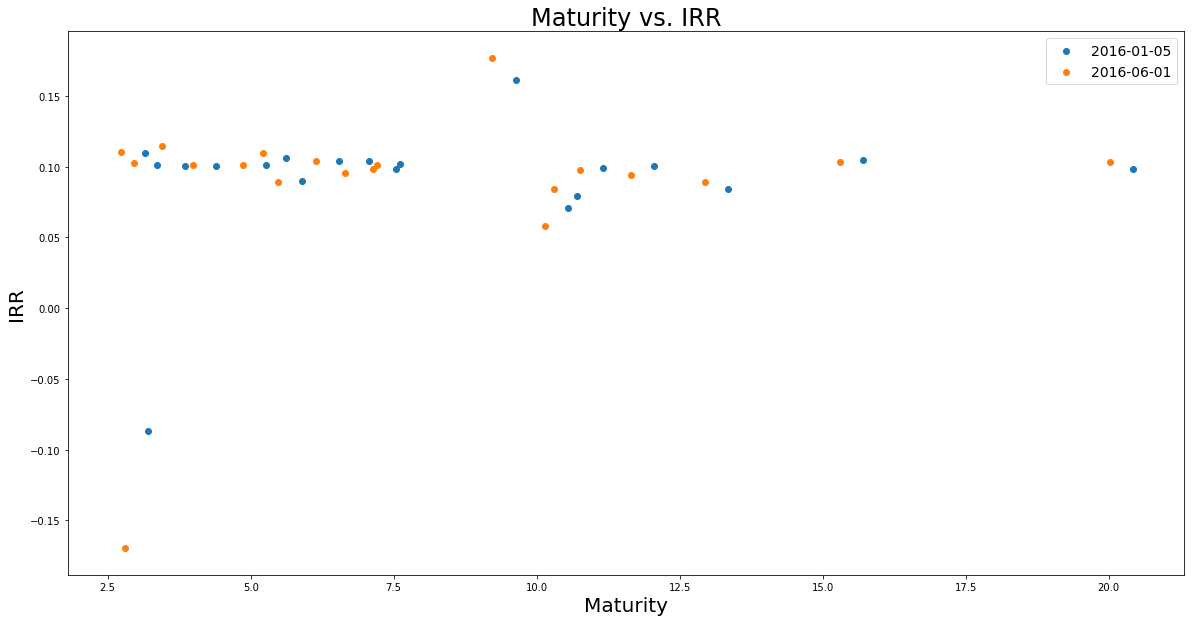

In [73]:
plt.figure(figsize = (20, 10))
plt.scatter(maturites_irrs(0)[0], maturites_irrs(0)[1], label = str(dates[0].date()))
plt.scatter(maturites_irrs(100)[0], maturites_irrs(100)[1], label = str(dates[100].date()))
plt.title('Maturity vs. IRR', fontsize = 24)
plt.xlabel('Maturity', fontsize = 20)
plt.ylabel('IRR', fontsize = 20)
plt.legend(fontsize = 14);

- добавить разумное ограничение на тау (больше нуля и меньше 30)
- беты от -100 до 100 с запасом

automatic differentiation python

## Выводы

In [106]:
results_names = ['bfgs_rand_1', 'bfgs_rand_2', 'bfgs_rand_3', 'bfgs_rand_4', 
                 'bfgs_rand_5', 'bfgs_rand_6', 'bfgs_rand_7', 'bfgs_rand_8', 
                 'nelder_mead_rand_1', 'nelder_mead_rand_2', 'nelder_mead_rand_3', 'nelder_mead_rand_4',
                 'nelder_mead_rand_5', 'nelder_mead_rand_6', 'nelder_mead_rand_7', 'nelder_mead_rand_8',
                 'powell_rand_1', 'powell_rand_2', 'powell_rand_3', 'powell_rand_4',
                 'powell_rand_5', 'powell_rand_6', 'powell_rand_7', 'powell_rand_8',
                 'bfgs_recurrent', 'nelder_mead_recurrent', 'powell_recurrent', 'pso_df']

In [107]:
bfgs_avg_loss = loss_function_values_df[['bfgs_rand_1', 'bfgs_rand_2', 
                                         'bfgs_rand_3', 'bfgs_rand_4',
                                         'bfgs_rand_5', 'bfgs_rand_6', 
                                         'bfgs_rand_7', 'bfgs_rand_8', 'bfgs_recurrent']].sum(axis = 1)/9

In [108]:
nelder_mead_avg_loss = loss_function_values_df[['nelder_mead_rand_1', 'nelder_mead_rand_2', 
                                                'nelder_mead_rand_3', 'nelder_mead_rand_4',
                                                'nelder_mead_rand_5', 'nelder_mead_rand_6', 
                                                'nelder_mead_rand_7', 'nelder_mead_rand_8', 
                                                'nelder_mead_recurrent']].sum(axis = 1)/9

In [109]:
powell_avg_loss = loss_function_values_df[['powell_rand_1', 'powell_rand_2', 
                                           'powell_rand_3', 'powell_rand_4', 
                                           'powell_rand_5', 'powell_rand_6', 
                                           'powell_rand_7', 'powell_rand_8', 
                                           'powell_recurrent']].sum(axis = 1)/9

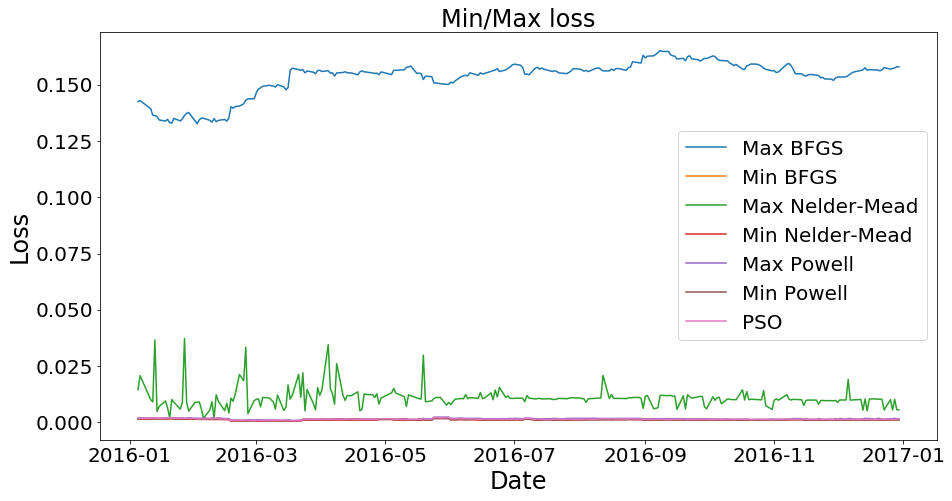

In [193]:
plt.figure(figsize = (15,7.5))
plt.plot(loss_function_values_df[['bfgs_rand_1', 'bfgs_rand_2',
                                  'bfgs_rand_3', 'bfgs_rand_4',
                                  'bfgs_rand_5', 'bfgs_rand_6',
                                  'bfgs_rand_7', 'bfgs_rand_8', 'bfgs_recurrent']].max(axis=1), label = 'Max BFGS')
plt.plot(loss_function_values_df[['bfgs_rand_1', 'bfgs_rand_2',
                                  'bfgs_rand_3', 'bfgs_rand_4',
                                  'bfgs_rand_5', 'bfgs_rand_6',
                                  'bfgs_rand_7', 'bfgs_rand_8', 'bfgs_recurrent']].min(axis=1), label = 'Min BFGS')

plt.plot(loss_function_values_df[['nelder_mead_rand_1', 'nelder_mead_rand_2',
                                  'nelder_mead_rand_3', 'nelder_mead_rand_4',
                                  'nelder_mead_rand_5', 'nelder_mead_rand_6',
                                  'nelder_mead_rand_7', 'nelder_mead_rand_8', 
                                  'nelder_mead_recurrent']].max(axis = 1), label = 'Max Nelder-Mead')
plt.plot(loss_function_values_df[['nelder_mead_rand_1', 'nelder_mead_rand_2',
                                  'nelder_mead_rand_3', 'nelder_mead_rand_4',
                                  'nelder_mead_rand_5', 'nelder_mead_rand_6',
                                  'nelder_mead_rand_7', 'nelder_mead_rand_8', 
                                  'nelder_mead_recurrent']].min(axis = 1), label = 'Min Nelder-Mead')
         
plt.plot(loss_function_values_df[['powell_rand_1', 'powell_rand_2',
                                  'powell_rand_3', 'powell_rand_4',
                                  'powell_rand_5', 'powell_rand_6',
                                  'powell_rand_7', 'powell_rand_8',
                                  'powell_recurrent']].max(axis = 1), label = 'Max Powell')
plt.plot(loss_function_values_df[['powell_rand_1', 'powell_rand_2',
                                  'powell_rand_3', 'powell_rand_4',
                                  'powell_rand_5', 'powell_rand_6',
                                  'powell_rand_7', 'powell_rand_8',
                                  'powell_recurrent']].min(axis = 1), label = 'Min Powell')
plt.plot(loss_function_values_df['pso_df'], label = 'PSO')
plt.xlabel('Date', fontsize = 24)
plt.ylabel('Loss', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.title('Min/Max loss', fontsize = 24);

BFGS Volatility

In [239]:
pd.concat([hypothetical_bonds_prices[0]['short'], 
           hypothetical_bonds_prices[1]['short'], 
           hypothetical_bonds_prices[2]['short'], 
           hypothetical_bonds_prices[3]['short'], 
           hypothetical_bonds_prices[4]['short'], 
           hypothetical_bonds_prices[5]['short'], 
           hypothetical_bonds_prices[6]['short'], 
           hypothetical_bonds_prices[7]['short'], 
           hypothetical_bonds_prices[-4]['short'], 
           hypothetical_bonds_prices[-1]['short']]).std()

42.217336491490066

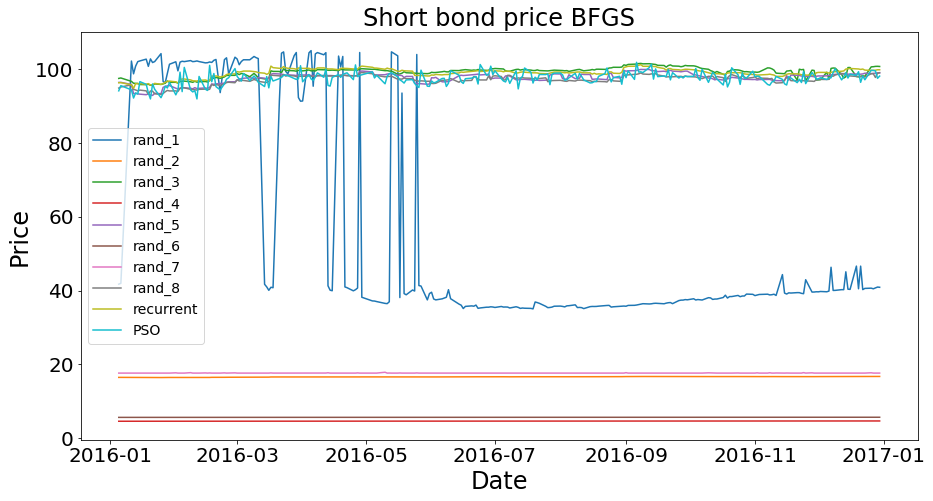

In [198]:
plt.figure(figsize = (15,7.5))
plt.title('Short bond price BFGS', fontsize = 24)
plt.plot(hypothetical_bonds_prices[0]['short'], label = 'rand_1')
plt.plot(hypothetical_bonds_prices[1]['short'], label = 'rand_2')
plt.plot(hypothetical_bonds_prices[2]['short'], label = 'rand_3')
plt.plot(hypothetical_bonds_prices[3]['short'], label = 'rand_4')
plt.plot(hypothetical_bonds_prices[4]['short'], label = 'rand_5')
plt.plot(hypothetical_bonds_prices[5]['short'], label = 'rand_6')
plt.plot(hypothetical_bonds_prices[6]['short'], label = 'rand_7')
plt.plot(hypothetical_bonds_prices[7]['short'], label = 'rand_8')
plt.plot(hypothetical_bonds_prices[-4]['short'], label = 'recurrent')
plt.plot(hypothetical_bonds_prices[-1]['short'], label = 'PSO')
plt.xlabel('Date', fontsize = 24)
plt.ylabel('Price', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 14);

Nelder-Mead Volatility

In [237]:
pd.concat([hypothetical_bonds_prices[8]['short'], 
           hypothetical_bonds_prices[9]['short'], 
           hypothetical_bonds_prices[10]['short'], 
           hypothetical_bonds_prices[11]['short'], 
           hypothetical_bonds_prices[12]['short'], 
           hypothetical_bonds_prices[13]['short'], 
           hypothetical_bonds_prices[14]['short'], 
           hypothetical_bonds_prices[15]['short'], 
           hypothetical_bonds_prices[-3]['short'], 
           hypothetical_bonds_prices[-1]['short']]).std()

8.399529515219967

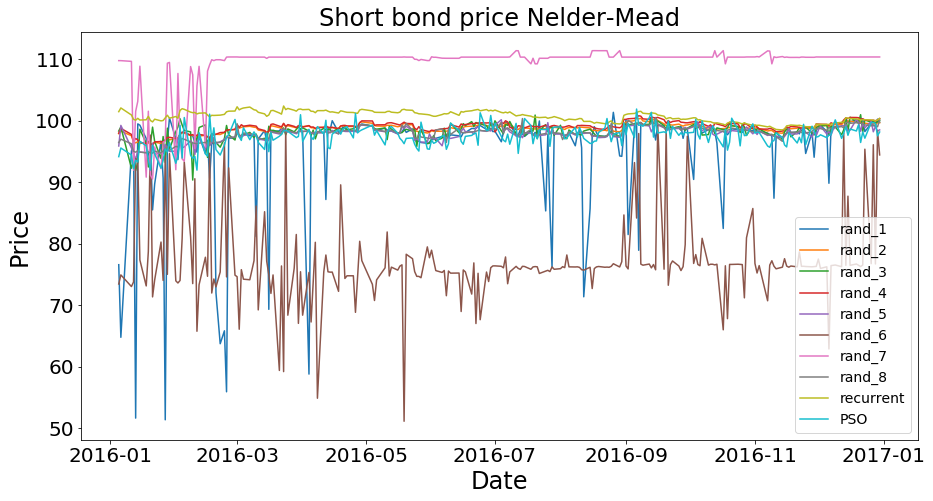

In [197]:
plt.figure(figsize = (15,7.5))
plt.title('Short bond price Nelder-Mead', fontsize = 24)
plt.plot(hypothetical_bonds_prices[8]['short'], label = 'rand_1')
plt.plot(hypothetical_bonds_prices[9]['short'], label = 'rand_2')
plt.plot(hypothetical_bonds_prices[10]['short'], label = 'rand_3')
plt.plot(hypothetical_bonds_prices[11]['short'], label = 'rand_4')
plt.plot(hypothetical_bonds_prices[12]['short'], label = 'rand_5')
plt.plot(hypothetical_bonds_prices[13]['short'], label = 'rand_6')
plt.plot(hypothetical_bonds_prices[14]['short'], label = 'rand_7')
plt.plot(hypothetical_bonds_prices[15]['short'], label = 'rand_8')
plt.plot(hypothetical_bonds_prices[-3]['short'], label = 'recurrent')
plt.plot(hypothetical_bonds_prices[-1]['short'], label = 'PSO')
plt.xlabel('Date', fontsize = 24)
plt.ylabel('Price', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 14);

Powell Volatility

In [236]:
pd.concat([hypothetical_bonds_prices[16]['short'], 
           hypothetical_bonds_prices[17]['short'],
           hypothetical_bonds_prices[18]['short'],
           hypothetical_bonds_prices[19]['short'],
           hypothetical_bonds_prices[20]['short'],
           hypothetical_bonds_prices[21]['short'],
           hypothetical_bonds_prices[22]['short'],
           hypothetical_bonds_prices[23]['short'],
           hypothetical_bonds_prices[-2]['short'],
           hypothetical_bonds_prices[-1]['short']]).std()

2.041559942378288

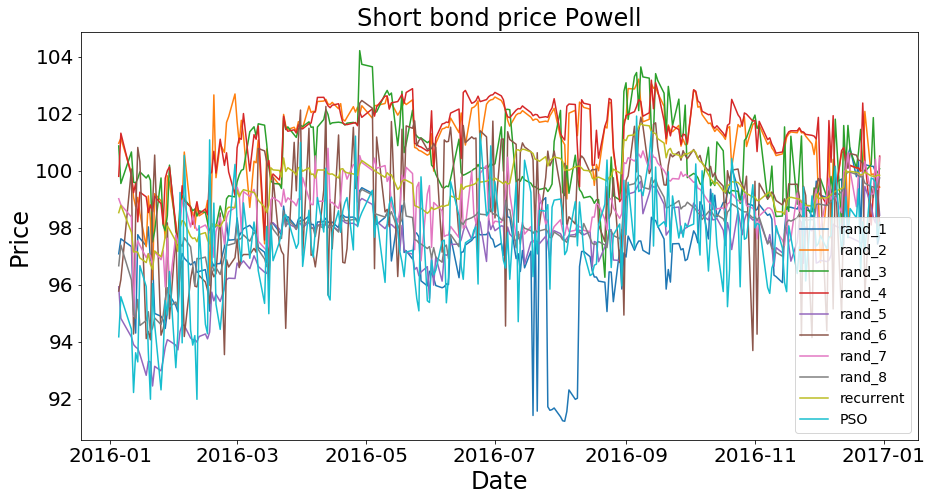

In [215]:
plt.figure(figsize = (15,7.5))
plt.title('Short bond price Powell', fontsize = 24)
plt.plot(hypothetical_bonds_prices[16]['short'], label = 'rand_1')
plt.plot(hypothetical_bonds_prices[17]['short'], label = 'rand_2')
plt.plot(hypothetical_bonds_prices[18]['short'], label = 'rand_3')
plt.plot(hypothetical_bonds_prices[19]['short'], label = 'rand_4')
plt.plot(hypothetical_bonds_prices[20]['short'], label = 'rand_5')
plt.plot(hypothetical_bonds_prices[21]['short'], label = 'rand_6')
plt.plot(hypothetical_bonds_prices[22]['short'], label = 'rand_7')
plt.plot(hypothetical_bonds_prices[23]['short'], label = 'rand_8')
plt.plot(hypothetical_bonds_prices[-2]['short'], label = 'recurrent')
plt.plot(hypothetical_bonds_prices[-1]['short'], label = 'PSO')
plt.xlabel('Date', fontsize = 24)
plt.ylabel('Price', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 14);

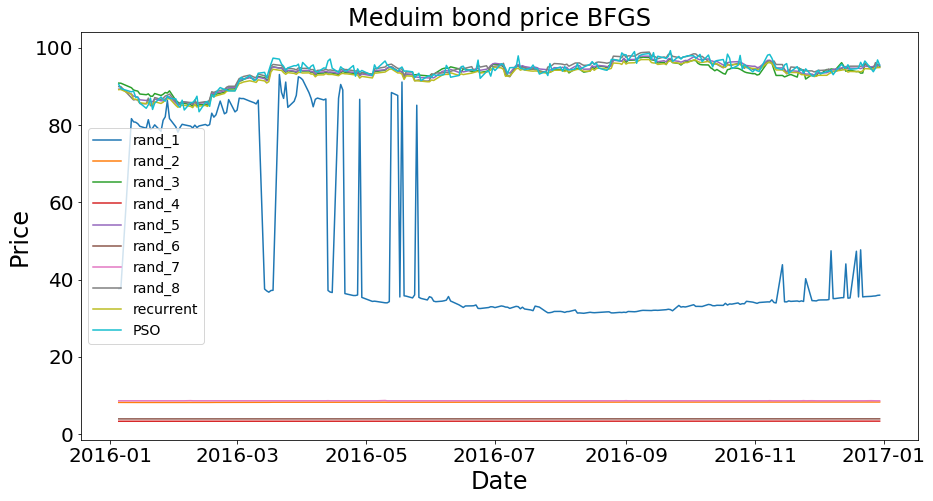

In [213]:
plt.figure(figsize = (15,7.5))
plt.title('Meduim bond price BFGS', fontsize = 24)
plt.plot(hypothetical_bonds_prices[0]['medium'], label = 'rand_1')
plt.plot(hypothetical_bonds_prices[1]['medium'], label = 'rand_2')
plt.plot(hypothetical_bonds_prices[2]['medium'], label = 'rand_3')
plt.plot(hypothetical_bonds_prices[3]['medium'], label = 'rand_4')
plt.plot(hypothetical_bonds_prices[4]['medium'], label = 'rand_5')
plt.plot(hypothetical_bonds_prices[5]['medium'], label = 'rand_6')
plt.plot(hypothetical_bonds_prices[6]['medium'], label = 'rand_7')
plt.plot(hypothetical_bonds_prices[7]['medium'], label = 'rand_8')
plt.plot(hypothetical_bonds_prices[-4]['medium'], label = 'recurrent')
plt.plot(hypothetical_bonds_prices[-1]['medium'], label = 'PSO')
plt.xlabel('Date', fontsize = 24)
plt.ylabel('Price', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 14);

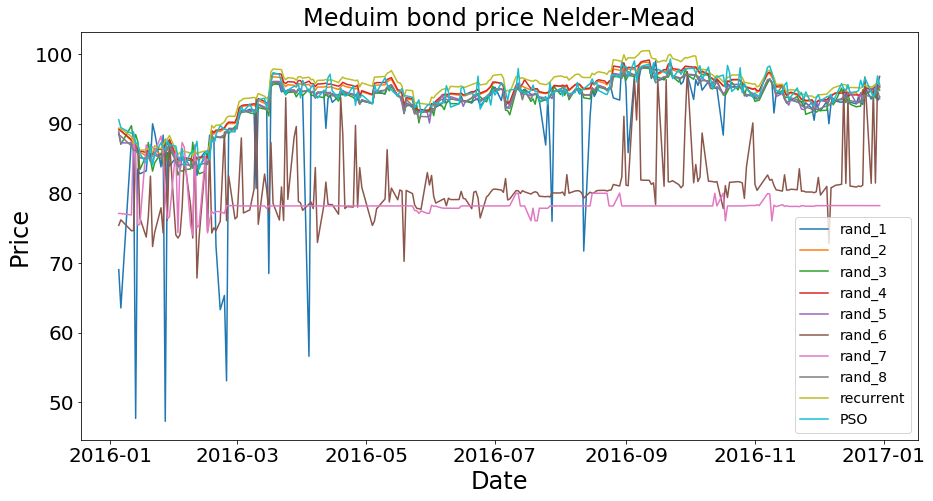

In [212]:
plt.figure(figsize = (15,7.5))
plt.title('Meduim bond price Nelder-Mead', fontsize = 24)
plt.plot(hypothetical_bonds_prices[8]['medium'], label = 'rand_1')
plt.plot(hypothetical_bonds_prices[9]['medium'], label = 'rand_2')
plt.plot(hypothetical_bonds_prices[10]['medium'], label = 'rand_3')
plt.plot(hypothetical_bonds_prices[11]['medium'], label = 'rand_4')
plt.plot(hypothetical_bonds_prices[12]['medium'], label = 'rand_5')
plt.plot(hypothetical_bonds_prices[13]['medium'], label = 'rand_6')
plt.plot(hypothetical_bonds_prices[14]['medium'], label = 'rand_7')
plt.plot(hypothetical_bonds_prices[15]['medium'], label = 'rand_8')
plt.plot(hypothetical_bonds_prices[-3]['medium'], label = 'recurrent')
plt.plot(hypothetical_bonds_prices[-1]['medium'], label = 'PSO')
plt.xlabel('Date', fontsize = 24)
plt.ylabel('Price', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 14);

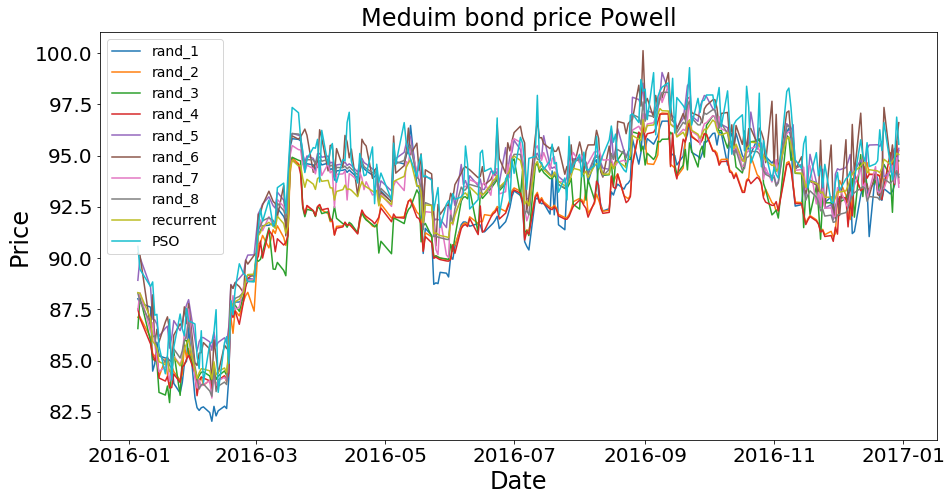

In [211]:
plt.figure(figsize = (15,7.5))
plt.title('Meduim bond price Powell', fontsize = 24)
plt.plot(hypothetical_bonds_prices[16]['medium'], label = 'rand_1')
plt.plot(hypothetical_bonds_prices[17]['medium'], label = 'rand_2')
plt.plot(hypothetical_bonds_prices[18]['medium'], label = 'rand_3')
plt.plot(hypothetical_bonds_prices[19]['medium'], label = 'rand_4')
plt.plot(hypothetical_bonds_prices[20]['medium'], label = 'rand_5')
plt.plot(hypothetical_bonds_prices[21]['medium'], label = 'rand_6')
plt.plot(hypothetical_bonds_prices[22]['medium'], label = 'rand_7')
plt.plot(hypothetical_bonds_prices[23]['medium'], label = 'rand_8')
plt.plot(hypothetical_bonds_prices[-2]['medium'], label = 'recurrent')
plt.plot(hypothetical_bonds_prices[-1]['medium'], label = 'PSO')
plt.xlabel('Date', fontsize = 24)
plt.ylabel('Price', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 14);

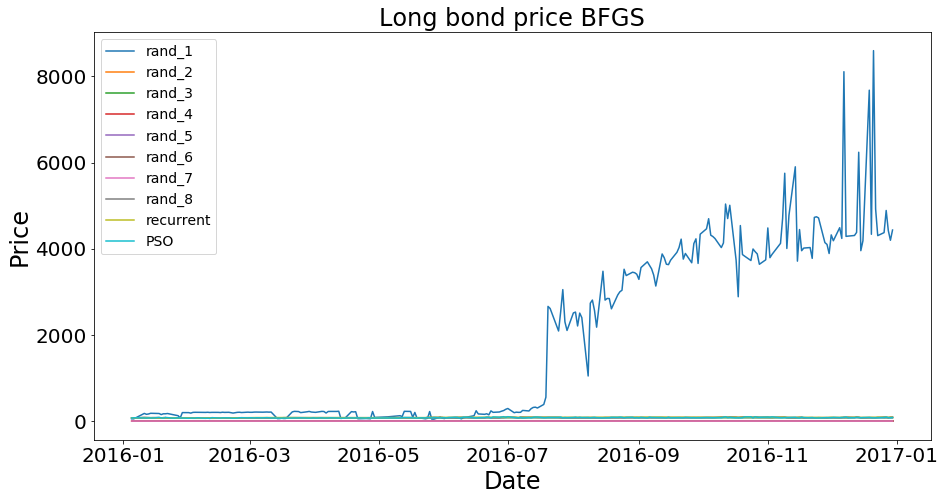

In [210]:
plt.figure(figsize = (15,7.5))
plt.title('Long bond price BFGS', fontsize = 24)
plt.plot(hypothetical_bonds_prices[0]['long'], label = 'rand_1')
plt.plot(hypothetical_bonds_prices[1]['long'], label = 'rand_2')
plt.plot(hypothetical_bonds_prices[2]['long'], label = 'rand_3')
plt.plot(hypothetical_bonds_prices[3]['long'], label = 'rand_4')
plt.plot(hypothetical_bonds_prices[4]['long'], label = 'rand_5')
plt.plot(hypothetical_bonds_prices[5]['long'], label = 'rand_6')
plt.plot(hypothetical_bonds_prices[6]['long'], label = 'rand_7')
plt.plot(hypothetical_bonds_prices[7]['long'], label = 'rand_8')
plt.plot(hypothetical_bonds_prices[-4]['long'], label = 'recurrent')
plt.plot(hypothetical_bonds_prices[-1]['long'], label = 'PSO')
plt.xlabel('Date', fontsize = 24)
plt.ylabel('Price', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 14);

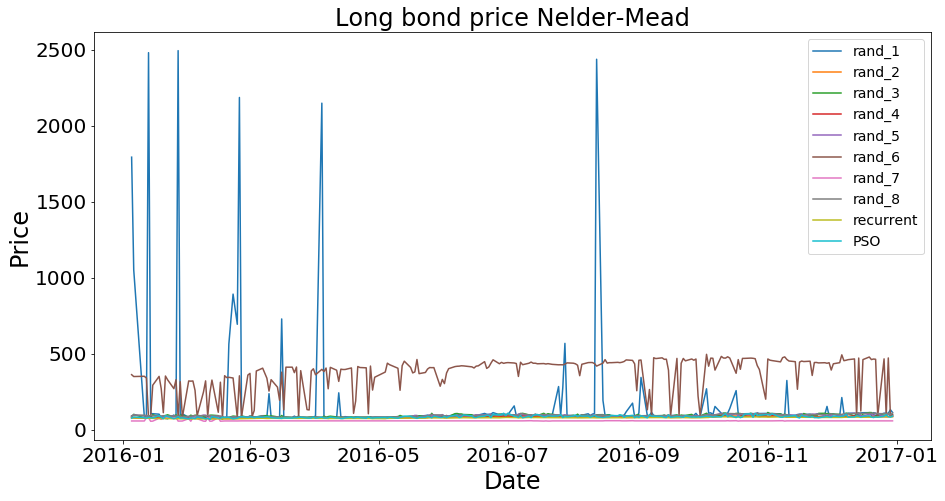

In [209]:
plt.figure(figsize = (15,7.5))
plt.title('Long bond price Nelder-Mead', fontsize = 24)
plt.plot(hypothetical_bonds_prices[8]['long'], label = 'rand_1')
plt.plot(hypothetical_bonds_prices[9]['long'], label = 'rand_2')
plt.plot(hypothetical_bonds_prices[10]['long'], label = 'rand_3')
plt.plot(hypothetical_bonds_prices[11]['long'], label = 'rand_4')
plt.plot(hypothetical_bonds_prices[12]['long'], label = 'rand_5')
plt.plot(hypothetical_bonds_prices[13]['long'], label = 'rand_6')
plt.plot(hypothetical_bonds_prices[14]['long'], label = 'rand_7')
plt.plot(hypothetical_bonds_prices[15]['long'], label = 'rand_8')
plt.plot(hypothetical_bonds_prices[-3]['long'], label = 'recurrent')
plt.plot(hypothetical_bonds_prices[-1]['long'], label = 'PSO')
plt.xlabel('Date', fontsize = 24)
plt.ylabel('Price', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 14);

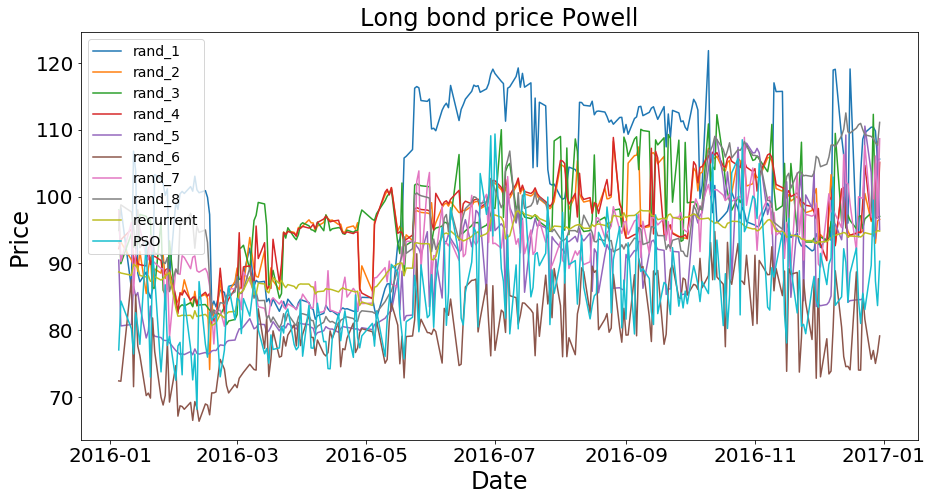

In [208]:
plt.figure(figsize = (15,7.5))
plt.title('Long bond price Powell', fontsize = 24)
plt.plot(hypothetical_bonds_prices[16]['long'], label = 'rand_1')
plt.plot(hypothetical_bonds_prices[17]['long'], label = 'rand_2')
plt.plot(hypothetical_bonds_prices[18]['long'], label = 'rand_3')
plt.plot(hypothetical_bonds_prices[19]['long'], label = 'rand_4')
plt.plot(hypothetical_bonds_prices[20]['long'], label = 'rand_5')
plt.plot(hypothetical_bonds_prices[21]['long'], label = 'rand_6')
plt.plot(hypothetical_bonds_prices[22]['long'], label = 'rand_7')
plt.plot(hypothetical_bonds_prices[23]['long'], label = 'rand_8')
plt.plot(hypothetical_bonds_prices[-2]['long'], label = 'recurrent')
plt.plot(hypothetical_bonds_prices[-1]['long'], label = 'PSO')
plt.xlabel('Date', fontsize = 24)
plt.ylabel('Price', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 14);

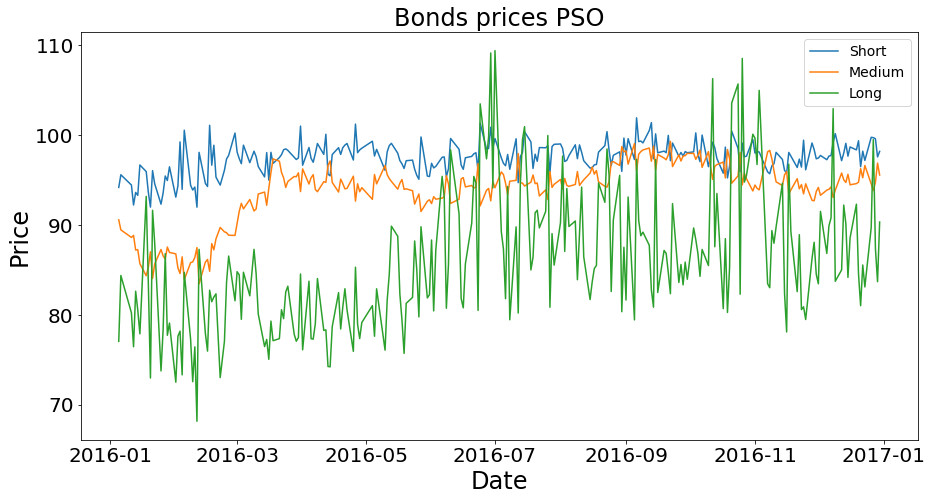

In [207]:
plt.figure(figsize = (15,7.5))
plt.title('Bonds prices PSO', fontsize = 24)
plt.plot(hypothetical_bonds_prices[-1]['short'], label = 'Short')
plt.plot(hypothetical_bonds_prices[-1]['medium'], label = 'Medium')
plt.plot(hypothetical_bonds_prices[-1]['long'], label = 'Long')
plt.xlabel('Date', fontsize = 24)
plt.ylabel('Price', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 14);

## Thetas plot

In [175]:
results_names

['bfgs_rand_1',
 'bfgs_rand_2',
 'bfgs_rand_3',
 'bfgs_rand_4',
 'bfgs_rand_5',
 'bfgs_rand_6',
 'bfgs_rand_7',
 'bfgs_rand_8',
 'nelder_mead_rand_1',
 'nelder_mead_rand_2',
 'nelder_mead_rand_3',
 'nelder_mead_rand_4',
 'nelder_mead_rand_5',
 'nelder_mead_rand_6',
 'nelder_mead_rand_7',
 'nelder_mead_rand_8',
 'powell_rand_1',
 'powell_rand_2',
 'powell_rand_3',
 'powell_rand_4',
 'powell_rand_5',
 'powell_rand_6',
 'powell_rand_7',
 'powell_rand_8',
 'bfgs_recurrent',
 'nelder_mead_recurrent',
 'powell_recurrent',
 'pso_df']

In [178]:
bfgs_tau1 = pd.concat([results[0].tau1, results[1].tau1,results[2].tau1, results[3].tau1,
                       results[4].tau1, results[4].tau1,results[6].tau1, results[7].tau1,
                       results[-4].tau1], axis = 1)

In [179]:
bfgs_tau1.columns = ['bfgs_rand_1', 'bfgs_rand_2', 'bfgs_rand_3', 'bfgs_rand_4', 
                     'bfgs_rand_5', 'bfgs_rand_6', 'bfgs_rand_7', 'bfgs_rand_8', 
                     'bfgs_recurrent']

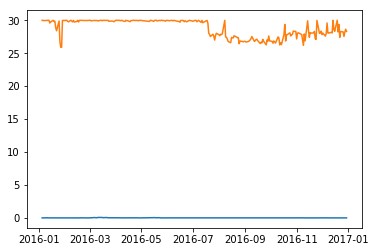

In [183]:
plt.plot(bfgs_tau1.min(axis = 1))
plt.plot(bfgs_tau1.max(axis = 1));

In [171]:
pd.concat(results[0])

tau1       tau2         beta0      beta1      beta2  \
TRADEDATE                                                              
2016-01-05  29.998835   4.563212  5.509968e-01  64.950852 -85.903446   
2016-01-06  29.946600   4.493806  6.382024e-01  64.819776 -85.909016   
2016-01-11  29.972511   1.163767  8.024182e-01  35.021143 -70.791949   
2016-01-12  29.999444   1.374149  9.197953e-01  37.205008 -71.928925   
2016-01-13  29.997023   1.240996  9.875662e-01  35.856186 -71.257059   
2016-01-14  29.577871   1.071580  1.040247e+00  34.196557 -70.351398   
2016-01-15  29.730739   1.008776  1.138311e+00  33.547016 -70.051064   
2016-01-18  29.998133   0.930451  1.559129e+00  32.337326 -69.556585   
2016-01-19  29.801851   0.705177  2.779435e+00  24.580192 -55.080303   
2016-01-20  29.853123   0.948842  2.012683e+00  32.227334 -69.680253   
2016-01-21  28.895724   1.051728  2.315321e+00  33.244153 -70.251710   
2016-01-22  28.400888   1.048602  2.647869e+00  32.813076 -70.133580   
2016-01-25  29.886180   0.882625  5.230417e+00  28.373732 -69.756407   
2016-01-26  26.709437   1.486934  7.782394e+00  32.427563 -74.034277   
2016-01-27  25.306324   1.523088  1.147328e+01  29.306522 -75.103674   
2016-01-28  13.617669   0.385742  2.450866e+01  -3.293045 -40.663741   
2016-01-29  29.973578   1.217637  1.968539e-03  37.325891 -74.450713   
2016-02-01  29.965478   1.038972  3.731324e-02  35.712663 -72.757370   
2016-02-02  29.981319   1.179874  9.006681e-03  37.798630 -75.185649   
2016-02-03  29.997381   1.014820  7.536207e-02  35.509706 -73.287113   
2016-02-04  29.839341   1.043105  7.089959e-02  35.632455 -73.066074   
2016-02-05  29.756278   1.038831  1.587293e-01  35.534328 -72.974303   
2016-02-08  29.998624   0.998757  9.310247e-02  35.105371 -72.340691   
2016-02-09  29.878240   0.963575  1.696961e-01  34.740847 -72.066729   
2016-02-10  29.750751   1.015648  6.240300e-03  35.386388 -72.435438   
2016-02-11  29.975239   0.976763  2.509813e-01  34.809127 -72.372792   
2016-02-12  29.726365   1.000804  8.345811e-02  35.119728 -72.011783   
2016-02-15  29.819530   1.081557  3.755151e-03  36.146433 -73.461517   
2016-02-16  29.988797   1.078572  4.864006e-03  36.145633 -73.459573   
2016-02-17  29.740019   1.041805  1.385665e-01  35.589717 -73.185129   
2016-02-18  29.979531   1.236919  2.844115e-03  37.118441 -74.134966   
2016-02-19  29.973650   1.148008  2.962359e-03  36.369204 -73.488647   
2016-02-20  29.989843   1.162360  3.192661e-03  36.371936 -73.421909   
2016-02-22  29.972314   1.740248  2.750417e-03  41.232532 -76.735417   
2016-02-24  29.949318   1.178267  5.646718e-02  36.403113 -73.328190   
2016-02-25  29.965671   1.159353  1.363864e-01  36.045314 -73.171903   
2016-02-26  29.954280   1.515923  1.484983e-01  39.024961 -75.573412   
2016-02-29  29.970989   1.144895  2.967641e-03  35.888358 -72.705346   
2016-03-01  29.993472   1.207375  2.898590e-03  36.443597 -73.051648   
2016-03-02  29.989209   1.404746  9.501859e-03  37.786325 -73.915958   
2016-03-03  29.885747   1.349572  1.854759e-02  37.248752 -73.500647   
2016-03-04  29.935285   1.326129  2.731114e-02  36.979990 -73.318725   
2016-03-07  29.964865   1.305935  5.248665e-02  36.847267 -73.181730   
2016-03-09  29.947637   1.232465  6.508187e-02  36.139333 -72.703269   
2016-03-10  29.972360   1.243302  7.294451e-02  36.298446 -72.799964   
2016-03-11  29.886680   1.287154  8.065113e-02  36.537035 -72.892084   
2016-03-14  29.992986   4.343622  2.607224e-01  66.337070 -91.623325   
2016-03-15  29.987620   4.487174  2.789627e-01  66.657078 -91.748100   
2016-03-16  29.915271   4.756819  2.976558e-01  66.947022 -91.855177   
2016-03-17  29.993189   4.551743  3.127394e-01  66.544948 -91.493562   
2016-03-18  29.982478   4.610227  3.287062e-01  66.497188 -91.374115   
2016-03-21  29.971849   1.981229  3.047046e-03  42.046275 -77.942234   
2016-03-22  29.985184   1.281296  2.591027e-03  36.478084 -73.747038   
2016-03-23  29.988133   1.200299  2.346919e-03  35.928831

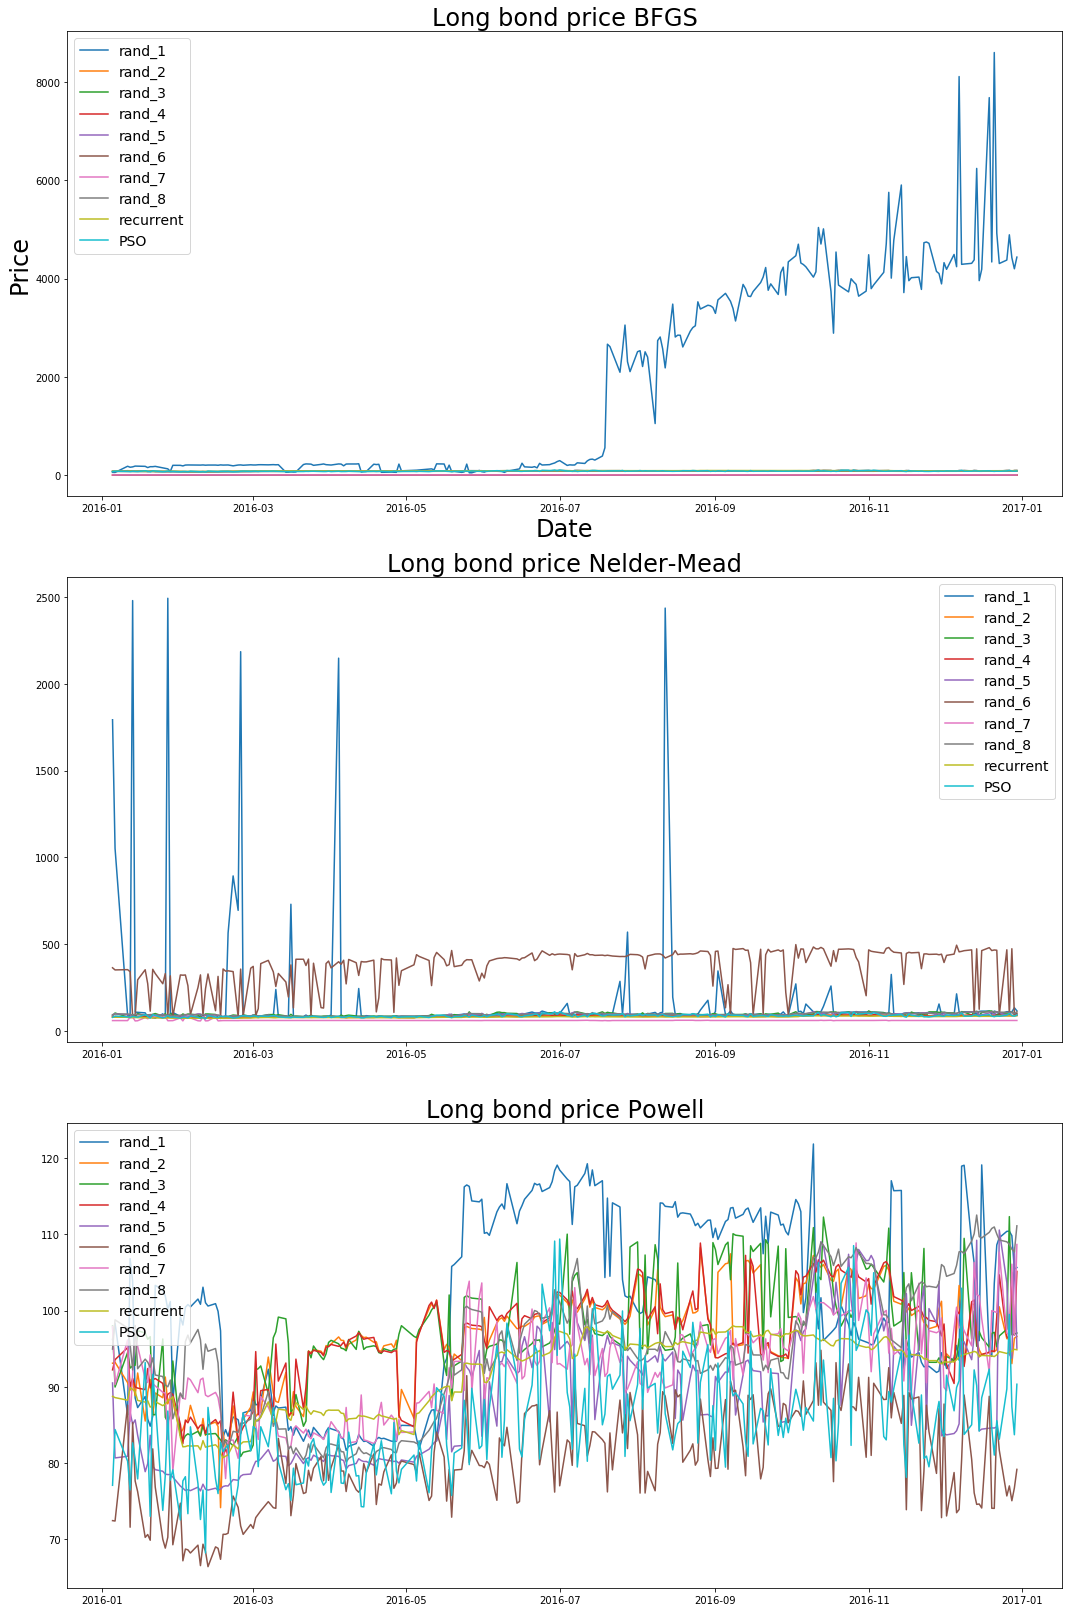

In [234]:
import matplotlib.pyplot as plt
python_course_green = "#476042"
fig = plt.figure(figsize = (15,22.5))
sub1 = plt.subplot(3, 1, 1)
sub1.set_title('Long bond price BFGS', fontsize = 24)
sub1.plot(hypothetical_bonds_prices[0]['long'], label = 'rand_1')
sub1.plot(hypothetical_bonds_prices[1]['long'], label = 'rand_2')
sub1.plot(hypothetical_bonds_prices[2]['long'], label = 'rand_3')
sub1.plot(hypothetical_bonds_prices[3]['long'], label = 'rand_4')
sub1.plot(hypothetical_bonds_prices[4]['long'], label = 'rand_5')
sub1.plot(hypothetical_bonds_prices[5]['long'], label = 'rand_6')
sub1.plot(hypothetical_bonds_prices[6]['long'], label = 'rand_7')
sub1.plot(hypothetical_bonds_prices[7]['long'], label = 'rand_8')
sub1.plot(hypothetical_bonds_prices[-4]['long'], label = 'recurrent')
sub1.plot(hypothetical_bonds_prices[-1]['long'], label = 'PSO')
sub1.set_xlabel('Date', fontsize = 24)
sub1.set_ylabel('Price', fontsize = 24)
#sub1.set_xticks(fontsize = 20)
#sub1.set_yticks(fontsize = 20)
plt.legend(fontsize = 14);
sub2 = plt.subplot(3, 1, 2)
sub2.set_title('Long bond price Nelder-Mead', fontsize = 24)
sub2.plot(hypothetical_bonds_prices[8]['long'], label = 'rand_1')
sub2.plot(hypothetical_bonds_prices[9]['long'], label = 'rand_2')
sub2.plot(hypothetical_bonds_prices[10]['long'], label = 'rand_3')
sub2.plot(hypothetical_bonds_prices[11]['long'], label = 'rand_4')
sub2.plot(hypothetical_bonds_prices[12]['long'], label = 'rand_5')
sub2.plot(hypothetical_bonds_prices[13]['long'], label = 'rand_6')
sub2.plot(hypothetical_bonds_prices[14]['long'], label = 'rand_7')
sub2.plot(hypothetical_bonds_prices[15]['long'], label = 'rand_8')
sub2.plot(hypothetical_bonds_prices[-3]['long'], label = 'recurrent')
sub2.plot(hypothetical_bonds_prices[-1]['long'], label = 'PSO')
#plt.xlabel('Date', fontsize = 24)
#plt.ylabel('Price', fontsize = 24)
#plt.xticks(fontsize = 20)
#plt.yticks(fontsize = 20)
sub2.legend(fontsize = 14);
sub3 = plt.subplot(3, 1, 3)
sub3.set_title('Long bond price Powell', fontsize = 24)
sub3.plot(hypothetical_bonds_prices[16]['long'], label = 'rand_1')
sub3.plot(hypothetical_bonds_prices[17]['long'], label = 'rand_2')
sub3.plot(hypothetical_bonds_prices[18]['long'], label = 'rand_3')
sub3.plot(hypothetical_bonds_prices[19]['long'], label = 'rand_4')
sub3.plot(hypothetical_bonds_prices[20]['long'], label = 'rand_5')
sub3.plot(hypothetical_bonds_prices[21]['long'], label = 'rand_6')
sub3.plot(hypothetical_bonds_prices[22]['long'], label = 'rand_7')
sub3.plot(hypothetical_bonds_prices[23]['long'], label = 'rand_8')
sub3.plot(hypothetical_bonds_prices[-2]['long'], label = 'recurrent')
sub3.plot(hypothetical_bonds_prices[-1]['long'], label = 'PSO')
#sub3.xlabel('Date', fontsize = 24)
#sub3.ylabel('Price', fontsize = 24)
#sub3.xticks(fontsize = 20)
#sub3.yticks(fontsize = 20)
sub3.legend(fontsize = 14);
fig.tight_layout()
plt.show()

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


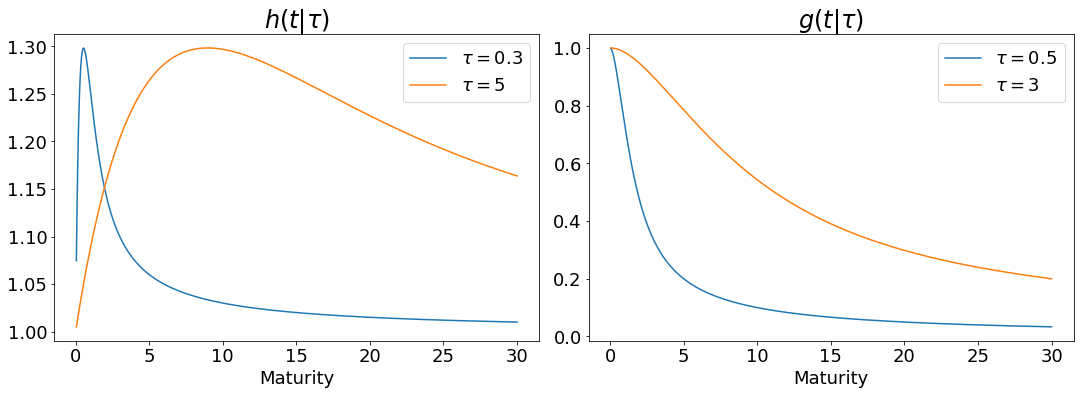

In [35]:
maturities =  np.linspace(0, 30, 601)

fig = plt.figure(figsize = (15,10))
sub1 = plt.subplot(2, 2, 1)

sub1.plot(maturities, nss(m = maturities, theta = np.array([0.3, 0, 1, 0, 1, 0, 0])), label = r'$\tau = 0.3$')
sub1.plot(maturities, nss(m = maturities, theta = np.array([5, 0, 1, 0, 1, 0, 0])), label = r'$\tau = 5$')
sub1.legend(fontsize = 18)
sub1.set_title(r'$h(t|\tau)$', fontsize = 24)
sub1.tick_params(axis='both', labelsize=18)
sub1.set_xlabel('Maturity', fontsize = 18)
sub2 = plt.subplot(2, 2, 2)
sub2.plot(maturities, nss(m = maturities, theta = np.array([0.5, 0, 0, 1, 1, 0, 0])), label = r'$\tau = 0.5$')
sub2.plot(maturities, nss(m = maturities, theta = np.array([3, 0, 0, 1, 1, 0, 0])), label = r'$\tau = 3$')
sub2.legend(fontsize = 18)
sub2.set_title(r'$g(t|\tau)$', fontsize = 24)
sub2.tick_params(axis='both', labelsize=18)
sub2.set_xlabel('Maturity', fontsize = 18)
fig.tight_layout()
plt.savefig('h_and_g.png')
plt.show();

In [18]:
from mpl_toolkits import mplot3d

In [100]:
results_names[-2]

'powell_recurrent'

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


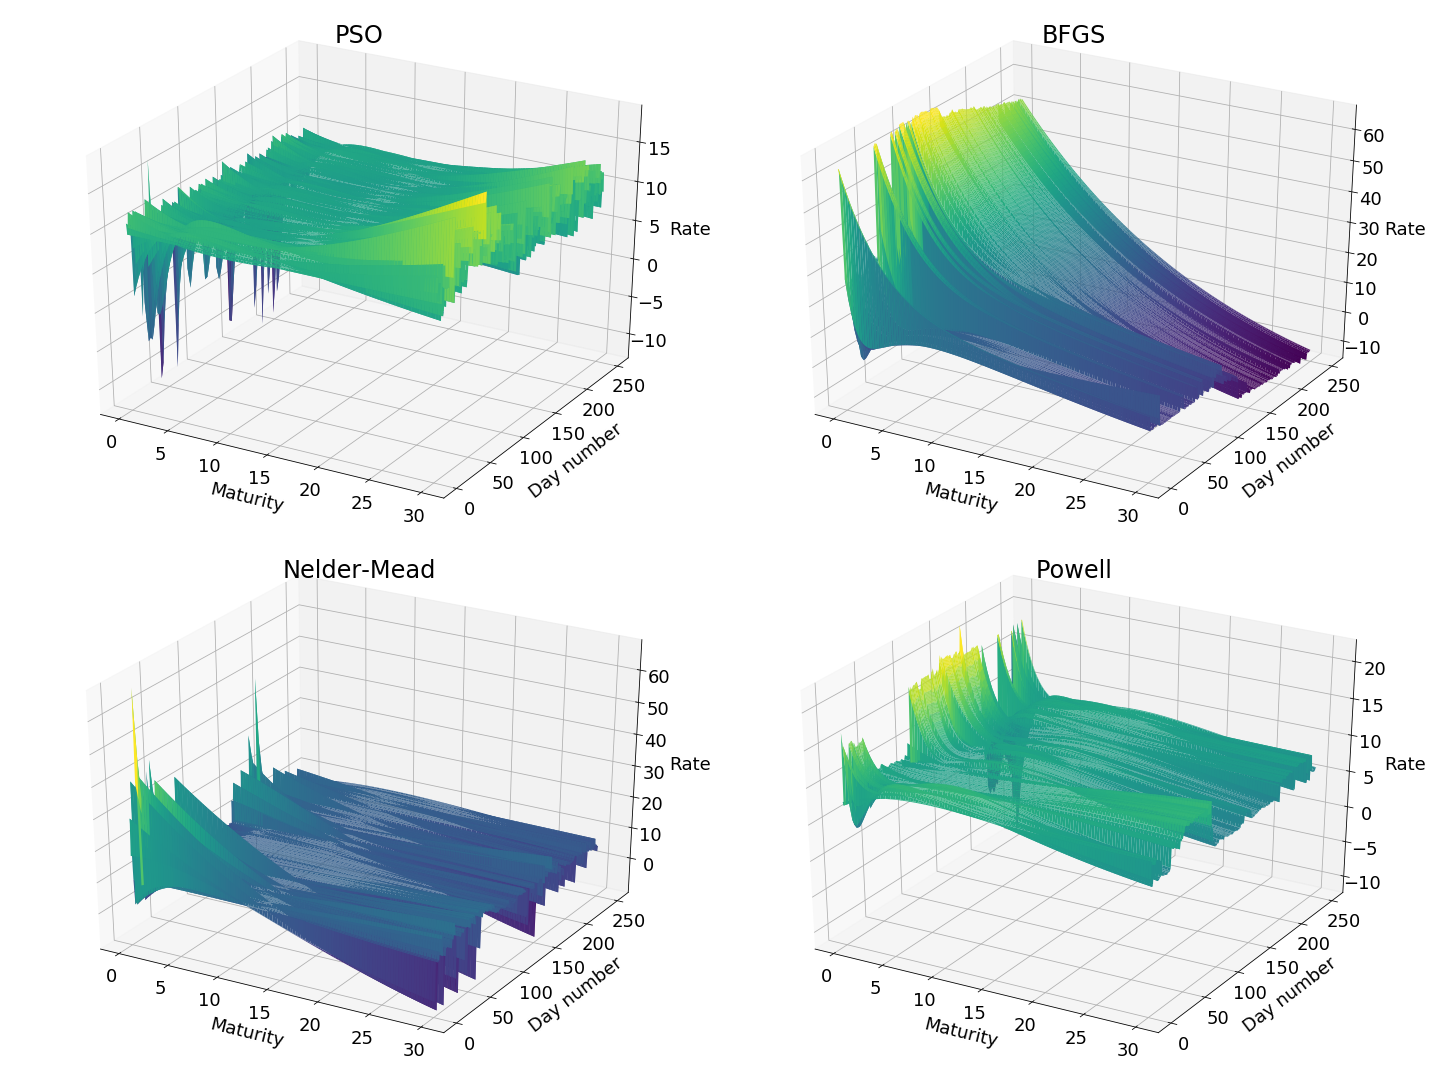

CPU times: user 31.5 s, sys: 973 ms, total: 32.5 s
Wall time: 32.4 s


In [108]:
%%time
fig = plt.figure(figsize = (20,15))

m = [np.linspace(0, 30, 121)[1:] for i in range(251)]
m = np.array(m).T
d = [np.arange(251) for i in range(120)]
d = np.array(d)

sub1 = plt.subplot(2, 2, 1, projection='3d')
z1 = [nss(m = np.linspace(0, 30, 121)[1:], theta = results[-1].iloc[i]) for i in range(251)]
z1 = np.array(z1).T
sub1.plot_surface(m, d, z1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
sub1.set_xlabel('Maturity', fontsize = 18, labelpad = 13)
sub1.set_ylabel('Day number', fontsize = 18, labelpad = 13)
sub1.set_zlabel('Rate', fontsize = 18, labelpad = 13)
sub1.set_title('PSO', fontsize = 24)
sub1.tick_params(axis='both', labelsize=18)

sub2 = plt.subplot(2, 2, 2, projection='3d')
z2 = [nss(m = np.linspace(0, 30, 121)[1:], theta = results[0].iloc[i]) for i in range(251)]
z2 = np.array(z2).T
sub2.plot_surface(m, d, z2, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
sub2.set_xlabel('Maturity', fontsize = 18, labelpad = 13)
sub2.set_ylabel('Day number', fontsize = 18, labelpad = 13)
sub2.set_zlabel('Rate', fontsize = 18, labelpad = 13)
sub2.set_title('BFGS', fontsize = 24)
sub2.tick_params(axis='both', labelsize=18)

sub3 = plt.subplot(2, 2, 3, projection='3d')
z3 = [nss(m = np.linspace(0, 30, 121)[1:], theta = results[8].iloc[i]) for i in range(251)]
z3 = np.array(z3).T
sub3.plot_surface(m, d, z3, rstride=1, cstride=1, 
                  cmap='viridis', edgecolor='none')
sub3.set_xlabel('Maturity', fontsize = 18, labelpad = 13)
sub3.set_ylabel('Day number', fontsize = 18, labelpad = 13)
sub3.set_zlabel('Rate', fontsize = 18, labelpad = 13)
sub3.set_title('Nelder-Mead', fontsize = 24)
sub3.tick_params(axis='both', labelsize=18)


sub4 = plt.subplot(2, 2, 4, projection='3d')
z4 = [nss(m = np.linspace(0, 30, 121)[1:], theta = results[16].iloc[i]) for i in range(251)]
z4 = np.array(z4).T
sub4.plot_surface(m, d, z4, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
sub4.set_xlabel('Maturity', fontsize = 18, labelpad = 13)
sub4.set_ylabel('Day number', fontsize = 18, labelpad = 13)
sub4.set_zlabel('Rate', fontsize = 18, labelpad = 13)
sub4.set_title('Powell', fontsize = 24)
sub4.tick_params(axis='both', labelsize=18)

fig.tight_layout()
plt.show();

In [109]:
%%bash
say finished

In [21]:
rates = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Риск-менеджмент/rates/rates/rates.csv', 
                    index_col='Dates', parse_dates=True)

In [44]:
rates.index

DatetimeIndex(['2016-01-06', '2016-01-04', '2016-01-05', '2016-01-13',
               '2016-01-11', '2016-01-12', '2016-01-14', '2016-01-15',
               '2016-01-22', '2016-01-18',
               ...
               '2016-12-19', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-20', '2016-12-27', '2016-12-26', '2016-12-29',
               '2016-12-28', '2016-12-30'],
              dtype='datetime64[ns]', name='Dates', length=252, freq=None)

In [30]:
rates.columns = np.array([0.25, 0.50, 0.75, 1.00, 2.00, 3.00, 5.00, 7.00, 10.00, 15.00])

In [46]:
m.shape

(10, 252)

In [47]:
d.shape

(10, 252)

In [48]:
z1.shape

(10, 252)

CPU times: user 85.3 ms, sys: 5.61 ms, total: 90.9 ms
Wall time: 91 ms


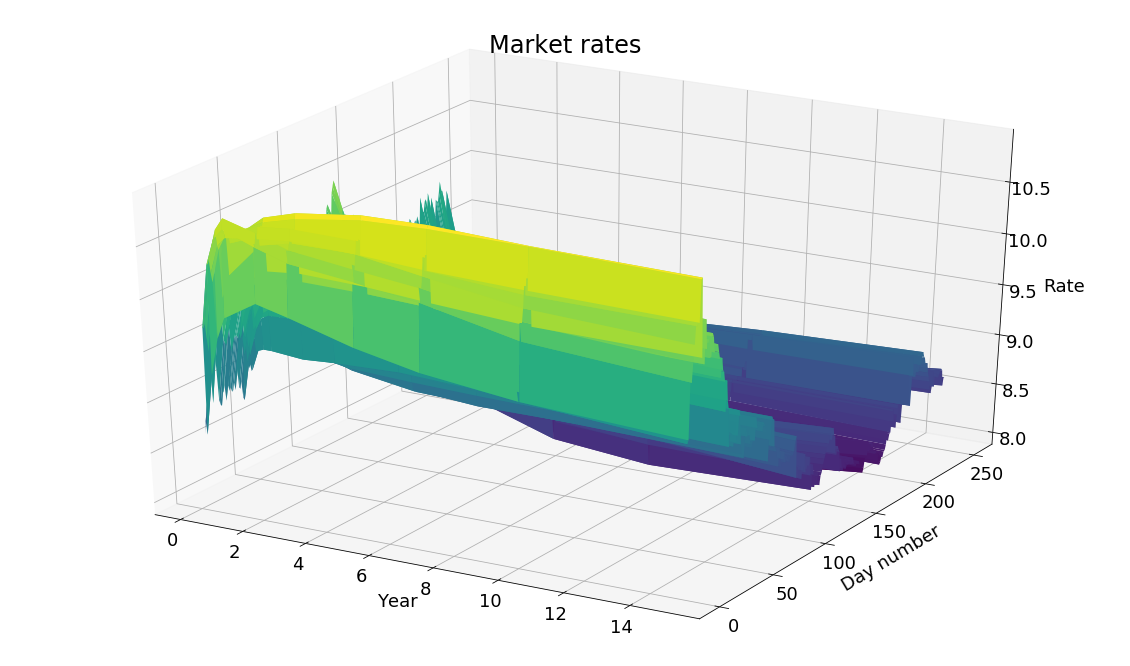

In [78]:
%%time
fig = plt.figure(figsize = (20,12))

m = [np.array([0.25, 0.50, 0.75, 1.00, 2.00, 3.00, 5.00, 7.00, 10.00, 15.00]) for i in range(252)]
m = np.array(m).T
d = [np.arange(252) for i in range(10)]
d = np.array(d)

sub1 = plt.subplot(1, 1, 1, projection='3d')
z1 = rates.values
z1 = z1.T
sub1.plot_surface(m, d, z1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
sub1.set_xlabel('Year', fontsize = 18, labelpad = 13)
sub1.set_ylabel('Day number', fontsize = 18, labelpad = 13)
sub1.set_zlabel('Rate', fontsize = 18, labelpad = 13)
sub1.set_title('Market rates', fontsize = 24)
sub1.tick_params(axis='both', labelsize=18);

In [59]:
%%bash 
say finished

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


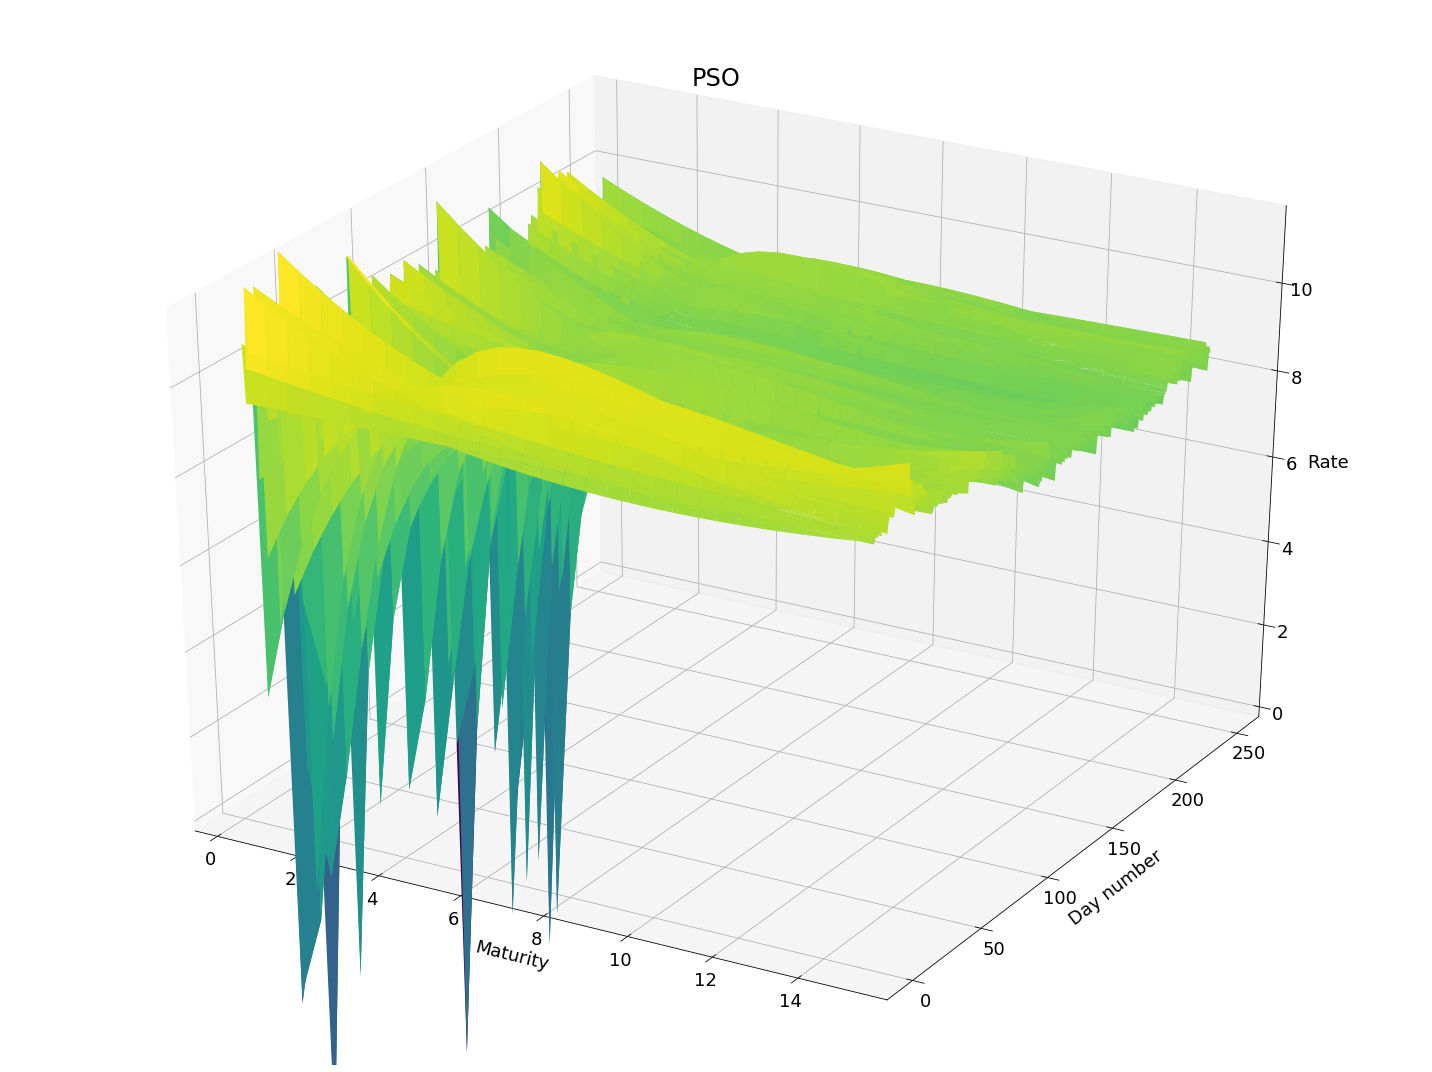

CPU times: user 1.71 s, sys: 50.5 ms, total: 1.76 s
Wall time: 1.4 s


In [64]:
%%time
fig = plt.figure(figsize = (20,15))

m = [np.linspace(0, 15, 31)[1:] for i in range(251)]
m = np.array(m).T
d = [np.arange(251) for i in range(30)]
d = np.array(d)

sub1 = plt.subplot(1, 1, 1, projection='3d')
z1 = [nss(m = np.linspace(0, 15, 31)[1:], theta = results[-1].iloc[i]) for i in range(251)]
z1 = np.array(z1).T
sub1.plot_surface(m, d, z1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
sub1.set_xlabel('Maturity', fontsize = 18, labelpad = 13)
sub1.set_ylabel('Day number', fontsize = 18, labelpad = 13)
sub1.set_zlabel('Rate', fontsize = 18, labelpad = 13)
sub1.set_title('PSO', fontsize = 24)
#sub1.set_xlim(0, 15)
sub1.set_zlim(0, 11.5)
sub1.tick_params(axis='both', labelsize=18)

fig.tight_layout()
plt.show();

In [73]:
b = np.where(z1<11, z1, NaN)

NameError: name 'NaN' is not defined

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


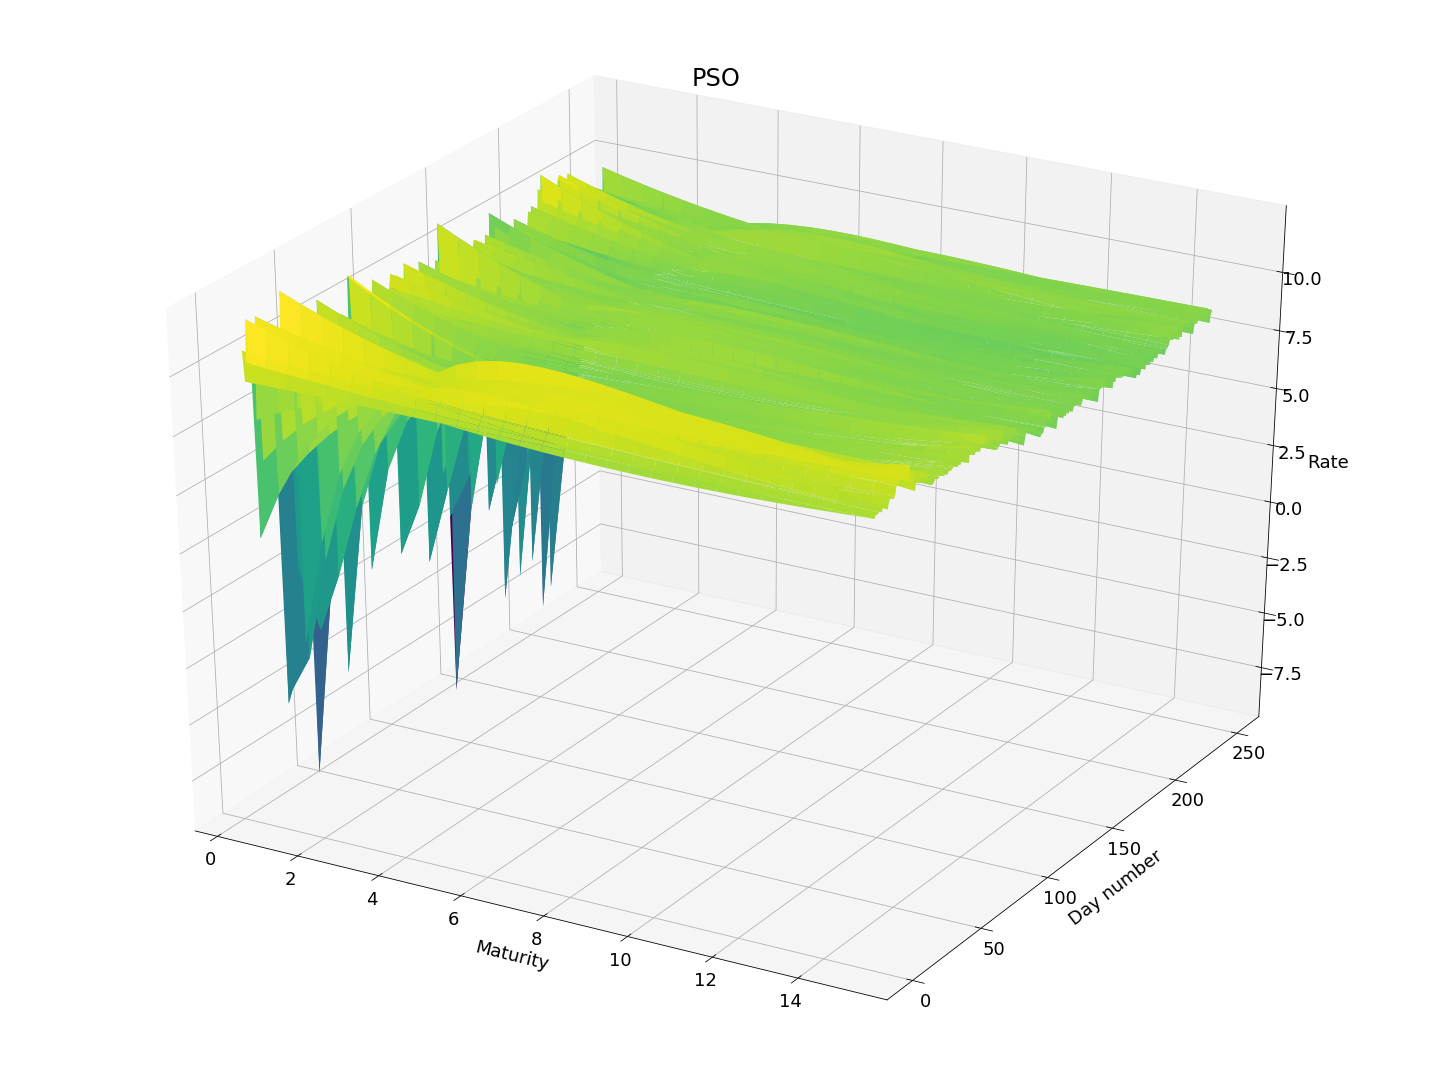

CPU times: user 1.71 s, sys: 134 ms, total: 1.85 s
Wall time: 1.48 s


In [63]:
%%time
fig = plt.figure(figsize = (20,15))

m = [np.linspace(0, 15, 31)[1:] for i in range(251)]
m = np.array(m).T
d = [np.arange(251) for i in range(30)]
d = np.array(d)

sub1 = plt.subplot(1, 1, 1, projection='3d')
z1 = [nss(m = np.linspace(0, 15, 31)[1:], theta = results[-1].iloc[i]) for i in range(251)]
z1 = np.array(z1).T
sub1.plot_surface(m, d, z1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
sub1.set_xlabel('Maturity', fontsize = 18, labelpad = 13)
sub1.set_ylabel('Day number', fontsize = 18, labelpad = 13)
sub1.set_zlabel('Rate', fontsize = 18, labelpad = 13)
sub1.set_title('PSO', fontsize = 24)
sub1.tick_params(axis='both', labelsize=18)

fig.tight_layout()
plt.show();

In [35]:
ms = np.zeros([251, 20])
for i in range(251):
    ms[i] = maturities_irrs(i)[0]

y = np.zeros([251, 20])
for i in range(20):
    y[:, i] = np.arange(251)

irrs = np.zeros([251, 20])
for i in range(251):
    irrs[i] = maturities_irrs(i)[1]
        
#plt.figure(figsize = (20, 10))
#plt.scatter(maturites_irrs(0)[0], maturites_irrs(0)[1], label = str(dates[0].date()))
#plt.scatter(maturites_irrs(100)[0], maturites_irrs(100)[1], label = str(dates[100].date()))
#plt.title('Maturity vs. IRR', fontsize = 24)
#plt.xlabel('Maturity', fontsize = 20)
#plt.ylabel('IRR', fontsize = 20)
#plt.legend(fontsize = 14);

In [231]:
%matplotlib inline

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


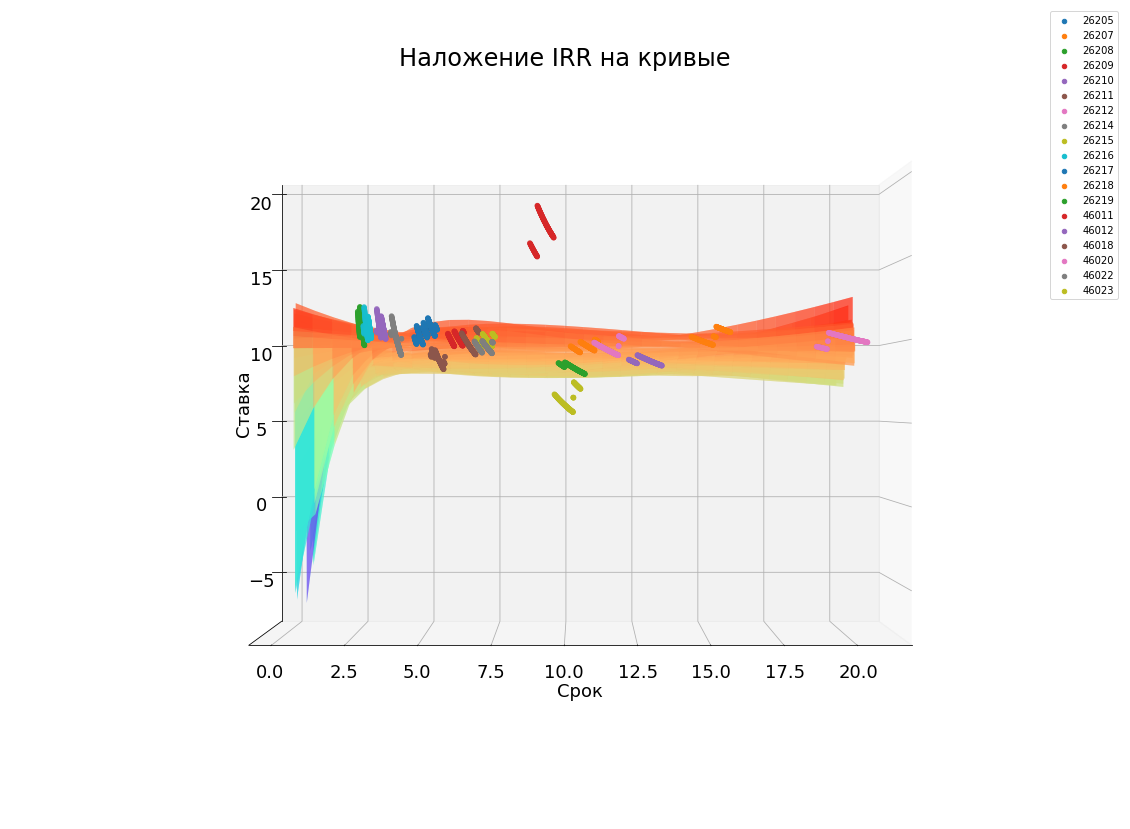

In [96]:
fig = plt.figure(figsize = (20,15))

sub1 = plt.subplot(1, 1, 1, projection='3d')

sub1.set_xlabel('Срок', fontsize = 18, labelpad = 24)
#sub1.set_ylabel('Day number', fontsize = 18, labelpad = 13)
sub1.set_zlabel('Ставка', fontsize = 18, labelpad = 13)
sub1.set_title('Наложение IRR на кривые', fontsize = 24)
sub1.tick_params(axis='both', labelsize=18)
sub1.set_yticks(ticks=[])

labels = bonds_payments['Бумага'].unique()


        
m = [np.linspace(0, 20, 31)[1:] for i in range(251)]
m = np.array(m).T
d = [np.arange(251) for i in range(30)]
d = np.array(d)

z1 = [nss(m = np.linspace(0, 20, 31)[1:], theta = results[-1].iloc[i]) for i in range(251)]
z1 = np.array(z1).T
sub1.plot_surface(m, d, z1, rstride=1, cstride=1, cmap='rainbow', edgecolor='none', alpha=0.5, zorder = 0.3)

for i in range(20):
    if labels[i] != 46019:
        sub1.scatter(ms[:, i], y[:, i], irrs[:, i] * 100,label = labels[i], zorder = 1)

sub1.legend()
sub1.tick_params(axis='both', labelsize=18, direction = 'out', pad =10)
sub1.view_init(0, 270);

In [22]:
import traitsui.toolkit

In [23]:
traitsui.toolkit

<module 'traitsui.toolkit' from '/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/traitsui/toolkit.py'>

In [189]:
%%bash 
say finished

In [16]:
%matplotlib inline

In [15]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# load some test data for demonstration and plot a wireframe
X, Y, Z = axes3d.get_test_data(0.1)
ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5)

# rotate the axes and update
ax.view_init(30, 90)

<IPython.core.display.Javascript object>